In [20]:
# -*- coding: utf-8 -*-
"""
Minimal-Setup:
    pip install pandas numpy scikit-learn matplotlib statsmodels xgboost torch
"""

import os
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

import statsmodels.api as sm
from xgboost import XGBRegressor

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

# ======= USER-INPUT =======
CSV_PATH = r"src\data\raw\timeseries\SHUW_E24_hist.csv"
TIMESTAMP_COL = "timestamp"
CANDIDATE_TARGETS = ["P_MW"]
RAW_FEATURES = ["wind_speed_mps", "solar_radiation_Wm2", "temperature_C"]

# Autoregressive Lags (Vielfache von 15 Minuten)
TARGET_LAGS = [1, 4, 8, 12, 24, 96]  # 15min, 1h, 2h, 3h, 6h, 24h

# Rolling-Window-Längen (in 15-min-Schritten)
ROLL_WINDOWS = {
    "Windgeschw_mps": [4, 12, 24],
    "Globale_Strahlung_Wm2": [4, 12, 24],
}

# Fourier-Saisonalität (Tagesperiodik = 24h = 96 Schritte à 15min)
FOURIER_K = 3
PERIOD_STEPS = 96  # 24h

HOLDOUT_FRAC = 0.2
N_SPLITS = 5
RANDOM_STATE = 42

# LSTM-spezifisch (erstes, bewusst einfaches Setup)
LSTM_LOOKBACK = 24   # 24 Schritte (= 6h bei 15min)
LSTM_EPOCHS = 15
LSTM_BATCH_SIZE = 256
LSTM_PATIENCE = 3
LEARNING_RATE = 1e-3
# ==========================

torch.manual_seed(RANDOM_STATE)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def load_data(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"CSV nicht gefunden: {path}")
    df = pd.read_csv(path)

    target_col = None
    for c in CANDIDATE_TARGETS:
        if c in df.columns:
            target_col = c
            break
    if target_col is None:
        raise KeyError(f"Zielspalte nicht gefunden. Erwartet eine von {CANDIDATE_TARGETS}.")

    if TIMESTAMP_COL not in df.columns:
        raise KeyError(f"Spalte '{TIMESTAMP_COL}' fehlt in CSV.")

    df[TIMESTAMP_COL] = pd.to_datetime(df[TIMESTAMP_COL], utc=False)
    df = df.sort_values(TIMESTAMP_COL).reset_index(drop=True)
    return df, target_col


def add_basic_time_features(df, ts_col):
    ts = df[ts_col]
    df["hour"] = ts.dt.hour
    df["dayofweek"] = ts.dt.dayofweek
    df["month"] = ts.dt.month
    # Zirkuläre Kodierung
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
    df["dow_sin"] = np.sin(2 * np.pi * df["dayofweek"] / 7)
    df["dow_cos"] = np.cos(2 * np.pi * df["dayofweek"] / 7)
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)
    return df


def add_fourier_features(df, period_steps, K, prefix="day"):
    step_idx = np.arange(len(df), dtype=float) % period_steps
    for k in range(1, K + 1):
        df[f"{prefix}_sin{k}"] = np.sin(2 * np.pi * k * step_idx / period_steps)
        df[f"{prefix}_cos{k}"] = np.cos(2 * np.pi * k * step_idx / period_steps)
    return df


def add_target_lags(df, target_col, lags):
    for l in lags:
        df[f"{target_col}_lag{l}"] = df[target_col].shift(l)
    return df


def add_rolling_features(df, windows_dict):
    for col, wins in windows_dict.items():
        if col not in df.columns:
            continue
        for w in wins:
            df[f"{col}_roll{w}_mean"] = df[col].rolling(window=w, min_periods=w).mean()
            df[f"{col}_roll{w}_std"] = df[col].rolling(window=w, min_periods=w).std()
            df[f"{col}_roll{w}_min"] = df[col].rolling(window=w, min_periods=w).min()
            df[f"{col}_roll{w}_max"] = df[col].rolling(window=w, min_periods=w).max()
    return df


def safe_mape(y_true, y_pred, eps=1e-6):
    denom = np.maximum(np.abs(y_true), eps)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100.0


def evaluate(y_true, y_pred, prefix=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mape = safe_mape(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{prefix}MAE:  {mae:,.4f}")
    print(f"{prefix}RMSE: {rmse:,.4f}")
    print(f"{prefix}MAPE: {mape:,.2f}%")
    print(f"{prefix}R²:   {r2:,.4f}")
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape, "R2": r2}


def plot_holdout(ts, y_true, y_pred, title):
    plt.figure(figsize=(12, 5))
    plt.plot(ts, y_true, label="Ist", linewidth=1.5)
    plt.plot(ts, y_pred, label="Prognose", linewidth=1.5, alpha=0.9)
    plt.title(title)
    plt.xlabel("Zeit")
    plt.ylabel("Ziel")
    plt.legend()
    plt.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()


# ===================== ARIMA =====================

def select_arima_order(y_train, candidate_orders):
    n = len(y_train)
    split_idx = int(0.8 * n)
    y_tr = y_train[:split_idx]
    y_val = y_train[split_idx:]

    best_order = None
    best_mae = np.inf

    print("\n[ARIMA] Suche nach gutem (p,d,q)...")
    for order in candidate_orders:
        try:
            start_t = time.time()
            model = sm.tsa.SARIMAX(
                y_tr,
                order=order,
                enforce_stationarity=False,
                enforce_invertibility=False,
            )
            res = model.fit(disp=False)
            val_forecast = res.forecast(steps=len(y_val))
            mae = mean_absolute_error(y_val, val_forecast)
            dur = time.time() - start_t
            print(f"  Order={order}, MAE={mae:.4f}, Zeit={dur:.1f}s")
            if mae < best_mae:
                best_mae = mae
                best_order = order
        except Exception as e:
            print(f"  Order={order} übersprungen (Fehler: {e})")
            continue

    print(f"[ARIMA] Beste Ordnung laut Val-MAE: {best_order} (MAE={best_mae:.4f})")
    return best_order


def run_arima(y_train, y_test):
    candidate_orders = [
        (1, 0, 1),
        (2, 0, 2),
        (1, 1, 1),
        (2, 1, 1),
    ]

    best_order = select_arima_order(y_train, candidate_orders)

    print("\n[ARIMA] Finale Anpassung auf gesamtem Trainingszeitraum...")
    start_t = time.time()
    model = sm.tsa.SARIMAX(
        y_train,
        order=best_order,
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    res = model.fit(disp=False)
    y_pred_test = res.forecast(steps=len(y_test))
    dur = time.time() - start_t
    print(f"[ARIMA] Trainings+Forecast-Dauer (Train->Test): {dur:.1f}s")

    scores = evaluate(y_test, y_pred_test, prefix="ARIMA TST ")
    return scores, best_order, y_pred_test


# ===================== Random Forest & XGBoost =====================

def run_tree_model(model_name, base_model, param_grid, X_train, y_train, X_test, y_test):
    print(f"\n[{model_name}] Hyperparameter-Suche (kleines Grid, erste Optimierung)...")
    tscv = TimeSeriesSplit(n_splits=N_SPLITS)
    grid = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        scoring="neg_mean_absolute_error",
        cv=tscv,
        n_jobs=-1,
        verbose=1,
    )
    start_t = time.time()
    grid.fit(X_train, y_train)
    dur = time.time() - start_t
    print(f"[{model_name}] Beste Parameter: {grid.best_params_}")
    print(f"[{model_name}] Beste CV-MAE: {-grid.best_score_:.4f}")
    print(f"[{model_name}] GridSearch-Dauer: {dur:.1f}s")

    best_model = grid.best_estimator_
    y_pred_test = best_model.predict(X_test)
    scores = evaluate(y_test, y_pred_test, prefix=f"{model_name} TST ")
    return scores, grid.best_params_, y_pred_test


# ===================== LSTM (PyTorch) =====================

def create_lstm_dataset(series, lookback):
    """
    Univariate LSTM:
    X_t = [y_{t-lookback}, ..., y_{t-1}], y_t = Ziel.
    """
    X, y = [], []
    for i in range(lookback, len(series)):
        X.append(series[i - lookback:i])
        y.append(series[i])
    X = np.array(X)
    y = np.array(y)
    # Form: (samples, timesteps, features=1)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    return X, y


class LSTMRegressor(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, dropout=0.0):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            batch_first=True,
        )
        self.dropout = nn.Dropout(dropout) if dropout > 0.0 else nn.Identity()
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # letztes Zeitfenster
        out = self.dropout(out)
        out = self.fc(out)
        return out


def train_lstm_model(
    X_tr,
    y_tr,
    X_val,
    y_val,
    hidden_size,
    dropout,
    epochs=LSTM_EPOCHS,
    batch_size=LSTM_BATCH_SIZE,
):
    X_tr_t = torch.tensor(X_tr, dtype=torch.float32).to(DEVICE)
    y_tr_t = torch.tensor(y_tr, dtype=torch.float32).unsqueeze(-1).to(DEVICE)
    X_val_t = torch.tensor(X_val, dtype=torch.float32).to(DEVICE)
    y_val_t = torch.tensor(y_val, dtype=torch.float32).unsqueeze(-1).to(DEVICE)

    train_ds = TensorDataset(X_tr_t, y_tr_t)
    val_ds = TensorDataset(X_val_t, y_val_t)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    model = LSTMRegressor(input_size=1, hidden_size=hidden_size, dropout=dropout).to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    best_val_loss = np.inf
    best_state = None
    no_improve = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * xb.size(0)
        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                preds = model(xb)
                loss = criterion(preds, yb)
                val_loss += loss.item() * xb.size(0)
        val_loss /= len(val_loader.dataset)

        # Early Stopping
        if val_loss < best_val_loss - 1e-6:
            best_val_loss = val_loss
            best_state = model.state_dict()
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= LSTM_PATIENCE:
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, best_val_loss


def run_lstm(y_train, y_test, lookback=LSTM_LOOKBACK):
    print("\n[LSTM] Erzeuge Sequenzdaten...")
    y_full = np.concatenate([y_train, y_test])
    X_seq, y_seq = create_lstm_dataset(y_full, lookback)

    n_train = len(y_train)
    last_train_idx = n_train - 1
    train_seq_end = last_train_idx - lookback

    X_train_seq = X_seq[: train_seq_end + 1]
    y_train_seq = y_seq[: train_seq_end + 1]
    X_test_seq = X_seq[train_seq_end + 1:]
    y_test_seq = y_seq[train_seq_end + 1:]

    print(f"[LSTM] Seq-Train: {X_train_seq.shape}, Seq-Test: {X_test_seq.shape}")

    n_seq_train = len(X_train_seq)
    val_split_idx = int(0.8 * n_seq_train)
    X_tr, X_val = X_train_seq[:val_split_idx], X_train_seq[val_split_idx:]
    y_tr, y_val = y_train_seq[:val_split_idx], y_train_seq[val_split_idx:]

    candidate_params = [
        {"hidden_size": 32, "dropout": 0.0},
        {"hidden_size": 64, "dropout": 0.0},
        {"hidden_size": 64, "dropout": 0.2},
    ]

    best_cfg = None
    best_mae = np.inf

    print("[LSTM] Hyperparameter-Suche (hidden_size, dropout)...")
    for cfg in candidate_params:
        print(f"  Teste cfg={cfg} ...")
        start_t = time.time()
        model, best_val_loss = train_lstm_model(
            X_tr,
            y_tr,
            X_val,
            y_val,
            hidden_size=cfg["hidden_size"],
            dropout=cfg["dropout"],
        )
        dur = time.time() - start_t

        model.eval()
        with torch.no_grad():
            X_val_t = torch.tensor(X_val, dtype=torch.float32).to(DEVICE)
            val_pred = model(X_val_t).cpu().numpy().flatten()
        mae = mean_absolute_error(y_val, val_pred)
        print(f"    -> Val-MAE={mae:.4f}, Zeit={dur:.1f}s, best_val_loss={best_val_loss:.4f}")
        if mae < best_mae:
            best_mae = mae
            best_cfg = cfg

    print(f"[LSTM] Beste Konfiguration: {best_cfg}, Val-MAE={best_mae:.4f}")

    # Finale Anpassung auf allen Seq-Train-Daten
    print("[LSTM] Finale Anpassung mit bester Konfiguration...")
    start_t = time.time()
    model, _ = train_lstm_model(
        X_train_seq,
        y_train_seq,
        X_val=X_train_seq[int(0.9 * len(X_train_seq)):],
        y_val=y_train_seq[int(0.9 * len(X_train_seq)):],
        hidden_size=best_cfg["hidden_size"],
        dropout=best_cfg["dropout"],
    )
    dur = time.time() - start_t
    print(f"[LSTM] Trainingsdauer gesamt: {dur:.1f}s")

    model.eval()
    with torch.no_grad():
        X_test_t = torch.tensor(X_test_seq, dtype=torch.float32).to(DEVICE)
        y_pred_test_seq = model(X_test_t).cpu().numpy().flatten()

    scores = evaluate(y_test_seq, y_pred_test_seq, prefix="LSTM TST ")
    return scores, best_cfg, y_pred_test_seq


# ===================== MAIN =====================

def main():
    df, target_col = load_data(CSV_PATH)

    # Basis-Zeitfeatures + Fourier
    df = add_basic_time_features(df, TIMESTAMP_COL)
    df = add_fourier_features(df, PERIOD_STEPS, FOURIER_K, prefix="day")

    present_feats = [c for c in RAW_FEATURES if c in df.columns]
    missing = sorted(set(RAW_FEATURES) - set(present_feats))
    if missing:
        print(f"Warnung: fehlen im Datensatz und werden ignoriert: {missing}")

    df = add_rolling_features(df, ROLL_WINDOWS)
    df = add_target_lags(df, target_col, TARGET_LAGS)

    base_time_feats = ["hour_sin", "hour_cos", "dow_sin", "dow_cos", "month_sin", "month_cos"]
    fourier_feats = [f"day_sin{k}" for k in range(1, FOURIER_K + 1)] + \
                    [f"day_cos{k}" for k in range(1, FOURIER_K + 1)]
    lag_feats = [f"{target_col}_lag{l}" for l in TARGET_LAGS]
    roll_feats = [c for c in df.columns
                  if any(c.startswith(f"{f}_roll") for f in ROLL_WINDOWS.keys())]

    X_cols = present_feats + base_time_feats + fourier_feats + lag_feats + roll_feats

    df_model = df.dropna(subset=X_cols + [target_col]).copy()

    n = len(df_model)
    split_idx = int((1.0 - HOLDOUT_FRAC) * n)
    X = df_model[X_cols]
    y = df_model[target_col]

    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    print(f"Datengrößen – Gesamt: {n}, Train: {len(X_train)}, Test (Holdout): {len(X_test)}")

    # ===== Baseline (Naive: y_hat_t = y_{t-1}) =====
    y_train_baseline = df_model[f"{target_col}_lag1"].iloc[:split_idx].values
    y_test_baseline = df_model[f"{target_col}_lag1"].iloc[split_idx:].values

    print("\nBaseline (Naive Persistence) – Scores:")
    _ = evaluate(y_train.values, y_train_baseline, prefix="BL  (Train) ")
    bl_scores = evaluate(y_test.values, y_test_baseline, prefix="BL  (Test)  ")

    # ===== ARIMA =====
    arima_scores, arima_order, arima_pred = run_arima(y_train.values, y_test.values)

    # ===== Random Forest =====
    rf_base = RandomForestRegressor(
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )
    rf_param_grid = {
        "n_estimators": [200, 400],
        "max_depth": [None, 12],
        "min_samples_leaf": [1, 10],
    }
    rf_scores, rf_best_params, rf_pred = run_tree_model(
        "RF", rf_base, rf_param_grid, X_train, y_train, X_test, y_test
    )

    # ===== XGBoost =====
    xgb_base = XGBRegressor(
        objective="reg:squarederror",
        random_state=RANDOM_STATE,
        n_estimators=400,
        tree_method="hist",
        eval_metric="rmse",
    )
    xgb_param_grid = {
        "max_depth": [4, 8],
        "learning_rate": [0.05, 0.1],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
    }
    xgb_scores, xgb_best_params, xgb_pred = run_tree_model(
        "XGB", xgb_base, xgb_param_grid, X_train, y_train, X_test, y_test
    )

    # ===== LSTM (PyTorch) =====
    lstm_scores, lstm_best_cfg, lstm_pred = run_lstm(y_train.values, y_test.values)

    # ===== Plot beispielhaft (Holdout: XGB vs Ist) =====
    ts_holdout = df_m
    odel[TIMESTAMP_COL].iloc[split_idx:]
    plot_holdout(ts_holdout, y_test.values, xgb_pred, title=f"Vorhersage {target_col} – Holdout (XGB)")

    print("\n=== Zusammenfassung (Test/Holdout) ===")
    print("Baseline:", bl_scores)
    print(f"ARIMA (order={arima_order}):", arima_scores)
    print(f"RF (best_params={rf_best_params}):", rf_scores)
    print(f"XGB (best_params={xgb_best_params}):", xgb_scores)
    print(f"LSTM (best_cfg={lstm_best_cfg}):", lstm_scores)


if __name__ == "__main__":
    main()


FileNotFoundError: CSV nicht gefunden: src\data\raw\timeseries\SHUW_E24_hist.csv

In [ ]:
# -*- coding: utf-8 -*-
"""
Minimal-Setup:
    pip install pandas numpy scikit-learn matplotlib xgboost torch
"""

import os
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

# ======= USER-INPUT =======
CSV_PATH = r"src/data/raw/timeseries/SHUW_E24_hist.csv"
TIMESTAMP_COL = "timestamp"
CANDIDATE_TARGETS = ["P_MW"]

# Achtung: diese Namen müssen zu deiner CSV passen
RAW_FEATURES = ["wind_speed_mps", "solar_radiation_Wm2", "temperature_C"]

# Autoregressive Lags (Vielfache von 15 Minuten)
TARGET_LAGS = [1, 4, 8, 12, 24, 96]  # 15min, 1h, 2h, 3h, 6h, 24h

# Rolling-Window-Längen (in 15-min-Schritten) – Spaltennamen anpassen!
ROLL_WINDOWS = {
    "Windgeschw_mps": [4, 12, 24],
    "Globale_Strahlung_Wm2": [4, 12, 24],
}

# Fourier-Saisonalität (Tagesperiodik = 24h = 96 Schritte à 15min)
FOURIER_K = 3
PERIOD_STEPS = 96  # 24h

# Vorhersagehorizont: 24h = 96 * 15min
HORIZON_STEPS = 96

HOLDOUT_FRAC = 0.2
N_SPLITS = 5
RANDOM_STATE = 42

# LSTM-spezifisch
LSTM_LOOKBACK = 24   # 24 Schritte (= 6h bei 15min)
LSTM_EPOCHS = 15
LSTM_BATCH_SIZE = 256
LSTM_PATIENCE = 3
LEARNING_RATE = 1e-3
# ==========================

torch.manual_seed(RANDOM_STATE)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def load_data(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"CSV nicht gefunden: {path}")
    df = pd.read_csv(path)

    target_col = None
    for c in CANDIDATE_TARGETS:
        if c in df.columns:
            target_col = c
            break
    if target_col is None:
        raise KeyError(f"Zielspalte nicht gefunden. Erwartet eine von {CANDIDATE_TARGETS}.")

    if TIMESTAMP_COL not in df.columns:
        raise KeyError(f"Spalte '{TIMESTAMP_COL}' fehlt in CSV.")

    df[TIMESTAMP_COL] = pd.to_datetime(df[TIMESTAMP_COL], utc=False)
    df = df.sort_values(TIMESTAMP_COL).reset_index(drop=True)
    return df, target_col


def add_basic_time_features(df, ts_col):
    ts = df[ts_col]
    df["hour"] = ts.dt.hour
    df["dayofweek"] = ts.dt.dayofweek
    df["month"] = ts.dt.month
    # Zirkuläre Kodierung
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
    df["dow_sin"] = np.sin(2 * np.pi * df["dayofweek"] / 7)
    df["dow_cos"] = np.cos(2 * np.pi * df["dayofweek"] / 7)
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)
    return df


def add_fourier_features(df, period_steps, K, prefix="day"):
    step_idx = np.arange(len(df), dtype=float) % period_steps
    for k in range(1, K + 1):
        df[f"{prefix}_sin{k}"] = np.sin(2 * np.pi * k * step_idx / period_steps)
        df[f"{prefix}_cos{k}"] = np.cos(2 * np.pi * k * step_idx / period_steps)
    return df


def add_target_lags(df, target_col, lags):
    for l in lags:
        df[f"{target_col}_lag{l}"] = df[target_col].shift(l)
    return df


def add_rolling_features(df, windows_dict):
    for col, wins in windows_dict.items():
        if col not in df.columns:
            continue
        for w in wins:
            df[f"{col}_roll{w}_mean"] = df[col].rolling(window=w, min_periods=w).mean()
            df[f"{col}_roll{w}_std"] = df[col].rolling(window=w, min_periods=w).std()
            df[f"{col}_roll{w}_min"] = df[col].rolling(window=w, min_periods=w).min()
            df[f"{col}_roll{w}_max"] = df[col].rolling(window=w, min_periods=w).max()
    return df


def safe_mape(y_true, y_pred, eps=1e-6):
    denom = np.maximum(np.abs(y_true), eps)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100.0


def evaluate(y_true, y_pred, prefix=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mape = safe_mape(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{prefix}MAE:  {mae:,.4f}")
    print(f"{prefix}RMSE: {rmse:,.4f}")
    print(f"{prefix}MAPE: {mape:,.2f}%")
    print(f"{prefix}R²:   {r2:,.4f}")
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape, "R2": r2}


def plot_holdout(ts, y_true, y_pred, title):
    plt.figure(figsize=(12, 5))
    plt.plot(ts, y_true, label="Ist (24h-Ziel)", linewidth=1.5)
    plt.plot(ts, y_pred, label="Prognose (24h)", linewidth=1.5, alpha=0.9)
    plt.title(title)
    plt.xlabel("Zeit (Zielzeitpunkt)")
    plt.ylabel("Leistung [MW]")
    plt.legend()
    plt.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()


# ===================== Random Forest & XGBoost =====================

def run_tree_model(model_name, base_model, param_grid, X_train, y_train, X_test, y_test):
    print(f"\n[{model_name}] Hyperparameter-Suche (GridSearch)...")
    tscv = TimeSeriesSplit(n_splits=N_SPLITS)
    grid = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        scoring="neg_mean_absolute_error",
        cv=tscv,
        n_jobs=-1,
        verbose=1,
    )
    start_t = time.time()
    grid.fit(X_train, y_train)
    dur = time.time() - start_t
    print(f"[{model_name}] Beste Parameter: {grid.best_params_}")
    print(f"[{model_name}] Beste CV-MAE: {-grid.best_score_:.4f}")
    print(f"[{model_name}] GridSearch+Fit-Dauer: {dur:.1f}s")

    best_model = grid.best_estimator_
    y_pred_test = best_model.predict(X_test)
    scores = evaluate(y_test, y_pred_test, prefix=f"{model_name} TST (24h) ")
    return scores, grid.best_params_, y_pred_test, dur


# ===================== LSTM (PyTorch) =====================

def create_lstm_dataset(series, lookback, horizon_steps):
    """
    Univariate LSTM:
    Eingabe:  [y_{t-lookback}, ..., y_{t-1}]
    Ziel:     y_{t + horizon_steps}
    """
    X, y = [], []
    n = len(series)
    # letzter gültiger Index t: t + horizon_steps < n  → t <= n - horizon_steps - 1
    for t in range(lookback, n - horizon_steps):
        X.append(series[t - lookback:t])
        y.append(series[t + horizon_steps])
    X = np.array(X)
    y = np.array(y)
    # Form: (samples, timesteps, features=1)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    return X, y


class LSTMRegressor(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, dropout=0.0):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            batch_first=True,
        )
        self.dropout = nn.Dropout(dropout) if dropout > 0.0 else nn.Identity()
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # letztes Zeitfenster
        out = self.dropout(out)
        out = self.fc(out)
        return out


def train_lstm_model(
    X_tr,
    y_tr,
    X_val,
    y_val,
    hidden_size,
    dropout,
    epochs=LSTM_EPOCHS,
    batch_size=LSTM_BATCH_SIZE,
):
    X_tr_t = torch.tensor(X_tr, dtype=torch.float32).to(DEVICE)
    y_tr_t = torch.tensor(y_tr, dtype=torch.float32).unsqueeze(-1).to(DEVICE)
    X_val_t = torch.tensor(X_val, dtype=torch.float32).to(DEVICE)
    y_val_t = torch.tensor(y_val, dtype=torch.float32).unsqueeze(-1).to(DEVICE)

    train_ds = TensorDataset(X_tr_t, y_tr_t)
    val_ds = TensorDataset(X_val_t, y_val_t)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    model = LSTMRegressor(input_size=1, hidden_size=hidden_size, dropout=dropout).to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    best_val_loss = np.inf
    best_state = None
    no_improve = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * xb.size(0)
        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                preds = model(xb)
                loss = criterion(preds, yb)
                val_loss += loss.item() * xb.size(0)
        val_loss /= len(val_loader.dataset)

        # Early Stopping
        if val_loss < best_val_loss - 1e-6:
            best_val_loss = val_loss
            best_state = model.state_dict()
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= LSTM_PATIENCE:
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, best_val_loss


def run_lstm(y_series, split_idx, lookback=LSTM_LOOKBACK, horizon_steps=HORIZON_STEPS):
    """
    y_series: komplette Zeitreihe (Train+Test) als 1D-Array
    split_idx: Index-Grenze Train/Test in Originalzeitreihe (wie in main)
    horizon_steps: Vorhersagehorizont in Schritten (z.B. 96 für 24h)
    """
    print("\n[LSTM] Erzeuge Sequenzdaten (24h-Horizont)...")

    X_seq, y_seq = create_lstm_dataset(y_series, lookback, horizon_steps)
    n_seq = len(y_seq)

    # Zielzeitpunkte pro Sample:
    # t_target = (lookback + i) + horizon_steps
    t_targets = np.arange(lookback, lookback + n_seq) + horizon_steps

    # Train-Samples: Zielzeitpunkt in Trainingsbereich
    train_mask = t_targets < split_idx
    test_mask = t_targets >= split_idx

    X_train_seq = X_seq[train_mask]
    y_train_seq = y_seq[train_mask]
    X_test_seq = X_seq[test_mask]
    y_test_seq = y_seq[test_mask]

    print(f"[LSTM] Seq-Train: {X_train_seq.shape}, Seq-Test: {X_test_seq.shape}")

    # 80/20 Val-Split innerhalb des Trainingsbereichs
    n_seq_train = len(X_train_seq)
    val_split_idx = int(0.8 * n_seq_train)
    X_tr, X_val = X_train_seq[:val_split_idx], X_train_seq[val_split_idx:]
    y_tr, y_val = y_train_seq[:val_split_idx], y_train_seq[val_split_idx:]

    candidate_params = [
        {"hidden_size": 32, "dropout": 0.0},
        {"hidden_size": 64, "dropout": 0.0},
        {"hidden_size": 64, "dropout": 0.2},
    ]

    best_cfg = None
    best_mae = np.inf
    total_start = time.time()

    print("[LSTM] Hyperparameter-Suche (hidden_size, dropout)...")
    for cfg in candidate_params:
        print(f"  Teste cfg={cfg} ...")
        start_t = time.time()
        model, best_val_loss = train_lstm_model(
            X_tr,
            y_tr,
            X_val,
            y_val,
            hidden_size=cfg["hidden_size"],
            dropout=cfg["dropout"],
        )
        dur = time.time() - start_t

        model.eval()
        with torch.no_grad():
            X_val_t = torch.tensor(X_val, dtype=torch.float32).to(DEVICE)
            val_pred = model(X_val_t).cpu().numpy().flatten()
        mae = mean_absolute_error(y_val, val_pred)
        print(f"    -> Val-MAE={mae:.4f}, Zeit={dur:.1f}s, best_val_loss={best_val_loss:.4f}")
        if mae < best_mae:
            best_mae = mae
            best_cfg = cfg

    print(f"[LSTM] Beste Konfiguration: {best_cfg}, Val-MAE={best_mae:.4f}")

    # Finale Anpassung auf allen Trainingssequenzen
    print("[LSTM] Finale Anpassung mit bester Konfiguration...")
    start_t = time.time()
    model, _ = train_lstm_model(
        X_train_seq,
        y_train_seq,
        X_val=X_train_seq[int(0.9 * len(X_train_seq)):],
        y_val=y_train_seq[int(0.9 * len(X_train_seq)):],
        hidden_size=best_cfg["hidden_size"],
        dropout=best_cfg["dropout"],
    )
    dur_final = time.time() - start_t
    total_dur = time.time() - total_start
    print(f"[LSTM] Trainingsdauer (final): {dur_final:.1f}s")
    print(f"[LSTM] Gesamtdauer (HPO + final): {total_dur:.1f}s")

    model.eval()
    with torch.no_grad():
        X_test_t = torch.tensor(X_test_seq, dtype=torch.float32).to(DEVICE)
        y_pred_test_seq = model(X_test_t).cpu().numpy().flatten()

    scores = evaluate(y_test_seq, y_pred_test_seq, prefix="LSTM TST (24h) ")
    return scores, best_cfg, y_pred_test_seq, total_dur


# ===================== MAIN =====================

def main():
    df, target_col = load_data(CSV_PATH)

    # Basis-Zeitfeatures + Fourier
    df = add_basic_time_features(df, TIMESTAMP_COL)
    df = add_fourier_features(df, PERIOD_STEPS, FOURIER_K, prefix="day")

    # Zielzeitpunkt (24h später) für Plot/Interpretation
    df["timestamp_target"] = df[TIMESTAMP_COL] + pd.to_timedelta(15 * HORIZON_STEPS, unit="m")

    # Verfügbare Rohfeatures prüfen
    present_feats = [c for c in RAW_FEATURES if c in df.columns]
    missing = sorted(set(RAW_FEATURES) - set(present_feats))
    if missing:
        print(f"Warnung: fehlen im Datensatz und werden ignoriert: {missing}")

    df = add_rolling_features(df, ROLL_WINDOWS)
    df = add_target_lags(df, target_col, TARGET_LAGS)

    base_time_feats = ["hour_sin", "hour_cos", "dow_sin", "dow_cos", "month_sin", "month_cos"]
    fourier_feats = [f"day_sin{k}" for k in range(1, FOURIER_K + 1)] + \
                    [f"day_cos{k}" for k in range(1, FOURIER_K + 1)]
    lag_feats = [f"{target_col}_lag{l}" for l in TARGET_LAGS]
    roll_feats = [c for c in df.columns
                  if any(c.startswith(f"{f}_roll") for f in ROLL_WINDOWS.keys())]

    X_cols = present_feats + base_time_feats + fourier_feats + lag_feats + roll_feats

    # Ziel: P in 24h (HORIZON_STEPS)
    # target_24 ist der Wert HORIZON_STEPS Schritte in der Zukunft
    df["target_24"] = df[target_col].shift(-HORIZON_STEPS)

    # Drop Zeilen ohne vollständige Features/Ziel
    df_model = df.dropna(subset=X_cols + ["target_24", target_col]).copy()

    n = len(df_model)
    split_idx = int((1.0 - HOLDOUT_FRAC) * n)
    X = df_model[X_cols]
    y = df_model["target_24"]

    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    print(f"Datengrößen – Gesamt: {n}, Train: {len(X_train)}, Test (Holdout): {len(X_test)}")
    print(f"Vorhersagehorizont: {HORIZON_STEPS} Schritte = 24h")

    # ===== Baseline (Naive 24h-Persistence: y_hat_{t+24h} = y_t) =====
    print("\nBaseline (Naive 24h-Persistence) – Scores:")
    y_train_baseline = df_model[target_col].iloc[:split_idx].values
    y_test_baseline = df_model[target_col].iloc[split_idx:].values
    _ = evaluate(y_train.values, y_train_baseline, prefix="BL  (Train) ")
    bl_scores = evaluate(y_test.values, y_test_baseline, prefix="BL  (Test)  ")

    # ===== Random Forest =====
    rf_base = RandomForestRegressor(
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )
    rf_param_grid = {
        "n_estimators": [200, 400],
        "max_depth": [None, 12],
        "min_samples_leaf": [1, 10],
    }
    rf_scores, rf_best_params, rf_pred, rf_time = run_tree_model(
        "RF", rf_base, rf_param_grid, X_train, y_train, X_test, y_test
    )

    # ===== XGBoost =====
    xgb_base = XGBRegressor(
        objective="reg:squarederror",
        random_state=RANDOM_STATE,
        n_estimators=400,
        tree_method="hist",
        eval_metric="rmse",
    )
    xgb_param_grid = {
        "max_depth": [4, 8],
        "learning_rate": [0.05, 0.1],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
    }
    xgb_scores, xgb_best_params, xgb_pred, xgb_time = run_tree_model(
        "XGB", xgb_base, xgb_param_grid, X_train, y_train, X_test, y_test
    )

    # ===== LSTM (PyTorch) =====
    # komplette Serie für LSTM
    y_series = df_model[target_col].values
    lstm_scores, lstm_best_cfg, lstm_pred, lstm_time = run_lstm(
        y_series,
        split_idx,
        lookback=LSTM_LOOKBACK,
        horizon_steps=HORIZON_STEPS,
    )

    # ===== Plot beispielhaft (Holdout: XGB vs Ist, 24h-Ziel) =====
    ts_holdout = df_model["timestamp_target"].iloc[split_idx:]
    plot_holdout(ts_holdout, y_test.values, xgb_pred, title=f"24h-Vorhersage {target_col} – Holdout (XGB)")

    print("\n=== Zusammenfassung (Test/Holdout, 24h-Horizont) ===")
    print("Baseline:", bl_scores)
    print(f"RF (best_params={rf_best_params}):", rf_scores)
    print(f"XGB (best_params={xgb_best_params}):", xgb_scores)
    print(f"LSTM (best_cfg={lstm_best_cfg}):", lstm_scores)

    print("\n=== Trainingszeiten (ca.) ===")
    print(f"RF   (GridSearch + Fit): {rf_time:.1f}s")
    print(f"XGB  (GridSearch + Fit): {xgb_time:.1f}s")
    print(f"LSTM (HPO + final Fit):  {lstm_time:.1f}s")


if __name__ == "__main__":
    main()


Datengrößen – Gesamt: 64340, Train: 51472, Test (Holdout): 12868
Vorhersagehorizont: 96 Schritte = 24h

Baseline (Naive 24h-Persistence) – Scores:
BL  (Train) MAE:  25.4738
BL  (Train) RMSE: 33.9412
BL  (Train) MAPE: 7,031,446.25%
BL  (Train) R²:   -0.3644
BL  (Test)  MAE:  26.7298
BL  (Test)  RMSE: 34.2671
BL  (Test)  MAPE: 317.73%
BL  (Test)  R²:   -0.3318

[RF] Hyperparameter-Suche (GridSearch)...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[RF] Beste Parameter: {'max_depth': 12, 'min_samples_leaf': 1, 'n_estimators': 200}
[RF] Beste CV-MAE: 23.5111
[RF] GridSearch+Fit-Dauer: 340.2s
RF TST (24h) MAE:  22.1786
RF TST (24h) RMSE: 28.6584
RF TST (24h) MAPE: 416.18%
RF TST (24h) R²:   0.0685

[XGB] Hyperparameter-Suche (GridSearch)...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[XGB] Beste Parameter: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'subsample': 1.0}
[XGB] Beste CV-MAE: 23.8430
[XGB] GridSearch+Fit-Dauer: 21.1s
XGB TST (24h) MAE:  22.1036
XGB TST (24h) RMSE: 28.8286
XGB TST (24h) MAPE: 382.26%
XGB TST (24h) R²:   0.0574

[LSTM] Erzeuge Sequenzdaten (24h-Horizont)...
[LSTM] Seq-Train: (51352, 24, 1), Seq-Test: (12868, 24, 1)
[LSTM] Hyperparameter-Suche (hidden_size, dropout)...
  Teste cfg={'hidden_size': 32, 'dropout': 0.0} ...


In [21]:
# -*- coding: utf-8 -*-
"""
One-Step-Forecast (t+1, 15 Minuten)
Modelle: RandomForest, XGBoost
Mit Hyperparameter-Tuning via GridSearchCV + TimeSeriesSplit

Benötigte Pakete:
    pip install pandas numpy scikit-learn matplotlib xgboost
"""

import os
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# ===================== USER SETTINGS =====================
CSV_PATH = r"src/data/raw/timeseries/SHUW_E24_hist.csv"
TIMESTAMP_COL = "timestamp"
TARGET = "P_MW"

# Wetter-/Exogene Features (müssen in der CSV existieren)
RAW_FEATURES = ["wind_speed_mps", "solar_radiation_Wm2", "temperature_C"]

# Autoregressive Lags (in 15-Min-Schritten)
TARGET_LAGS = [1, 4, 8, 12, 24, 96]

# Fourier-Saisonalität (Tagesperiodik, 24h = 96 * 15min)
FOURIER_K = 3
PERIOD_STEPS = 96

# Train/Test-Split
HOLDOUT_FRAC = 0.2
N_SPLITS = 5
RANDOM_STATE = 42
# =========================================================


# =========================================================
# Utility / Evaluation
# =========================================================
def safe_mape(y_true, y_pred, eps=1e-6):
    denom = np.maximum(np.abs(y_true), eps)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100.0


def evaluate(y_true, y_pred, prefix=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mape = safe_mape(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{prefix}MAE:  {mae:,.4f}")
    print(f"{prefix}RMSE: {rmse:,.4f}")
    print(f"{prefix}MAPE: {mape:,.2f}%")
    print(f"{prefix}R²:   {r2:,.4f}")
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape, "R2": r2}


def plot_holdout(ts, y_true, y_rf, y_xgb, title="One-Step-Forecast (t+1, 15min)"):
    """Plot Ausschnitt des Holdouts (z.B. letzte 200 Punkte)."""
    plt.figure(figsize=(12, 5))
    plt.plot(ts, y_true, label="Ist (t+1)", linewidth=1.8)
    plt.plot(ts, y_xgb, label="XGB (t+1)", linewidth=1.2, alpha=0.9)
    plt.plot(ts, y_rf, label="RF (t+1)", linewidth=1.0, alpha=0.9)
    plt.title(title)
    plt.xlabel("Zeit (Zielzeitpunkt t+1)")
    plt.ylabel("Leistung [MW]")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.tight_layout()
    plt.show()


# =========================================================
# Feature Engineering
# =========================================================
def load_data(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"CSV nicht gefunden: {path}")
    df = pd.read_csv(path)
    if TIMESTAMP_COL not in df.columns:
        raise KeyError(f"Spalte '{TIMESTAMP_COL}' fehlt in CSV.")
    if TARGET not in df.columns:
        raise KeyError(f"Zielspalte '{TARGET}' fehlt in CSV.")

    df[TIMESTAMP_COL] = pd.to_datetime(df[TIMESTAMP_COL], utc=False)
    df = df.sort_values(TIMESTAMP_COL).reset_index(drop=True)
    return df


def add_time_features(df):
    ts = df[TIMESTAMP_COL]
    df["hour"] = ts.dt.hour
    df["dayofweek"] = ts.dt.dayofweek
    df["month"] = ts.dt.month

    # zirkuläre Kodierung
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
    df["dow_sin"] = np.sin(2 * np.pi * df["dayofweek"] / 7)
    df["dow_cos"] = np.cos(2 * np.pi * df["dayofweek"] / 7)
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)
    return df


def add_fourier_features(df, period_steps=PERIOD_STEPS, K=FOURIER_K, prefix="day"):
    step_idx = np.arange(len(df), dtype=float) % period_steps
    for k in range(1, K + 1):
        df[f"{prefix}_sin{k}"] = np.sin(2 * np.pi * k * step_idx / period_steps)
        df[f"{prefix}_cos{k}"] = np.cos(2 * np.pi * k * step_idx / period_steps)
    return df


def add_target_lags(df, target_col, lags):
    for l in lags:
        df[f"{target_col}_lag{l}"] = df[target_col].shift(l)
    return df


# =========================================================
# Baum-Modelle mit GridSearch
# =========================================================
def run_tree_model(model_name, base_model, param_grid, X_train, y_train, X_test, y_test):
    print(f"\n[{model_name}] Hyperparameter-Suche (GridSearch)...")
    tscv = TimeSeriesSplit(n_splits=N_SPLITS)

    grid = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        scoring="neg_mean_absolute_error",
        cv=tscv,
        n_jobs=-1,
        verbose=1,
    )
    start_t = time.time()
    grid.fit(X_train, y_train)
    dur = time.time() - start_t

    print(f"[{model_name}] Beste Parameter  : {grid.best_params_}")
    print(f"[{model_name}] Beste CV-MAE     : {-grid.best_score_:.4f}")
    print(f"[{model_name}] GridSearch+Fit(s): {dur:.1f}s")

    best_model = grid.best_estimator_
    y_pred_test = best_model.predict(X_test)
    scores = evaluate(y_test, y_pred_test, prefix=f"{model_name} TST (t+1) ")
    return scores, grid.best_params_, y_pred_test, dur


# =========================================================
# MAIN
# =========================================================
def main():
    print("Lade Daten...")
    df = load_data(CSV_PATH)

    # ========== Feature Engineering ==========
    df = add_time_features(df)
    df = add_fourier_features(df)
    df = add_target_lags(df, TARGET, TARGET_LAGS)

    # Ziel: t+1 (ein Schritt = 15 Minuten)
    df["target_1"] = df[TARGET].shift(-1)

    # Verfügbare exogene Features prüfen
    present_feats = [c for c in RAW_FEATURES if c in df.columns]
    missing_feats = sorted(set(RAW_FEATURES) - set(present_feats))
    if missing_feats:
        print(f"Warnung: folgende RAW_FEATURES fehlen und werden ignoriert: {missing_feats}")

    time_feats = ["hour_sin", "hour_cos", "dow_sin", "dow_cos", "month_sin", "month_cos"]
    fourier_feats = [f"day_sin{k}" for k in range(1, FOURIER_K + 1)] + \
                    [f"day_cos{k}" for k in range(1, FOURIER_K + 1)]
    lag_feats = [f"{TARGET}_lag{l}" for l in TARGET_LAGS]

    feature_cols = present_feats + time_feats + fourier_feats + lag_feats

    # NaNs entfernen (wegen Shifts)
    df_model = df.dropna(subset=feature_cols + ["target_1"]).copy()

    X = df_model[feature_cols]
    y = df_model["target_1"]

    n = len(df_model)
    split_idx = int((1.0 - HOLDOUT_FRAC) * n)

    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    print(f"Datengrößen – Gesamt: {n}, Train: {len(X_train)}, Test: {len(X_test)}")
    print("Vorhersagehorizont: t+1 (15 Minuten)")

    # ========== Baseline (Naive Persistence: y_hat_{t+1} = y_t) ==========
    print("\nBaseline (Naive One-Step-Persistence) – Scores:")
    # Baseline nutzt einfach lag1 als Vorhersage
    y_baseline_train = df_model[f"{TARGET}_lag1"].iloc[:split_idx].values
    y_baseline_test = df_model[f"{TARGET}_lag1"].iloc[split_idx:].values

    _ = evaluate(y_train.values, y_baseline_train, prefix="BL  (Train) ")
    bl_scores = evaluate(y_test.values, y_baseline_test, prefix="BL  (Test)  ")

    # ========== Random Forest ==========
    rf_base = RandomForestRegressor(
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )
    rf_param_grid = {
        "n_estimators": [200, 400],
        "max_depth": [None, 12],
        "min_samples_leaf": [1, 10],
    }
    rf_scores, rf_best_params, rf_pred, rf_time = run_tree_model(
        "RF", rf_base, rf_param_grid, X_train, y_train, X_test, y_test
    )

    # ========== XGBoost ==========
    xgb_base = XGBRegressor(
        objective="reg:squarederror",
        random_state=RANDOM_STATE,
        n_estimators=400,
        tree_method="hist",
        eval_metric="rmse",
    )
    xgb_param_grid = {
        "max_depth": [4, 8],
        "learning_rate": [0.05, 0.1],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
    }
    xgb_scores, xgb_best_params, xgb_pred, xgb_time = run_tree_model(
        "XGB", xgb_base, xgb_param_grid, X_train, y_train, X_test, y_test
    )

    # ========== Plot – Ausschnitt Holdout ==========
    # z.B. letzte 200 Punkte
    n_plot = 200
    if len(y_test) <= n_plot:
        start_idx = 0
    else:
        start_idx = len(y_test) - n_plot

    ts_holdout = df_model[TIMESTAMP_COL].iloc[split_idx:]
    plot_holdout(
        ts_holdout.iloc[start_idx:],
        y_test.values[start_idx:],
        rf_pred[start_idx:],
        xgb_pred[start_idx:],
        title=f"One-Step-Vorhersage {TARGET} (t+1, 15min) – Holdout"
    )

    print("\n=== Zusammenfassung (Test/Holdout, t+1) ===")
    print("Baseline:", bl_scores)
    print(f"RF   (best_params={rf_best_params}):", rf_scores)
    print(f"XGB  (best_params={xgb_best_params}):", xgb_scores)

    print("\n=== Trainingszeiten (ca.) ===")
    print(f"RF  (GridSearch + Fit): {rf_time:.1f}s")
    print(f"XGB (GridSearch + Fit): {xgb_time:.1f}s")


if __name__ == "__main__":
    main()


Lade Daten...
Datengrößen – Gesamt: 64306, Train: 51444, Test: 12862
Vorhersagehorizont: t+1 (15 Minuten)

Baseline (Naive One-Step-Persistence) – Scores:
BL  (Train) MAE:  5.7304
BL  (Train) RMSE: 9.6202
BL  (Train) MAPE: 46,446.11%
BL  (Train) R²:   0.8907
BL  (Test)  MAE:  9.7404
BL  (Test)  RMSE: 12.5984
BL  (Test)  MAPE: 116.13%
BL  (Test)  R²:   0.8169

[RF] Hyperparameter-Suche (GridSearch)...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


KeyboardInterrupt: 

=== Kopf des Datensatzes ===
            timestamp       P_MW  temperature_C  wind_speed_mps  \
0 2024-01-01 00:00:00 -22.996800            NaN             NaN   
1 2024-01-01 00:15:00 -23.516007            NaN             NaN   
2 2024-01-01 00:30:00 -23.192500            NaN             NaN   
3 2024-01-01 00:45:00 -22.885967            NaN             NaN   
4 2024-01-01 01:00:00 -24.715713            6.6            17.7   

   solar_radiation_Wm2  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  0.0  

=== Spalten & Datentypen ===
timestamp              datetime64[ns]
P_MW                          float64
temperature_C                 float64
wind_speed_mps                float64
solar_radiation_Wm2           float64
dtype: object

=== Anzahl Zeilen & Zeitraum ===
Zeilen: 68116
Von: 2024-01-01 00:00:00
Bis: 2025-12-10 12:45:00

=== Sampling-Intervall (häufigste Differenz) ===
timestamp
0 days 00:15:00    68115
N

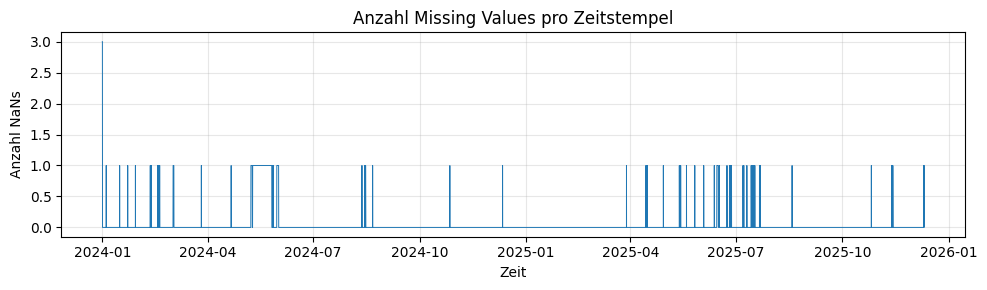

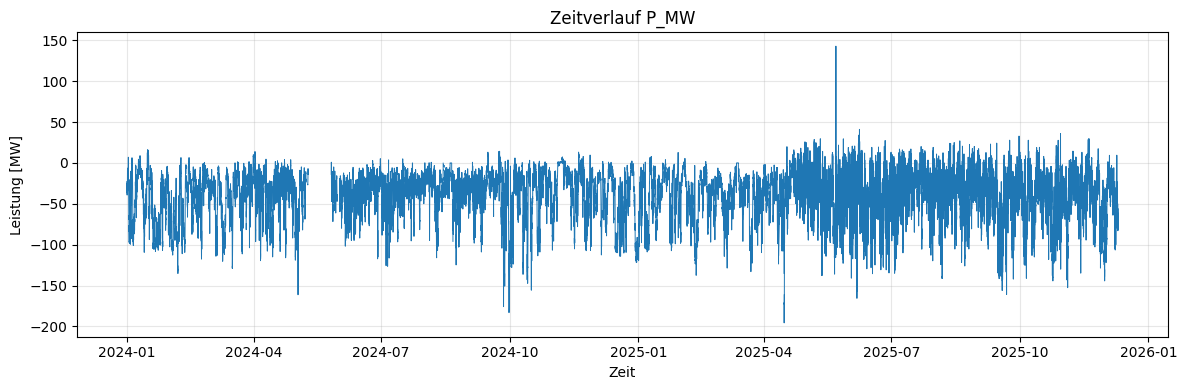

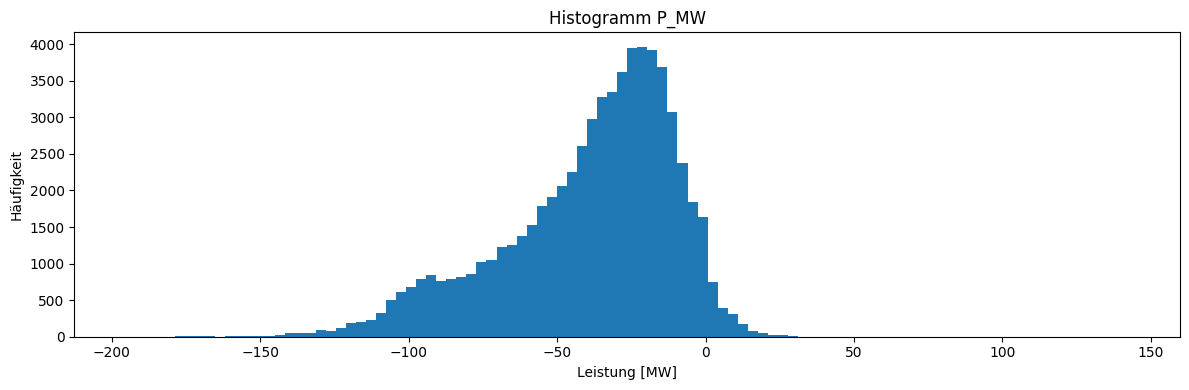


=== Zielvariable – mögliche Ausreißer/Probleme ===
Min: -195.637, Max: 142.891
Quantile 0.1%, 1%, 99%, 99.9%:
0.001   -151.726231
0.010   -119.238984
0.990      7.648999
0.999     21.496507
Name: P_MW, dtype: float64

Anteil negativer Werte: 93.10%
Anteil exakt 0:         0.31%


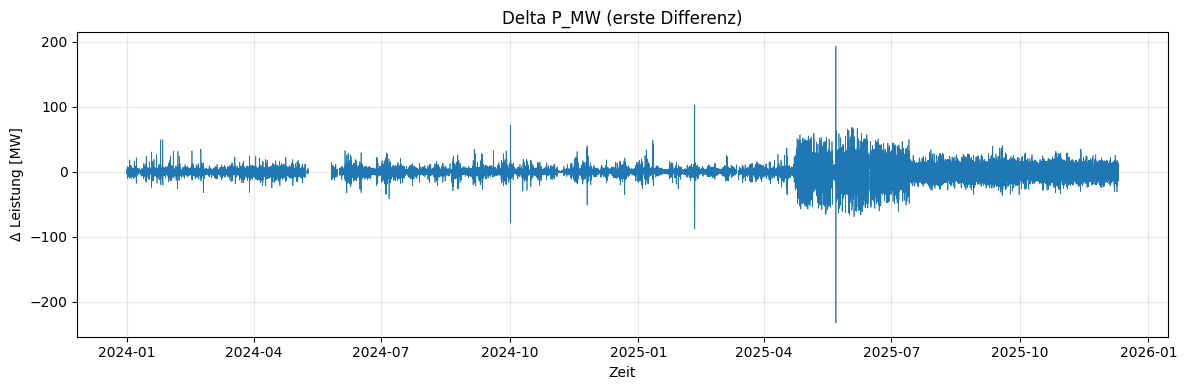


=== Extrem große Änderungen (Delta) ===
count    65676.000000
mean        -0.001335
std          7.862691
min       -232.089647
25%         -2.247251
50%          0.006716
75%          2.338882
max        192.872573
Name: P_diff, dtype: float64

=== Train/Test Zeitraum ===
Train:  2024-01-01 00:00:00 → 2025-07-21 14:45:00
Test:   2025-07-21 15:00:00 → 2025-12-10 12:45:00

=== Vergleich Train/Test Verteilung für P_MW ===


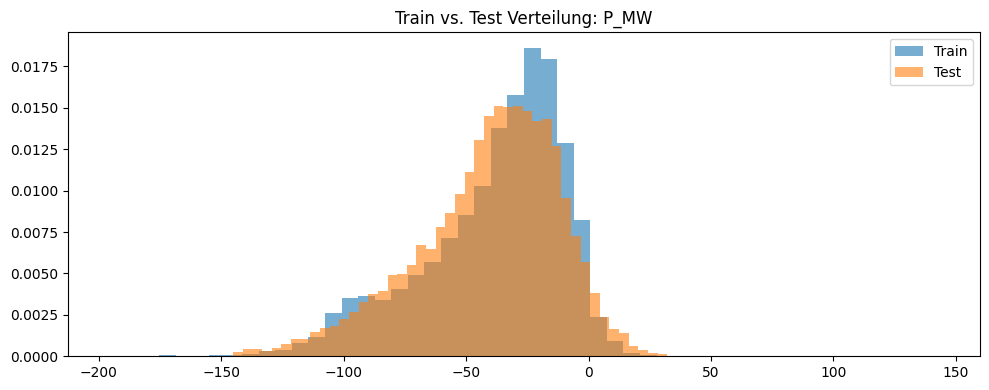


=== Vergleich Train/Test Verteilung für wind_speed_mps ===


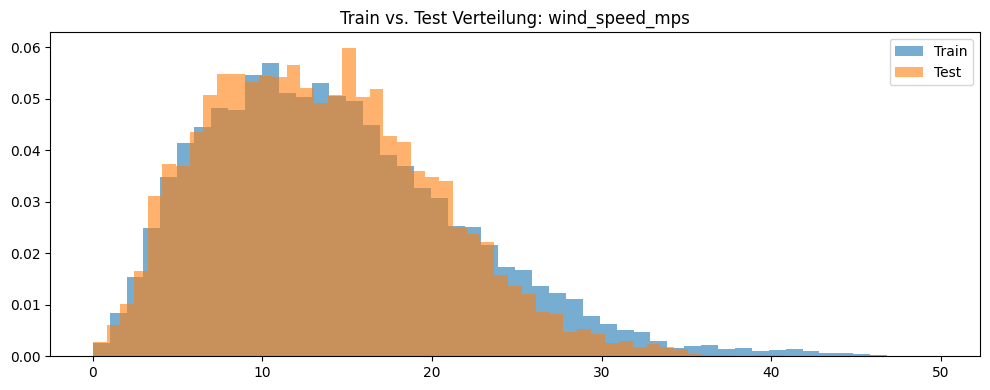


=== Vergleich Train/Test Verteilung für solar_radiation_Wm2 ===


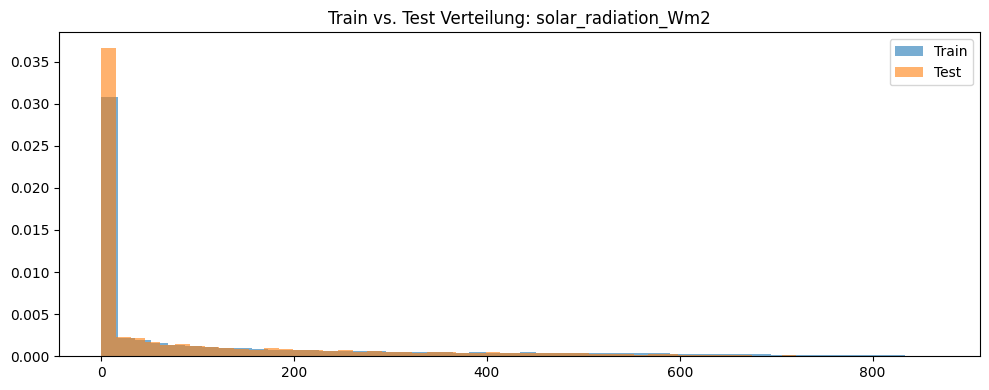


=== Vergleich Train/Test Verteilung für temperature_C ===


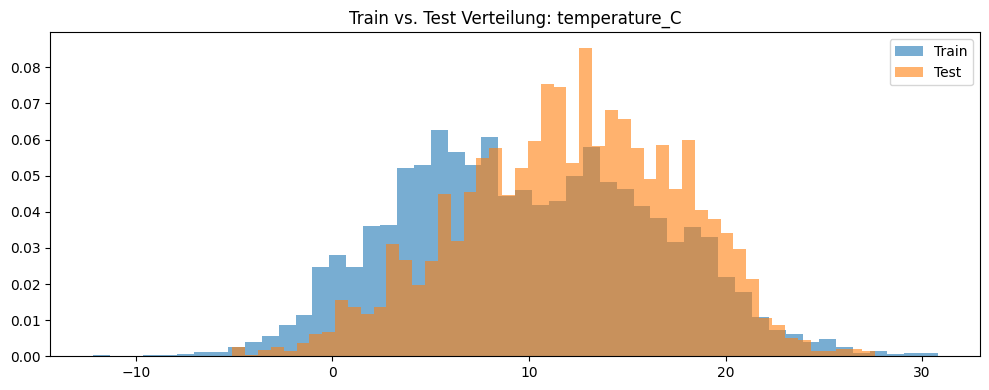


=== Korrelationsmatrix (P_MW & Wetter) ===
                      P_MW  wind_speed_mps  solar_radiation_Wm2  temperature_C
P_MW                 1.000          -0.777               -0.148         -0.045
wind_speed_mps      -0.777           1.000                0.153          0.046
solar_radiation_Wm2 -0.148           0.153                1.000          0.525
temperature_C       -0.045           0.046                0.525          1.000


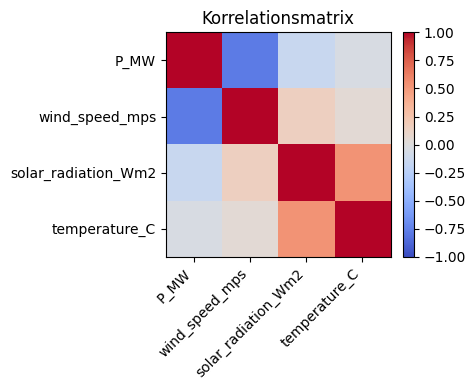

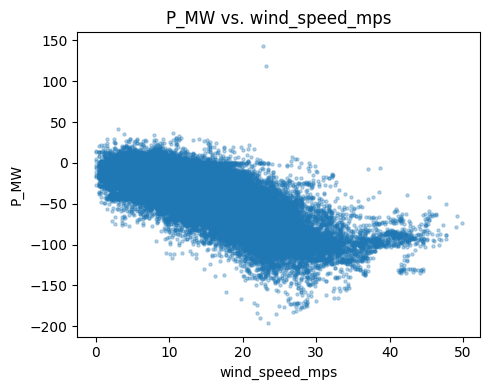

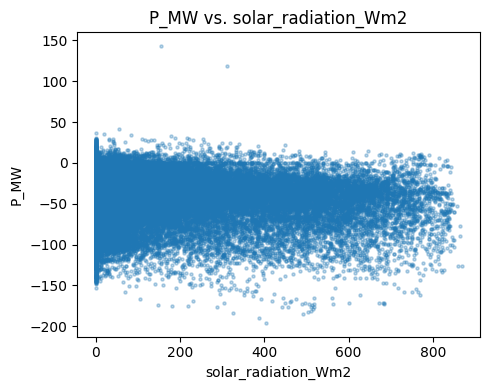

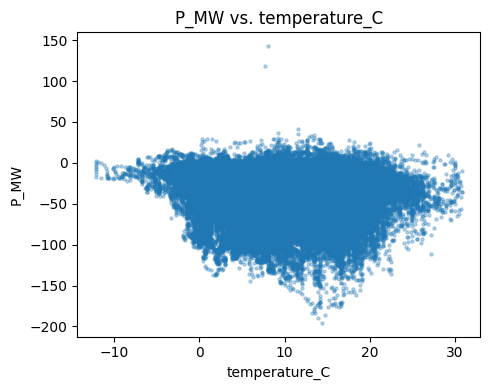

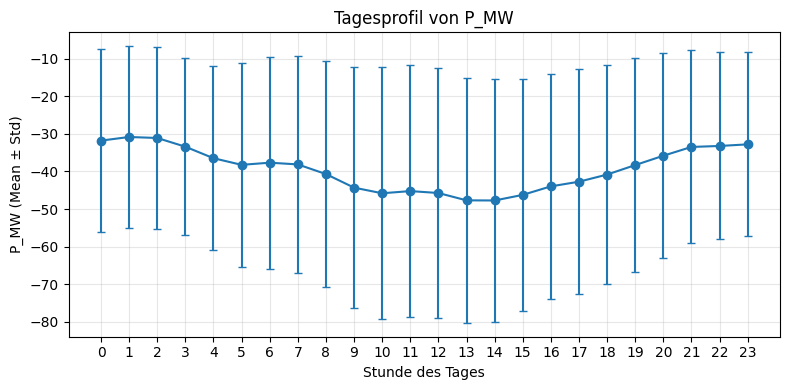

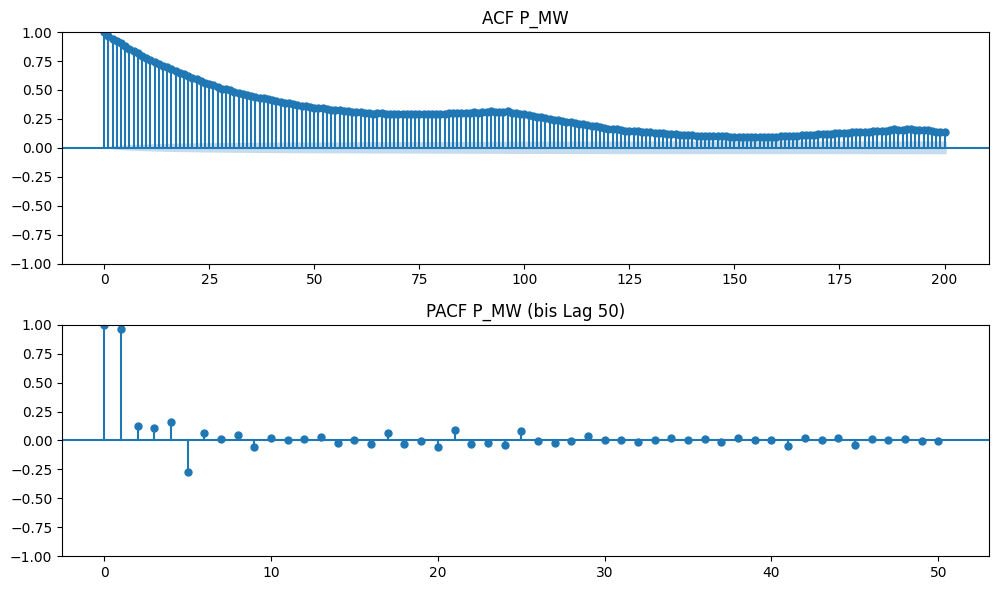


=== Hinweise zur Interpretation (manuell prüfen) ===
- Sind viele Missing Values oder ganze Zeitblöcke leer?
- Sind starke Ausreißer (sehr hohe oder negative P_MW) sichtbar?
- Gibt es deutliche Verteilungsunterschiede zwischen Train und Test?
- Sind Zusammenhänge P_MW ~ Wetter (Wind, Strahlung, Temperatur) erkennbar?
- Ist das Tagesprofil plausibel (z.B. typische Lastverläufe)?
- Deuten ACF/PACF auf starke Trends/Periodizität hin, die Modelle schwer abdecken?


In [11]:
# %% EDA für Zeitreihen-Prognose-Datensatz (P_MW + Wetter)
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.dates import DateFormatter

# Optional: Statsmodels für ACF/PACF, falls installiert
try:
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    HAS_STATSMODELS = True
except ImportError:
    HAS_STATSMODELS = False
    print("Hinweis: statsmodels nicht installiert – ACF/PACF werden übersprungen.")

# ======= USER-INPUT =======
CSV_PATH = r"src/data/raw/timeseries/SHUW_E24_hist.csv"
            
TIMESTAMP_COL = "timestamp"
TARGET_COL = "P_MW"
WEATHER_COLS = ["wind_speed_mps", "solar_radiation_Wm2", "temperature_C"]
# ==========================

# ------------------ 1. Laden & Basischecks ------------------
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"CSV nicht gefunden: {CSV_PATH}")

df = pd.read_csv(CSV_PATH)

if TIMESTAMP_COL not in df.columns:
    raise KeyError(f"Spalte '{TIMESTAMP_COL}' fehlt im Datensatz.")

df[TIMESTAMP_COL] = pd.to_datetime(df[TIMESTAMP_COL])
df = df.sort_values(TIMESTAMP_COL).reset_index(drop=True)

print("=== Kopf des Datensatzes ===")
print(df.head())
print("\n=== Spalten & Datentypen ===")
print(df.dtypes)

print("\n=== Anzahl Zeilen & Zeitraum ===")
print("Zeilen:", len(df))
print("Von:", df[TIMESTAMP_COL].min())
print("Bis:", df[TIMESTAMP_COL].max())

# Sampling-Intervall grob prüfen
dt = df[TIMESTAMP_COL].diff().dropna()
print("\n=== Sampling-Intervall (häufigste Differenz) ===")
print(dt.value_counts().head())

# ------------------ 2. Missing Values & Basisstatistik ------------------
print("\n=== Missing Values pro Spalte (Anteil in %) ===")
na_frac = df.isna().mean() * 100
print(na_frac.sort_values(ascending=False).round(2))

print("\n=== Deskriptive Statistik (numerische Spalten) ===")
print(df.describe().T)

# Verlauf Missing Values über die Zeit (nur Info, kein Muss)
plt.figure(figsize=(10,3))
plt.plot(df[TIMESTAMP_COL], df.isna().sum(axis=1), linewidth=0.7)
plt.title("Anzahl Missing Values pro Zeitstempel")
plt.xlabel("Zeit")
plt.ylabel("Anzahl NaNs")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ------------------ 3. Zielvariable P_MW: Verteilung & Ausreißer ------------------
if TARGET_COL not in df.columns:
    raise KeyError(f"TARGET_COL '{TARGET_COL}' nicht im Datensatz.")

plt.figure(figsize=(12,4))
plt.plot(df[TIMESTAMP_COL], df[TARGET_COL], linewidth=0.7)
plt.title(f"Zeitverlauf {TARGET_COL}")
plt.xlabel("Zeit")
plt.ylabel("Leistung [MW]")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
plt.hist(df[TARGET_COL].dropna(), bins=100)
plt.title(f"Histogramm {TARGET_COL}")
plt.xlabel("Leistung [MW]")
plt.ylabel("Häufigkeit")
plt.tight_layout()
plt.show()

print("\n=== Zielvariable – mögliche Ausreißer/Probleme ===")
print(f"Min: {df[TARGET_COL].min():.3f}, Max: {df[TARGET_COL].max():.3f}")
q = df[TARGET_COL].quantile([0.001, 0.01, 0.99, 0.999])
print("Quantile 0.1%, 1%, 99%, 99.9%:")
print(q)

# Negative Werte / genau 0 / sehr große Werte
neg_share = (df[TARGET_COL] < 0).mean() * 100
zero_share = (df[TARGET_COL] == 0).mean() * 100
print(f"\nAnteil negativer Werte: {neg_share:.2f}%")
print(f"Anteil exakt 0:         {zero_share:.2f}%")

# Sprunghafte Änderungen
df["P_diff"] = df[TARGET_COL].diff()
plt.figure(figsize=(12,4))
plt.plot(df[TIMESTAMP_COL], df["P_diff"], linewidth=0.5)
plt.title(f"Delta {TARGET_COL} (erste Differenz)")
plt.xlabel("Zeit")
plt.ylabel("Δ Leistung [MW]")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n=== Extrem große Änderungen (Delta) ===")
print(df["P_diff"].describe())

# ------------------ 4. Train/Test-Shift grob prüfen ------------------
n = len(df)
split_idx = int(n * (1 - 0.2))  # analog HOLDOUT_FRAC = 0.2
df_train = df.iloc[:split_idx]
df_test = df.iloc[split_idx:]

print("\n=== Train/Test Zeitraum ===")
print("Train: ", df_train[TIMESTAMP_COL].min(), "→", df_train[TIMESTAMP_COL].max())
print("Test:  ", df_test[TIMESTAMP_COL].min(), "→", df_test[TIMESTAMP_COL].max())

def compare_train_test_distribution(series_name):
    if series_name not in df.columns:
        print(f"[Skip] {series_name} nicht im Datensatz.")
        return
    plt.figure(figsize=(10,4))
    plt.hist(df_train[series_name].dropna(), bins=50, alpha=0.6, label="Train", density=True)
    plt.hist(df_test[series_name].dropna(), bins=50, alpha=0.6, label="Test", density=True)
    plt.title(f"Train vs. Test Verteilung: {series_name}")
    plt.legend()
    plt.tight_layout()
    plt.show()

print("\n=== Vergleich Train/Test Verteilung für P_MW ===")
compare_train_test_distribution(TARGET_COL)

for col in WEATHER_COLS:
    print(f"\n=== Vergleich Train/Test Verteilung für {col} ===")
    compare_train_test_distribution(col)

# ------------------ 5. Korrelationen mit Wetter ------------------
num_cols = [c for c in [TARGET_COL] + WEATHER_COLS if c in df.columns]
corr = df[num_cols].corr()

print("\n=== Korrelationsmatrix (P_MW & Wetter) ===")
print(corr.round(3))

plt.figure(figsize=(5,4))
im = plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha="right")
plt.yticks(range(len(num_cols)), num_cols)
plt.title("Korrelationsmatrix")
plt.tight_layout()
plt.show()

# Scatterplots P_MW vs. Wetter
for col in WEATHER_COLS:
    if col not in df.columns:
        continue
    plt.figure(figsize=(5,4))
    plt.scatter(df[col], df[TARGET_COL], s=5, alpha=0.3)
    plt.xlabel(col)
    plt.ylabel(TARGET_COL)
    plt.title(f"{TARGET_COL} vs. {col}")
    plt.tight_layout()
    plt.show()

# ------------------ 6. Saisonalität & Autokorrelation ------------------
# Tagesmuster (auf Stunden gemittelt)
df["hour"] = df[TIMESTAMP_COL].dt.hour
hourly_profile = df.groupby("hour")[TARGET_COL].agg(["mean", "std"])

plt.figure(figsize=(8,4))
plt.errorbar(hourly_profile.index, hourly_profile["mean"],
             yerr=hourly_profile["std"], fmt="-o", capsize=3)
plt.xticks(range(0,24))
plt.xlabel("Stunde des Tages")
plt.ylabel("P_MW (Mean ± Std)")
plt.title("Tagesprofil von P_MW")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Optional: ACF/PACF
if HAS_STATSMODELS:
    # ggf. Serie auf einen kürzeren Zeitraum beschränken (z.B. letztes Jahr),
    # um Plot lesbarer zu halten:
    series = df[TARGET_COL].dropna()
    max_lag = 200  # 200*15min ≈ 50h

    fig, axes = plt.subplots(2, 1, figsize=(10,6))
    plot_acf(series, lags=max_lag, ax=axes[0])
    axes[0].set_title("ACF P_MW")
    plot_pacf(series, lags=50, ax=axes[1])
    axes[1].set_title("PACF P_MW (bis Lag 50)")
    plt.tight_layout()
    plt.show()
else:
    print("\nACF/PACF übersprungen (statsmodels nicht installiert).")

# ------------------ 7. Kurze Interpretation-Hinweise ------------------
print("\n=== Hinweise zur Interpretation (manuell prüfen) ===")
print("- Sind viele Missing Values oder ganze Zeitblöcke leer?")
print("- Sind starke Ausreißer (sehr hohe oder negative P_MW) sichtbar?")
print("- Gibt es deutliche Verteilungsunterschiede zwischen Train und Test?")
print("- Sind Zusammenhänge P_MW ~ Wetter (Wind, Strahlung, Temperatur) erkennbar?")
print("- Ist das Tagesprofil plausibel (z.B. typische Lastverläufe)?")
print("- Deuten ACF/PACF auf starke Trends/Periodizität hin, die Modelle schwer abdecken?")


Lade Daten...
Datengrößen – Gesamt: 64306, Train: 51444, Test: 12862
Vorhersagehorizont: t+1 (15 Minuten)

Baseline (Naive One-Step-Persistence) – Scores:
BL  (Train) MAE:  5.7304
BL  (Train) RMSE: 9.6202
BL  (Train) MAPE: 46,446.11%
BL  (Train) R²:   0.8907
BL  (Test)  MAE:  9.7404
BL  (Test)  RMSE: 12.5984
BL  (Test)  MAPE: 116.13%
BL  (Test)  R²:   0.8169

[RF] Hyperparameter-Suche (GridSearch)...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[RF] Beste Parameter  : {'max_depth': 12, 'min_samples_leaf': 10, 'n_estimators': 400}
[RF] Beste CV-MAE     : 6.1023
[RF] GridSearch+Fit(s): 348.5s
RF TST (t+1) MAE:  9.6028
RF TST (t+1) RMSE: 12.3535
RF TST (t+1) MAPE: 138.99%
RF TST (t+1) R²:   0.8240

[XGB] Hyperparameter-Suche (GridSearch)...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[XGB] Beste Parameter  : {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'subsample': 1.0}
[XGB] Beste CV-MAE     : 6.1455
[XGB] GridSearch+Fit(s): 18.9s
XGB TST (t+1) MAE:  9.4643
XGB TST (t+1) RMSE: 12.2191
XGB TST (t+1) MAPE: 135.44%
XGB TST (t+1) R²:   0.8278


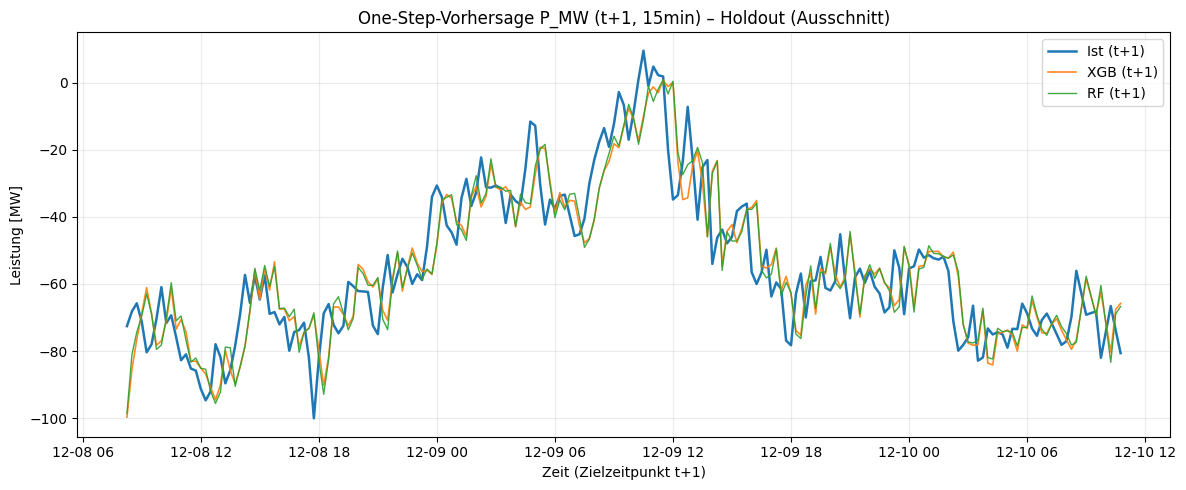


=== Zusammenfassung (Test/Holdout, t+1) ===
Baseline: {'MAE': 9.74040401467693, 'RMSE': 12.59837433807279, 'MAPE': np.float64(116.12662289556643), 'R2': 0.816914150718382}
RF   (best_params={'max_depth': 12, 'min_samples_leaf': 10, 'n_estimators': 400}): {'MAE': 9.60278838132388, 'RMSE': 12.353490366716896, 'MAPE': np.float64(138.99378369683825), 'R2': 0.8239625277712702}
XGB  (best_params={'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'subsample': 1.0}): {'MAE': 9.464323282503093, 'RMSE': 12.219134805111967, 'MAPE': np.float64(135.43634164090622), 'R2': 0.8277708436770632}

=== Trainingszeiten (ca.) ===
RF  (GridSearch + Fit): 348.5s
XGB (GridSearch + Fit): 18.9s

[XGB] Rekursiver Multi-Step-Forecast über 96 Schritte (24h)...

[XGB] 96-Step-Ergebnis (rekursiv):
XGB 96-Step MAE:  16.9471
XGB 96-Step RMSE: 22.4797
XGB 96-Step MAPE: 37.39%
XGB 96-Step R²:   0.2871


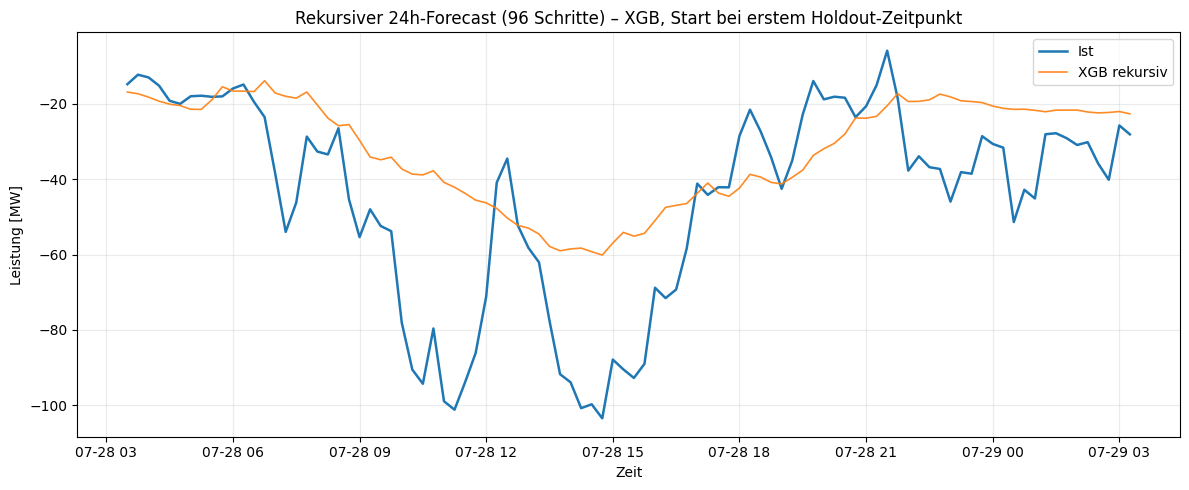

In [12]:
# 96 steps recursive forecast
# -*- coding: utf-8 -*-
"""
One-Step-Forecast (t+1, 15 Minuten) + rekursiver 96-Step-Forecast
Modelle: RandomForest, XGBoost
Mit Hyperparameter-Tuning via GridSearchCV + TimeSeriesSplit

Benötigte Pakete:
    pip install pandas numpy scikit-learn matplotlib xgboost
"""

import os
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# ===================== USER SETTINGS =====================
CSV_PATH = r"src/data/raw/timeseries/SHUW_E24_hist.csv"
TIMESTAMP_COL = "timestamp"
TARGET = "P_MW"

# Wetter-/Exogene Features (müssen in der CSV existieren)
RAW_FEATURES = ["wind_speed_mps", "solar_radiation_Wm2", "temperature_C"]

# Autoregressive Lags (in 15-Min-Schritten)
TARGET_LAGS = [1, 4, 8, 12, 24, 96]

# Fourier-Saisonalität (Tagesperiodik, 24h = 96 * 15min)
FOURIER_K = 3
PERIOD_STEPS = 96

# Rekursiver Forecast-Horizont
HORIZON_STEPS = 96  # 24h = 96 * 15min

# Train/Test-Split
HOLDOUT_FRAC = 0.2
N_SPLITS = 5
RANDOM_STATE = 42
# =========================================================


# =========================================================
# Utility / Evaluation
# =========================================================
def safe_mape(y_true, y_pred, eps=1e-6):
    denom = np.maximum(np.abs(y_true), eps)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100.0


def evaluate(y_true, y_pred, prefix=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mape = safe_mape(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{prefix}MAE:  {mae:,.4f}")
    print(f"{prefix}RMSE: {rmse:,.4f}")
    print(f"{prefix}MAPE: {mape:,.2f}%")
    print(f"{prefix}R²:   {r2:,.4f}")
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape, "R2": r2}


def plot_holdout(ts, y_true, y_rf, y_xgb, title="One-Step-Forecast (t+1, 15min)"):
    """Plot Ausschnitt des Holdouts (z.B. letzte 200 Punkte)."""
    plt.figure(figsize=(12, 5))
    plt.plot(ts, y_true, label="Ist (t+1)", linewidth=1.8)
    plt.plot(ts, y_xgb, label="XGB (t+1)", linewidth=1.2, alpha=0.9)
    plt.plot(ts, y_rf, label="RF (t+1)", linewidth=1.0, alpha=0.9)
    plt.title(title)
    plt.xlabel("Zeit (Zielzeitpunkt t+1)")
    plt.ylabel("Leistung [MW]")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_recursive(ts, y_true, y_pred, title="Rekursiver 96-Step-Forecast (24h)"):
    plt.figure(figsize=(12, 5))
    plt.plot(ts, y_true, label="Ist", linewidth=1.8)
    plt.plot(ts, y_pred, label="XGB rekursiv", linewidth=1.2, alpha=0.9)
    plt.title(title)
    plt.xlabel("Zeit")
    plt.ylabel("Leistung [MW]")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.tight_layout()
    plt.show()


# =========================================================
# Feature Engineering
# =========================================================
def load_data(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"CSV nicht gefunden: {path}")
    df = pd.read_csv(path)
    if TIMESTAMP_COL not in df.columns:
        raise KeyError(f"Spalte '{TIMESTAMP_COL}' fehlt in CSV.")
    if TARGET not in df.columns:
        raise KeyError(f"Zielspalte '{TARGET}' fehlt in CSV.")

    df[TIMESTAMP_COL] = pd.to_datetime(df[TIMESTAMP_COL], utc=False)
    df = df.sort_values(TIMESTAMP_COL).reset_index(drop=True)
    return df


def add_time_features(df):
    ts = df[TIMESTAMP_COL]
    df["hour"] = ts.dt.hour
    df["dayofweek"] = ts.dt.dayofweek
    df["month"] = ts.dt.month

    # zirkuläre Kodierung
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
    df["dow_sin"] = np.sin(2 * np.pi * df["dayofweek"] / 7)
    df["dow_cos"] = np.cos(2 * np.pi * df["dayofweek"] / 7)
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)
    return df


def add_fourier_features(df, period_steps=PERIOD_STEPS, K=FOURIER_K, prefix="day"):
    step_idx = np.arange(len(df), dtype=float) % period_steps
    for k in range(1, K + 1):
        df[f"{prefix}_sin{k}"] = np.sin(2 * np.pi * k * step_idx / period_steps)
        df[f"{prefix}_cos{k}"] = np.cos(2 * np.pi * k * step_idx / period_steps)
    return df


def add_target_lags(df, target_col, lags):
    for l in lags:
        df[f"{target_col}_lag{l}"] = df[target_col].shift(l)
    return df


# =========================================================
# Baum-Modelle mit GridSearch
# =========================================================
def run_tree_model(model_name, base_model, param_grid, X_train, y_train, X_test, y_test):
    print(f"\n[{model_name}] Hyperparameter-Suche (GridSearch)...")
    tscv = TimeSeriesSplit(n_splits=N_SPLITS)

    grid = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        scoring="neg_mean_absolute_error",
        cv=tscv,
        n_jobs=-1,
        verbose=1,
    )
    start_t = time.time()
    grid.fit(X_train, y_train)
    dur = time.time() - start_t

    print(f"[{model_name}] Beste Parameter  : {grid.best_params_}")
    print(f"[{model_name}] Beste CV-MAE     : {-grid.best_score_:.4f}")
    print(f"[{model_name}] GridSearch+Fit(s): {dur:.1f}s")

    best_model = grid.best_estimator_
    y_pred_test = best_model.predict(X_test)
    scores = evaluate(y_test, y_pred_test, prefix=f"{model_name} TST (t+1) ")
    return scores, grid.best_params_, y_pred_test, dur, best_model


# =========================================================
# Rekursiver Forecast mit XGBoost (t+1 ... t+96)
# =========================================================
def recursive_forecast_xgb(
    model,
    df_model,
    feature_cols,
    target_col,
    start_row_idx,
    horizon_steps,
    target_lags,
):
    """
    Rekursiver Forecast:
    - model: trainierter XGBRegressor (t+1)
    - df_model: vollständiger Modell-DataFrame (mit Zeit-/Fourier-Features, aber Lags werden überschrieben)
    - feature_cols: verwendete Feature-Spalten
    - target_col: Name des Ziel-Columns (z.B. "P_MW")
    - start_row_idx: Index der ersten Feature-Zeile im Holdout (entspricht erstem One-Step-Punkt)
    - horizon_steps: Anzahl Vorwärtsschritte (z.B. 96)
    - target_lags: Liste der Lags in Schritten (z.B. [1,4,8,12,24,96])

    Idee:
    - Für Schritt s verwenden wir die exogenen/time-Features aus Zeile (start_row_idx + s),
      überschreiben aber die Lag-Features aus einer History der letzten max_lag Zielwerte.
    - Die History enthält zu Beginn nur echte Werte, danach gemischt echt+vorhergesagt.
    - Für jedes Lag L gilt: target_lagL = history[-L]
    """
    max_lag = max(target_lags)

    # Sicherstellen, dass genug Historie vorliegt
    if start_row_idx - max_lag < 0:
        raise ValueError(
            f"start_row_idx={start_row_idx} ist zu klein für max_lag={max_lag}."
        )

    # Historie: letzte max_lag echte Zielwerte vor dem ersten Label-Zeitpunkt
    # Row k hat Label P[k+1], deshalb nehmen wir P[k-max_lag+1 .. k] als Vergangenheit.
    history = df_model[target_col].iloc[
        start_row_idx - max_lag + 1 : start_row_idx + 1
    ].tolist()
    if len(history) != max_lag:
        raise RuntimeError("History-Länge ungleich max_lag – Indexing-Problem.")

    preds = []
    label_indices = []

    for s in range(horizon_steps):
        row_idx = start_row_idx + s       # Feature-Zeile
        label_idx = row_idx + 1           # dazugehöriger Ziel-Zeitpunkt

        if label_idx >= len(df_model):
            # wir sind am Ende des verfügbaren DataFrames
            break

        # Basis-Row (Zeit, Fourier, exogene Features wie im Datensatz)
        row = df_model.iloc[row_idx].copy()

        # Lag-Features aus aktueller Historie neu setzen
        for L in target_lags:
            row[f"{target_col}_lag{L}"] = history[-L]

        x_vec = row[feature_cols].values.reshape(1, -1)
        y_hat = model.predict(x_vec)[0]

        preds.append(y_hat)
        label_indices.append(label_idx)

        # History updaten: neuen Wert anhängen, nur letzte max_lag behalten
        history.append(y_hat)
        if len(history) > max_lag:
            history = history[-max_lag:]

    return np.array(preds), np.array(label_indices)


# =========================================================
# MAIN
# =========================================================
def main():
    print("Lade Daten...")
    df = load_data(CSV_PATH)

    # ========== Feature Engineering ==========
    df = add_time_features(df)
    df = add_fourier_features(df)
    df = add_target_lags(df, TARGET, TARGET_LAGS)

    # Ziel: t+1 (ein Schritt = 15 Minuten)
    df["target_1"] = df[TARGET].shift(-1)

    # Verfügbare exogene Features prüfen
    present_feats = [c for c in RAW_FEATURES if c in df.columns]
    missing_feats = sorted(set(RAW_FEATURES) - set(present_feats))
    if missing_feats:
        print(f"Warnung: folgende RAW_FEATURES fehlen und werden ignoriert: {missing_feats}")

    time_feats = ["hour_sin", "hour_cos", "dow_sin", "dow_cos", "month_sin", "month_cos"]
    fourier_feats = [f"day_sin{k}" for k in range(1, FOURIER_K + 1)] + \
                    [f"day_cos{k}" for k in range(1, FOURIER_K + 1)]
    lag_feats = [f"{TARGET}_lag{l}" for l in TARGET_LAGS]

    feature_cols = present_feats + time_feats + fourier_feats + lag_feats

    # NaNs entfernen (wegen Shifts)
    df_model = df.dropna(subset=feature_cols + ["target_1"]).copy()

    X = df_model[feature_cols]
    y = df_model["target_1"]

    n = len(df_model)
    split_idx = int((1.0 - HOLDOUT_FRAC) * n)

    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    print(f"Datengrößen – Gesamt: {n}, Train: {len(X_train)}, Test: {len(X_test)}")
    print("Vorhersagehorizont: t+1 (15 Minuten)")

    # ========== Baseline (Naive Persistence: y_hat_{t+1} = y_t) ==========
    print("\nBaseline (Naive One-Step-Persistence) – Scores:")
    # Baseline nutzt einfach lag1 als Vorhersage
    y_baseline_train = df_model[f"{TARGET}_lag1"].iloc[:split_idx].values
    y_baseline_test = df_model[f"{TARGET}_lag1"].iloc[split_idx:].values

    _ = evaluate(y_train.values, y_baseline_train, prefix="BL  (Train) ")
    bl_scores = evaluate(y_test.values, y_baseline_test, prefix="BL  (Test)  ")

    # ========== Random Forest ==========
    rf_base = RandomForestRegressor(
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )
    rf_param_grid = {
        "n_estimators": [200, 400],
        "max_depth": [None, 12],
        "min_samples_leaf": [1, 10],
    }
    rf_scores, rf_best_params, rf_pred, rf_time, rf_model = run_tree_model(
        "RF", rf_base, rf_param_grid, X_train, y_train, X_test, y_test
    )

    # ========== XGBoost ==========
    xgb_base = XGBRegressor(
        objective="reg:squarederror",
        random_state=RANDOM_STATE,
        n_estimators=400,
        tree_method="hist",
        eval_metric="rmse",
    )
    xgb_param_grid = {
        "max_depth": [4, 8],
        "learning_rate": [0.05, 0.1],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
    }
    xgb_scores, xgb_best_params, xgb_pred, xgb_time, xgb_model = run_tree_model(
        "XGB", xgb_base, xgb_param_grid, X_train, y_train, X_test, y_test
    )

    # ========== Plot – One-Step Holdout-Ausschnitt ==========
    n_plot = 200
    if len(y_test) <= n_plot:
        start_idx_plot = 0
    else:
        start_idx_plot = len(y_test) - n_plot

    ts_holdout = df_model[TIMESTAMP_COL].iloc[split_idx:]
    plot_holdout(
        ts_holdout.iloc[start_idx_plot:],
        y_test.values[start_idx_plot:],
        rf_pred[start_idx_plot:],
        xgb_pred[start_idx_plot:],
        title=f"One-Step-Vorhersage {TARGET} (t+1, 15min) – Holdout (Ausschnitt)"
    )

    print("\n=== Zusammenfassung (Test/Holdout, t+1) ===")
    print("Baseline:", bl_scores)
    print(f"RF   (best_params={rf_best_params}):", rf_scores)
    print(f"XGB  (best_params={xgb_best_params}):", xgb_scores)

    print("\n=== Trainingszeiten (ca.) ===")
    print(f"RF  (GridSearch + Fit): {rf_time:.1f}s")
    print(f"XGB (GridSearch + Fit): {xgb_time:.1f}s")

    # ========== Rekursiver 96-Step-Forecast mit XGB ==========
    print(f"\n[XGB] Rekursiver Multi-Step-Forecast über {HORIZON_STEPS} Schritte (24h)...")

    # Start des rekursiven Forecasts: erste Zeile im Holdout (wie bei One-Step)
    start_row_idx = split_idx

    horizon = min(
        HORIZON_STEPS,
        len(df_model) - (start_row_idx + 1)  # damit label_idx < len(df_model)
    )

    y_xgb_multi, label_indices = recursive_forecast_xgb(
        model=xgb_model,
        df_model=df_model,
        feature_cols=feature_cols,
        target_col=TARGET,
        start_row_idx=start_row_idx,
        horizon_steps=horizon,
        target_lags=TARGET_LAGS,
    )

    y_true_multi = df_model[TARGET].iloc[label_indices].values
    ts_multi = df_model[TIMESTAMP_COL].iloc[label_indices]

    print("\n[XGB] 96-Step-Ergebnis (rekursiv):")
    multi_scores = evaluate(y_true_multi, y_xgb_multi, prefix="XGB 96-Step ")

    # Plot der rekursiven 24h-Vorhersage
    plot_recursive(
        ts_multi,
        y_true_multi,
        y_xgb_multi,
        title=f"Rekursiver 24h-Forecast (96 Schritte) – XGB, Start bei erstem Holdout-Zeitpunkt"
    )


if __name__ == "__main__":
    main()


Lade Daten...
Datengrößen – Gesamt: 64306, Train: 51444, Test: 12862
Vorhersagehorizont: t+1 (15 Minuten)

Baseline (Naive One-Step-Persistence) – Scores:
BL  (Train) MAE:  5.7304
BL  (Train) RMSE: 9.6202
BL  (Train) MAPE: 46,446.11%
BL  (Train) R²:   0.8907
BL  (Test)  MAE:  9.7404
BL  (Test)  RMSE: 12.5984
BL  (Test)  MAPE: 116.13%
BL  (Test)  R²:   0.8169

[RF] Hyperparameter-Suche (GridSearch)...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[RF] Beste Parameter  : {'max_depth': 12, 'min_samples_leaf': 10, 'n_estimators': 400}
[RF] Beste CV-MAE     : 6.1023
[RF] GridSearch+Fit(s): 366.3s
RF TST (t+1) MAE:  9.6028
RF TST (t+1) RMSE: 12.3535
RF TST (t+1) MAPE: 138.99%
RF TST (t+1) R²:   0.8240

[XGB] Hyperparameter-Suche (GridSearch)...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[XGB] Beste Parameter  : {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'subsample': 1.0}
[XGB] Beste CV-MAE     : 6.1455
[XGB] GridSearch+Fit(s): 23.2s
XGB TST (t+1) MAE:  9.4643
XGB TST (t+1) RMSE: 12.2191
XGB TST (t+1) MAPE: 135.44%
XGB TST (t+1) R²:   0.8278


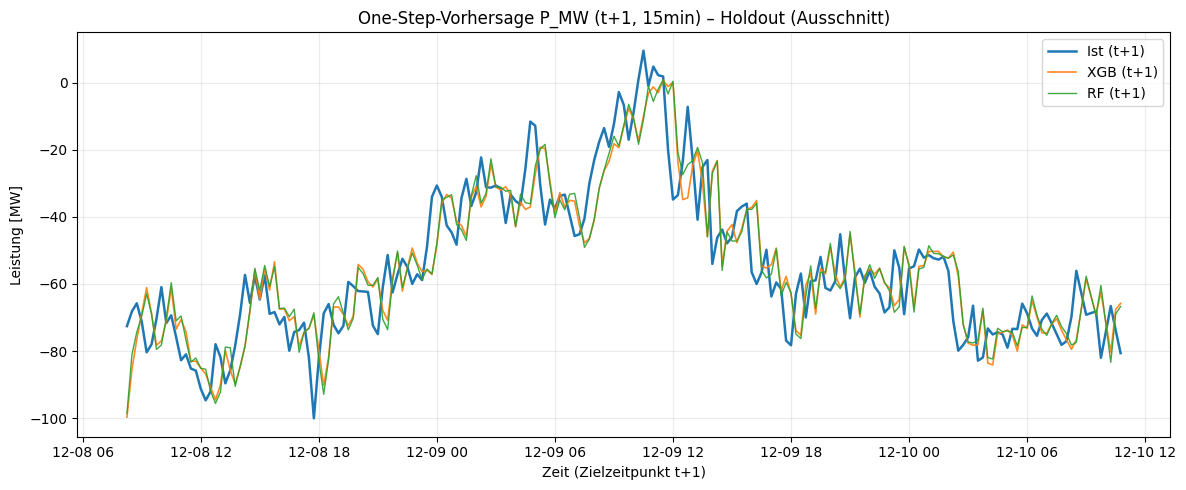


=== Zusammenfassung (Test/Holdout, t+1) ===
Baseline: {'MAE': 9.74040401467693, 'RMSE': 12.59837433807279, 'MAPE': np.float64(116.12662289556643), 'R2': 0.816914150718382}
RF   (best_params={'max_depth': 12, 'min_samples_leaf': 10, 'n_estimators': 400}): {'MAE': 9.60278838132388, 'RMSE': 12.353490366716898, 'MAPE': np.float64(138.99378369683825), 'R2': 0.8239625277712702}
XGB  (best_params={'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'subsample': 1.0}): {'MAE': 9.464323282503093, 'RMSE': 12.219134805111967, 'MAPE': np.float64(135.43634164090622), 'R2': 0.8277708436770632}

=== Trainingszeiten (ca.) ===
RF  (GridSearch + Fit): 366.3s
XGB (GridSearch + Fit): 23.2s

[XGB] Rekursiver Multi-Step-Forecast über 96 Schritte (24h)...

[Baseline] 96-Step-Ergebnis (24h-Naive: y[t-96])
BL 96-Step MAE:  24.6120
BL 96-Step RMSE: 32.8731
BL 96-Step MAPE: 57.45%
BL 96-Step R²:   -0.5246

[XGB] 96-Step-Ergebnis (rekursiv):
XGB 96-Step MAE:  16.9471
XGB 96-Step RMSE: 22.4797
XGB 96-

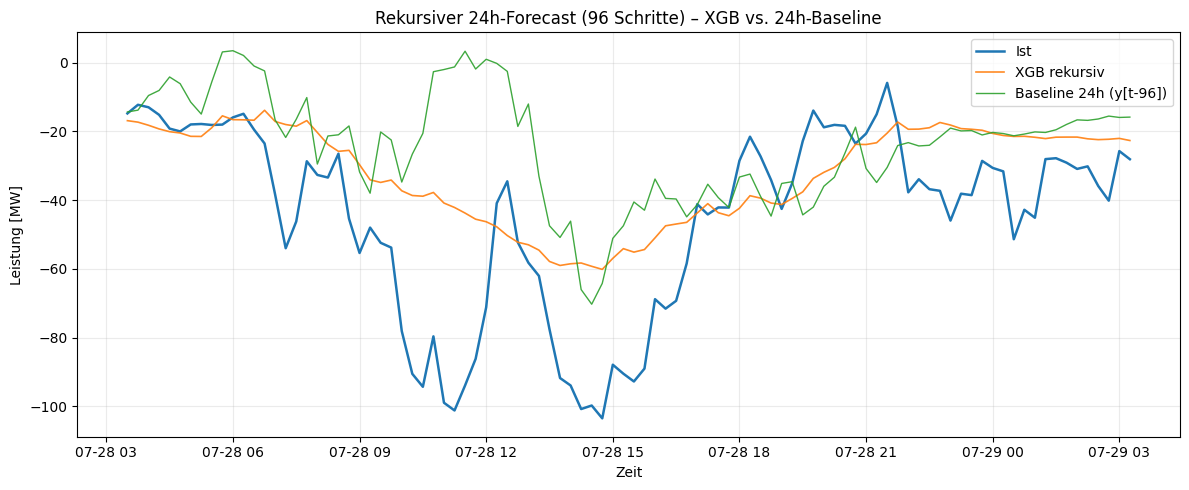

In [13]:
# -*- coding: utf-8 -*-
"""
One-Step-Forecast (t+1, 15 Minuten) + rekursiver 96-Step-Forecast
Modelle: RandomForest, XGBoost
Mit Hyperparameter-Tuning via GridSearchCV + TimeSeriesSplit

Benötigte Pakete:
    pip install pandas numpy scikit-learn matplotlib xgboost
"""

import os
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# ===================== USER SETTINGS =====================
CSV_PATH = r"src/data/raw/timeseries/SHUW_E24_hist.csv"
TIMESTAMP_COL = "timestamp"
TARGET = "P_MW"

# Wetter-/Exogene Features (müssen in der CSV existieren)
RAW_FEATURES = ["wind_speed_mps", "solar_radiation_Wm2", "temperature_C"]

# Autoregressive Lags (in 15-Min-Schritten)
TARGET_LAGS = [1, 4, 8, 12, 24, 96]

# Fourier-Saisonalität (Tagesperiodik, 24h = 96 * 15min)
FOURIER_K = 3
PERIOD_STEPS = 96

# Rekursiver Forecast-Horizont
HORIZON_STEPS = 96  # 24h = 96 * 15min

# Train/Test-Split
HOLDOUT_FRAC = 0.2
N_SPLITS = 5
RANDOM_STATE = 42
# =========================================================


# =========================================================
# Utility / Evaluation
# =========================================================
def safe_mape(y_true, y_pred, eps=1e-6):
    denom = np.maximum(np.abs(y_true), eps)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100.0


def evaluate(y_true, y_pred, prefix=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mape = safe_mape(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{prefix}MAE:  {mae:,.4f}")
    print(f"{prefix}RMSE: {rmse:,.4f}")
    print(f"{prefix}MAPE: {mape:,.2f}%")
    print(f"{prefix}R²:   {r2:,.4f}")
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape, "R2": r2}


def plot_holdout(ts, y_true, y_rf, y_xgb, title="One-Step-Forecast (t+1, 15min)"):
    """Plot Ausschnitt des Holdouts (z.B. letzte 200 Punkte)."""
    plt.figure(figsize=(12, 5))
    plt.plot(ts, y_true, label="Ist (t+1)", linewidth=1.8)
    plt.plot(ts, y_xgb, label="XGB (t+1)", linewidth=1.2, alpha=0.9)
    plt.plot(ts, y_rf, label="RF (t+1)", linewidth=1.0, alpha=0.9)
    plt.title(title)
    plt.xlabel("Zeit (Zielzeitpunkt t+1)")
    plt.ylabel("Leistung [MW]")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_recursive(ts, y_true, y_pred_xgb, y_pred_bl, title="Rekursiver 96-Step-Forecast (24h)"):
    plt.figure(figsize=(12, 5))
    plt.plot(ts, y_true, label="Ist", linewidth=1.8)
    plt.plot(ts, y_pred_xgb, label="XGB rekursiv", linewidth=1.2, alpha=0.9)
    plt.plot(ts, y_pred_bl, label="Baseline 24h (y[t-96])", linewidth=1.0, alpha=0.9)
    plt.title(title)
    plt.xlabel("Zeit")
    plt.ylabel("Leistung [MW]")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.tight_layout()
    plt.show()


# =========================================================
# Feature Engineering
# =========================================================
def load_data(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"CSV nicht gefunden: {path}")
    df = pd.read_csv(path)
    if TIMESTAMP_COL not in df.columns:
        raise KeyError(f"Spalte '{TIMESTAMP_COL}' fehlt in CSV.")
    if TARGET not in df.columns:
        raise KeyError(f"Zielspalte '{TARGET}' fehlt in CSV.")

    df[TIMESTAMP_COL] = pd.to_datetime(df[TIMESTAMP_COL], utc=False)
    df = df.sort_values(TIMESTAMP_COL).reset_index(drop=True)
    return df


def add_time_features(df):
    ts = df[TIMESTAMP_COL]
    df["hour"] = ts.dt.hour
    df["dayofweek"] = ts.dt.dayofweek
    df["month"] = ts.dt.month

    # zirkuläre Kodierung
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
    df["dow_sin"] = np.sin(2 * np.pi * df["dayofweek"] / 7)
    df["dow_cos"] = np.cos(2 * np.pi * df["dayofweek"] / 7)
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)
    return df


def add_fourier_features(df, period_steps=PERIOD_STEPS, K=FOURIER_K, prefix="day"):
    step_idx = np.arange(len(df), dtype=float) % period_steps
    for k in range(1, K + 1):
        df[f"{prefix}_sin{k}"] = np.sin(2 * np.pi * k * step_idx / period_steps)
        df[f"{prefix}_cos{k}"] = np.cos(2 * np.pi * k * step_idx / period_steps)
    return df


def add_target_lags(df, target_col, lags):
    for l in lags:
        df[f"{target_col}_lag{l}"] = df[target_col].shift(l)
    return df


# =========================================================
# Baum-Modelle mit GridSearch
# =========================================================
def run_tree_model(model_name, base_model, param_grid, X_train, y_train, X_test, y_test):
    print(f"\n[{model_name}] Hyperparameter-Suche (GridSearch)...")
    tscv = TimeSeriesSplit(n_splits=N_SPLITS)

    grid = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        scoring="neg_mean_absolute_error",
        cv=tscv,
        n_jobs=-1,
        verbose=1,
    )
    start_t = time.time()
    grid.fit(X_train, y_train)
    dur = time.time() - start_t

    print(f"[{model_name}] Beste Parameter  : {grid.best_params_}")
    print(f"[{model_name}] Beste CV-MAE     : {-grid.best_score_:.4f}")
    print(f"[{model_name}] GridSearch+Fit(s): {dur:.1f}s")

    best_model = grid.best_estimator_
    y_pred_test = best_model.predict(X_test)
    scores = evaluate(y_test, y_pred_test, prefix=f"{model_name} TST (t+1) ")
    return scores, grid.best_params_, y_pred_test, dur, best_model


# =========================================================
# Rekursiver Forecast mit XGBoost (t+1 ... t+96)
# =========================================================
def recursive_forecast_xgb(
    model,
    df_model,
    feature_cols,
    target_col,
    start_row_idx,
    horizon_steps,
    target_lags,
):
    """
    Rekursiver Forecast:
    - model: trainierter XGBRegressor (t+1)
    - df_model: vollständiger Modell-DataFrame (mit Zeit-/Fourier-Features, aber Lags werden überschrieben)
    - feature_cols: verwendete Feature-Spalten
    - target_col: Name des Ziel-Columns (z.B. "P_MW")
    - start_row_idx: Index der ersten Feature-Zeile im Holdout (entspricht erstem One-Step-Punkt)
    - horizon_steps: Anzahl Vorwärtsschritte (z.B. 96)
    - target_lags: Liste der Lags in Schritten (z.B. [1,4,8,12,24,96])

    Für jedes Lag L gilt: target_lagL = history[-L], wobei history die letzten max_lag Werte enthält.
    """
    max_lag = max(target_lags)

    if start_row_idx - max_lag < 0:
        raise ValueError(
            f"start_row_idx={start_row_idx} ist zu klein für max_lag={max_lag}."
        )

    # Historie: letzte max_lag echte Zielwerte vor dem ersten Label-Zeitpunkt
    history = df_model[target_col].iloc[
        start_row_idx - max_lag + 1 : start_row_idx + 1
    ].tolist()
    if len(history) != max_lag:
        raise RuntimeError("History-Länge ungleich max_lag – Indexing-Problem.")

    preds = []
    label_indices = []

    for s in range(horizon_steps):
        row_idx = start_row_idx + s       # Feature-Zeile
        label_idx = row_idx + 1           # dazugehöriger Ziel-Zeitpunkt

        if label_idx >= len(df_model):
            break

        row = df_model.iloc[row_idx].copy()

        # Lag-Features aus aktueller Historie neu setzen
        for L in target_lags:
            row[f"{target_col}_lag{L}"] = history[-L]

        x_vec = row[feature_cols].values.reshape(1, -1)
        y_hat = model.predict(x_vec)[0]

        preds.append(y_hat)
        label_indices.append(label_idx)

        # History aktualisieren
        history.append(y_hat)
        if len(history) > max_lag:
            history = history[-max_lag:]

    return np.array(preds), np.array(label_indices)


# =========================================================
# MAIN
# =========================================================
def main():
    print("Lade Daten...")
    df = load_data(CSV_PATH)

    # ========== Feature Engineering ==========
    df = add_time_features(df)
    df = add_fourier_features(df)
    df = add_target_lags(df, TARGET, TARGET_LAGS)

    # Ziel: t+1 (ein Schritt = 15 Minuten)
    df["target_1"] = df[TARGET].shift(-1)

    # Verfügbare exogene Features prüfen
    present_feats = [c for c in RAW_FEATURES if c in df.columns]
    missing_feats = sorted(set(RAW_FEATURES) - set(present_feats))
    if missing_feats:
        print(f"Warnung: folgende RAW_FEATURES fehlen und werden ignoriert: {missing_feats}")

    time_feats = ["hour_sin", "hour_cos", "dow_sin", "dow_cos", "month_sin", "month_cos"]
    fourier_feats = [f"day_sin{k}" for k in range(1, FOURIER_K + 1)] + \
                    [f"day_cos{k}" for k in range(1, FOURIER_K + 1)]
    lag_feats = [f"{TARGET}_lag{l}" for l in TARGET_LAGS]

    feature_cols = present_feats + time_feats + fourier_feats + lag_feats

    # NaNs entfernen (wegen Shifts)
    df_model = df.dropna(subset=feature_cols + ["target_1"]).copy()

    X = df_model[feature_cols]
    y = df_model["target_1"]

    n = len(df_model)
    split_idx = int((1.0 - HOLDOUT_FRAC) * n)

    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    print(f"Datengrößen – Gesamt: {n}, Train: {len(X_train)}, Test: {len(X_test)}")
    print("Vorhersagehorizont: t+1 (15 Minuten)")

    # ========== Baseline (Naive Persistence: y_hat_{t+1} = y_t) ==========
    print("\nBaseline (Naive One-Step-Persistence) – Scores:")
    y_baseline_train = df_model[f"{TARGET}_lag1"].iloc[:split_idx].values
    y_baseline_test = df_model[f"{TARGET}_lag1"].iloc[split_idx:].values

    _ = evaluate(y_train.values, y_baseline_train, prefix="BL  (Train) ")
    bl_scores = evaluate(y_test.values, y_baseline_test, prefix="BL  (Test)  ")

    # ========== Random Forest ==========
    rf_base = RandomForestRegressor(
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )
    rf_param_grid = {
        "n_estimators": [200, 400],
        "max_depth": [None, 12],
        "min_samples_leaf": [1, 10],
    }
    rf_scores, rf_best_params, rf_pred, rf_time, rf_model = run_tree_model(
        "RF", rf_base, rf_param_grid, X_train, y_train, X_test, y_test
    )

    # ========== XGBoost ==========
    xgb_base = XGBRegressor(
        objective="reg:squarederror",
        random_state=RANDOM_STATE,
        n_estimators=400,
        tree_method="hist",
        eval_metric="rmse",
    )
    xgb_param_grid = {
        "max_depth": [4, 8],
        "learning_rate": [0.05, 0.1],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
    }
    xgb_scores, xgb_best_params, xgb_pred, xgb_time, xgb_model = run_tree_model(
        "XGB", xgb_base, xgb_param_grid, X_train, y_train, X_test, y_test
    )

    # ========== Plot – One-Step Holdout-Ausschnitt ==========
    n_plot = 200
    if len(y_test) <= n_plot:
        start_idx_plot = 0
    else:
        start_idx_plot = len(y_test) - n_plot

    ts_holdout = df_model[TIMESTAMP_COL].iloc[split_idx:]
    plot_holdout(
        ts_holdout.iloc[start_idx_plot:],
        y_test.values[start_idx_plot:],
        rf_pred[start_idx_plot:],
        xgb_pred[start_idx_plot:],
        title=f"One-Step-Vorhersage {TARGET} (t+1, 15min) – Holdout (Ausschnitt)"
    )

    print("\n=== Zusammenfassung (Test/Holdout, t+1) ===")
    print("Baseline:", bl_scores)
    print(f"RF   (best_params={rf_best_params}):", rf_scores)
    print(f"XGB  (best_params={xgb_best_params}):", xgb_scores)

    print("\n=== Trainingszeiten (ca.) ===")
    print(f"RF  (GridSearch + Fit): {rf_time:.1f}s")
    print(f"XGB (GridSearch + Fit): {xgb_time:.1f}s")

    # ========== Rekursiver 96-Step-Forecast mit XGB ==========
    print(f"\n[XGB] Rekursiver Multi-Step-Forecast über {HORIZON_STEPS} Schritte (24h)...")

    start_row_idx = split_idx

    horizon = min(
        HORIZON_STEPS,
        len(df_model) - (start_row_idx + 1)
    )

    y_xgb_multi, label_indices = recursive_forecast_xgb(
        model=xgb_model,
        df_model=df_model,
        feature_cols=feature_cols,
        target_col=TARGET,
        start_row_idx=start_row_idx,
        horizon_steps=horizon,
        target_lags=TARGET_LAGS,
    )

    # True-Werte für die Zielzeitpunkte
    y_true_multi = df_model[TARGET].iloc[label_indices].values
    ts_multi = df_model[TIMESTAMP_COL].iloc[label_indices]

    # ===== 24h-Baseline für Multi-Step: y_hat(t) = y(t-96) =====
    # (setzt voraus, dass label_indices >= PERIOD_STEPS, was bei deinem Split gegeben ist)
    target_arr = df_model[TARGET].values
    baseline_indices = label_indices - PERIOD_STEPS
    if (baseline_indices < 0).any():
        raise RuntimeError("Für einige Zielzeitpunkte existiert keine 24h-Historie (t-96).")

    y_bl_multi = target_arr[baseline_indices]

    print("\n[Baseline] 96-Step-Ergebnis (24h-Naive: y[t-96])")
    bl_multi_scores = evaluate(y_true_multi, y_bl_multi, prefix="BL 96-Step ")

    print("\n[XGB] 96-Step-Ergebnis (rekursiv):")
    multi_scores = evaluate(y_true_multi, y_xgb_multi, prefix="XGB 96-Step ")

    # Plot der rekursiven 24h-Vorhersage vs. Baseline
    plot_recursive(
        ts_multi,
        y_true_multi,
        y_xgb_multi,
        y_bl_multi,
        title=f"Rekursiver 24h-Forecast (96 Schritte) – XGB vs. 24h-Baseline"
    )


if __name__ == "__main__":
    main()


Lade Daten...

=== Cleaning: Ausgangslage ===
Zeilen vor Cleaning: 68116
P_MW: min=-195.637, max=142.891
Quantile vor Cleaning (0.1%, 1%, 99%, 99.9%):
0.001   -151.726231
0.010   -119.238984
0.990      7.648999
0.999     21.496507
Name: P_MW, dtype: float64

=== Cleaning: nachher ===
Zeilen nach Cleaning : 65745 (−0 entfernt)
P_MW (clean): min=-151.731, max=21.497
Quantile nach Cleaning (0.1%, 1%, 99%, 99.9%):
0.001   -151.521295
0.010   -119.240285
0.990      7.649094
0.999     21.465923
Name: P_MW, dtype: float64
Entfernte extreme Sprünge |ΔP| > 150 MW: 0
Datengrößen – Gesamt: 65648, Train: 52518, Test: 13130
Vorhersagehorizont: t+1 (15 Minuten)

Baseline (Naive One-Step-Persistence) – Scores:
BL  (Train) MAE:  5.7365
BL  (Train) RMSE: 9.4983
BL  (Train) MAPE: 45,496.92%
BL  (Train) R²:   0.8927
BL  (Test)  MAE:  9.7175
BL  (Test)  RMSE: 12.5840
BL  (Test)  MAPE: 114.99%
BL  (Test)  R²:   0.8162

[RF] Hyperparameter-Suche (GridSearch)...
Fitting 5 folds for each of 8 candidates, tota

/Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[RF] Beste Parameter  : {'max_depth': 12, 'min_samples_leaf': 10, 'n_estimators': 400}
[RF] Beste CV-MAE     : 6.1190
[RF] GridSearch+Fit(s): 403.5s
RF TST (t+1) MAE:  9.5997
RF TST (t+1) RMSE: 12.3554
RF TST (t+1) MAPE: 137.52%
RF TST (t+1) R²:   0.8229

[XGB] Hyperparameter-Suche (GridSearch)...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[XGB] Beste Parameter  : {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'subsample': 1.0}
[XGB] Beste CV-MAE     : 6.2249
[XGB] GridSearch+Fit(s): 21.9s
XGB TST (t+1) MAE:  9.4918
XGB TST (t+1) RMSE: 12.2481
XGB TST (t+1) MAPE: 133.86%
XGB TST (t+1) R²:   0.8259


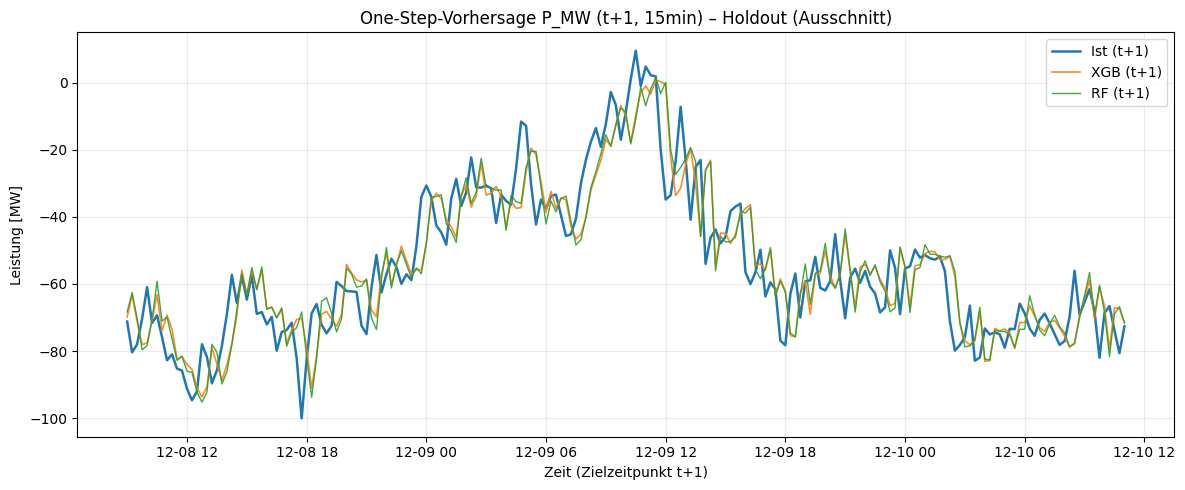


=== Zusammenfassung (Test/Holdout, t+1) ===
Baseline: {'MAE': 9.717466065100894, 'RMSE': 12.584017864622911, 'MAPE': np.float64(114.98900327800123), 'R2': 0.8162399879432058}
RF   (best_params={'max_depth': 12, 'min_samples_leaf': 10, 'n_estimators': 400}): {'MAE': 9.599707546639586, 'RMSE': 12.35544397142444, 'MAPE': np.float64(137.51982231540524), 'R2': 0.822854930262009}
XGB  (best_params={'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'subsample': 1.0}): {'MAE': 9.491792280952303, 'RMSE': 12.248067344148572, 'MAPE': np.float64(133.85701797425259), 'R2': 0.8259205565339018}

=== Trainingszeiten (ca.) ===
RF  (GridSearch + Fit): 403.5s
XGB (GridSearch + Fit): 21.9s

[XGB] Rekursiver Multi-Step-Forecast über 96 Schritte (24h)...

[XGB] 96-Step-Ergebnis (rekursiv):
XGB 96-Step MAE:  7.7516
XGB 96-Step RMSE: 9.6148
XGB 96-Step MAPE: 103.88%
XGB 96-Step R²:   0.5308


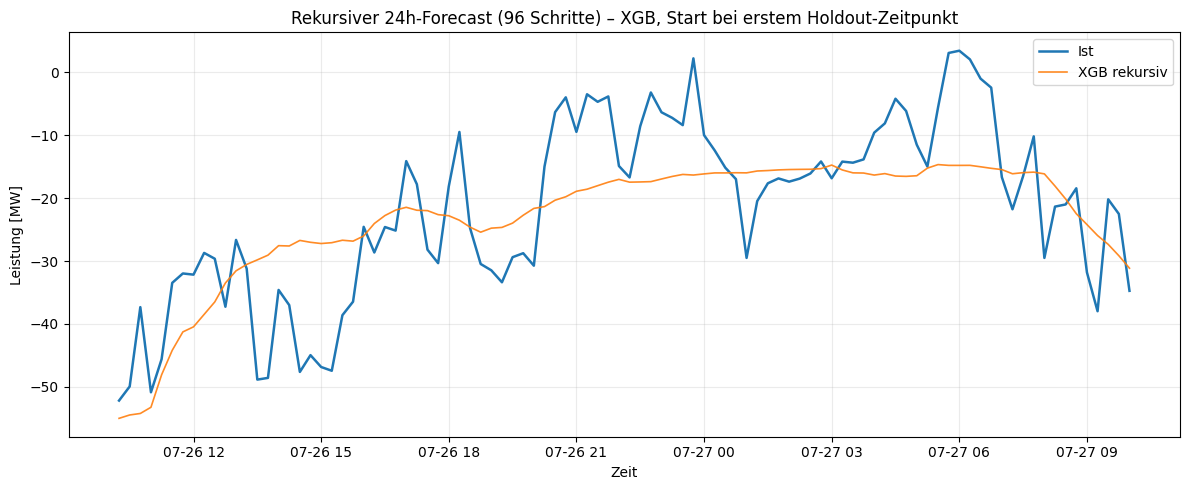

In [15]:
# 96 steps recursive forecast mit cleaning procedure
# -*- coding: utf-8 -*-
"""
One-Step-Forecast (t+1, 15 Minuten) + rekursiver 96-Step-Forecast
Modelle: RandomForest, XGBoost
Mit Hyperparameter-Tuning via GridSearchCV + TimeSeriesSplit

Benötigte Pakete:
    pip install pandas numpy scikit-learn matplotlib xgboost
"""

import os
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# ===================== USER SETTINGS =====================
CSV_PATH = r"src/data/raw/timeseries/SHUW_E24_hist.csv"
TIMESTAMP_COL = "timestamp"
TARGET = "P_MW"

# Wetter-/Exogene Features (müssen in der CSV existieren)
RAW_FEATURES = ["wind_speed_mps", "solar_radiation_Wm2", "temperature_C"]

# Autoregressive Lags (in 15-Min-Schritten)
TARGET_LAGS = [1, 4, 8, 12, 24, 96]

# Fourier-Saisonalität (Tagesperiodik, 24h = 96 * 15min)
FOURIER_K = 3
PERIOD_STEPS = 96

# Rekursiver Forecast-Horizont
HORIZON_STEPS = 96  # 24h = 96 * 15min

# Train/Test-Split
HOLDOUT_FRAC = 0.2
N_SPLITS = 5
RANDOM_STATE = 42
# =========================================================


# =========================================================
# Utility / Evaluation
# =========================================================
def safe_mape(y_true, y_pred, eps=1e-6):
    denom = np.maximum(np.abs(y_true), eps)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100.0


def evaluate(y_true, y_pred, prefix=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mape = safe_mape(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{prefix}MAE:  {mae:,.4f}")
    print(f"{prefix}RMSE: {rmse:,.4f}")
    print(f"{prefix}MAPE: {mape:,.2f}%")
    print(f"{prefix}R²:   {r2:,.4f}")
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape, "R2": r2}


def plot_holdout(ts, y_true, y_rf, y_xgb, title="One-Step-Forecast (t+1, 15min)"):
    """Plot Ausschnitt des Holdouts (z.B. letzte 200 Punkte)."""
    plt.figure(figsize=(12, 5))
    plt.plot(ts, y_true, label="Ist (t+1)", linewidth=1.8)
    plt.plot(ts, y_xgb, label="XGB (t+1)", linewidth=1.2, alpha=0.9)
    plt.plot(ts, y_rf, label="RF (t+1)", linewidth=1.0, alpha=0.9)
    plt.title(title)
    plt.xlabel("Zeit (Zielzeitpunkt t+1)")
    plt.ylabel("Leistung [MW]")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_recursive(ts, y_true, y_pred, title="Rekursiver 96-Step-Forecast (24h)"):
    plt.figure(figsize=(12, 5))
    plt.plot(ts, y_true, label="Ist", linewidth=1.8)
    plt.plot(ts, y_pred, label="XGB rekursiv", linewidth=1.2, alpha=0.9)
    plt.title(title)
    plt.xlabel("Zeit")
    plt.ylabel("Leistung [MW]")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.tight_layout()
    plt.show()


# =========================================================
# Feature Engineering
# =========================================================
def load_data(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"CSV nicht gefunden: {path}")
    df = pd.read_csv(path)
    if TIMESTAMP_COL not in df.columns:
        raise KeyError(f"Spalte '{TIMESTAMP_COL}' fehlt in CSV.")
    if TARGET not in df.columns:
        raise KeyError(f"Zielspalte '{TARGET}' fehlt in CSV.")

    df[TIMESTAMP_COL] = pd.to_datetime(df[TIMESTAMP_COL], utc=False)
    df = df.sort_values(TIMESTAMP_COL).reset_index(drop=True)
    return df


def add_time_features(df):
    ts = df[TIMESTAMP_COL]
    df["hour"] = ts.dt.hour
    df["dayofweek"] = ts.dt.dayofweek
    df["month"] = ts.dt.month

    # zirkuläre Kodierung
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
    df["dow_sin"] = np.sin(2 * np.pi * df["dayofweek"] / 7)
    df["dow_cos"] = np.cos(2 * np.pi * df["dayofweek"] / 7)
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)
    return df


def add_fourier_features(df, period_steps=PERIOD_STEPS, K=FOURIER_K, prefix="day"):
    step_idx = np.arange(len(df), dtype=float) % period_steps
    for k in range(1, K + 1):
        df[f"{prefix}_sin{k}"] = np.sin(2 * np.pi * k * step_idx / period_steps)
        df[f"{prefix}_cos{k}"] = np.cos(2 * np.pi * k * step_idx / period_steps)
    return df


def add_target_lags(df, target_col, lags):
    for l in lags:
        df[f"{target_col}_lag{l}"] = df[target_col].shift(l)
    return df


# =========================================================
# Cleaning-Pipeline (NEU)
# =========================================================
def clean_data(df):
    """
    Einfache Cleaning-Pipeline, um offensichtliche Probleme zu entschärfen:
      - Entfernt Zeilen mit NaNs in TARGET oder vorhandenen RAW_FEATURES
      - Clipped P_MW auf [q0.001, q0.999] (Winsorizing)
      - Entfernt Zeilen mit extremen Sprüngen |ΔP| > 150 MW
    Alles rein experimentell, um zu sehen, wie stark sich das auf das Scoring auswirkt.
    """

    print("\n=== Cleaning: Ausgangslage ===")
    print(f"Zeilen vor Cleaning: {len(df)}")
    print(f"P_MW: min={df[TARGET].min():.3f}, max={df[TARGET].max():.3f}")
    q_before = df[TARGET].quantile([0.001, 0.01, 0.99, 0.999])
    print("Quantile vor Cleaning (0.1%, 1%, 99%, 99.9%):")
    print(q_before)

    # 1) NaNs in Ziel und verfügbaren Wetterspalten entfernen
    nan_cols = [TARGET] + [c for c in RAW_FEATURES if c in df.columns]
    df = df.dropna(subset=nan_cols).copy()

    # 2) Extremwerte in P_MW winsorizen (abschneiden)
    q_low, q_high = df[TARGET].quantile([0.001, 0.999])
    df[TARGET] = df[TARGET].clip(lower=q_low, upper=q_high)

    # 3) Extreme Sprünge (Delta) entfernen (optional, sehr konservativ)
    df["P_diff"] = df[TARGET].diff()
    jump_mask = df["P_diff"].abs() > 150  # Schwelle anpassbar
    removed_jumps = jump_mask.sum()
    df = df.loc[~jump_mask].copy()
    df = df.drop(columns=["P_diff"])

    print("\n=== Cleaning: nachher ===")
    print(f"Zeilen nach Cleaning : {len(df)} (−{len(df) - len(df)} entfernt)")
    print(f"P_MW (clean): min={df[TARGET].min():.3f}, max={df[TARGET].max():.3f}")
    q_after = df[TARGET].quantile([0.001, 0.01, 0.99, 0.999])
    print("Quantile nach Cleaning (0.1%, 1%, 99%, 99.9%):")
    print(q_after)
    print(f"Entfernte extreme Sprünge |ΔP| > 150 MW: {removed_jumps}")

    return df


# =========================================================
# Baum-Modelle mit GridSearch
# =========================================================
def run_tree_model(model_name, base_model, param_grid, X_train, y_train, X_test, y_test):
    print(f"\n[{model_name}] Hyperparameter-Suche (GridSearch)...")
    tscv = TimeSeriesSplit(n_splits=N_SPLITS)

    grid = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        scoring="neg_mean_absolute_error",
        cv=tscv,
        n_jobs=-1,
        verbose=1,
    )
    start_t = time.time()
    grid.fit(X_train, y_train)
    dur = time.time() - start_t

    print(f"[{model_name}] Beste Parameter  : {grid.best_params_}")
    print(f"[{model_name}] Beste CV-MAE     : {-grid.best_score_:.4f}")
    print(f"[{model_name}] GridSearch+Fit(s): {dur:.1f}s")

    best_model = grid.best_estimator_
    y_pred_test = best_model.predict(X_test)
    scores = evaluate(y_test, y_pred_test, prefix=f"{model_name} TST (t+1) ")
    return scores, grid.best_params_, y_pred_test, dur, best_model


# =========================================================
# Rekursiver Forecast mit XGBoost (t+1 ... t+96)
# =========================================================
def recursive_forecast_xgb(
    model,
    df_model,
    feature_cols,
    target_col,
    start_row_idx,
    horizon_steps,
    target_lags,
):
    """
    Rekursiver Forecast:
    - model: trainierter XGBRegressor (t+1)
    - df_model: vollständiger Modell-DataFrame (mit Zeit-/Fourier-Features, aber Lags werden überschrieben)
    - feature_cols: verwendete Feature-Spalten
    - target_col: Name des Ziel-Columns (z.B. "P_MW")
    - start_row_idx: Index der ersten Feature-Zeile im Holdout (entspricht erstem One-Step-Punkt)
    - horizon_steps: Anzahl Vorwärtsschritte (z.B. 96)
    - target_lags: Liste der Lags in Schritten (z.B. [1,4,8,12,24,96])
    """
    max_lag = max(target_lags)

    if start_row_idx - max_lag < 0:
        raise ValueError(
            f"start_row_idx={start_row_idx} ist zu klein für max_lag={max_lag}."
        )

    history = df_model[target_col].iloc[
        start_row_idx - max_lag + 1 : start_row_idx + 1
    ].tolist()
    if len(history) != max_lag:
        raise RuntimeError("History-Länge ungleich max_lag – Indexing-Problem.")

    preds = []
    label_indices = []

    for s in range(horizon_steps):
        row_idx = start_row_idx + s
        label_idx = row_idx + 1

        if label_idx >= len(df_model):
            break

        row = df_model.iloc[row_idx].copy()

        for L in target_lags:
            row[f"{target_col}_lag{L}"] = history[-L]

        x_vec = row[feature_cols].values.reshape(1, -1)
        y_hat = model.predict(x_vec)[0]

        preds.append(y_hat)
        label_indices.append(label_idx)

        history.append(y_hat)
        if len(history) > max_lag:
            history = history[-max_lag:]

    return np.array(preds), np.array(label_indices)


# =========================================================
# MAIN
# =========================================================
def main():
    print("Lade Daten...")
    df = load_data(CSV_PATH)

    # >>>>>>>>>>>>>> NEU: Cleaning-Pipeline einfügen <<<<<<<<<<<<<<
    df = clean_data(df)
    # >>>>>>>>>>>>>> Ende Cleaning <<<<<<<<<<<<<<

    # ========== Feature Engineering ==========
    df = add_time_features(df)
    df = add_fourier_features(df)
    df = add_target_lags(df, TARGET, TARGET_LAGS)

    # Ziel: t+1 (ein Schritt = 15 Minuten)
    df["target_1"] = df[TARGET].shift(-1)

    # Verfügbare exogene Features prüfen
    present_feats = [c for c in RAW_FEATURES if c in df.columns]
    missing_feats = sorted(set(RAW_FEATURES) - set(present_feats))
    if missing_feats:
        print(f"Warnung: folgende RAW_FEATURES fehlen und werden ignoriert: {missing_feats}")

    time_feats = ["hour_sin", "hour_cos", "dow_sin", "dow_cos", "month_sin", "month_cos"]
    fourier_feats = [f"day_sin{k}" for k in range(1, FOURIER_K + 1)] + \
                    [f"day_cos{k}" for k in range(1, FOURIER_K + 1)]
    lag_feats = [f"{TARGET}_lag{l}" for l in TARGET_LAGS]

    feature_cols = present_feats + time_feats + fourier_feats + lag_feats

    # NaNs entfernen (wegen Shifts)
    df_model = df.dropna(subset=feature_cols + ["target_1"]).copy()

    X = df_model[feature_cols]
    y = df_model["target_1"]

    n = len(df_model)
    split_idx = int((1.0 - HOLDOUT_FRAC) * n)

    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    print(f"Datengrößen – Gesamt: {n}, Train: {len(X_train)}, Test: {len(X_test)}")
    print("Vorhersagehorizont: t+1 (15 Minuten)")

    # ========== Baseline (Naive Persistence: y_hat_{t+1} = y_t) ==========
    print("\nBaseline (Naive One-Step-Persistence) – Scores:")
    y_baseline_train = df_model[f"{TARGET}_lag1"].iloc[:split_idx].values
    y_baseline_test = df_model[f"{TARGET}_lag1"].iloc[split_idx:].values

    _ = evaluate(y_train.values, y_baseline_train, prefix="BL  (Train) ")
    bl_scores = evaluate(y_test.values, y_baseline_test, prefix="BL  (Test)  ")

    # ========== Random Forest ==========
    rf_base = RandomForestRegressor(
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )
    rf_param_grid = {
        "n_estimators": [200, 400],
        "max_depth": [None, 12],
        "min_samples_leaf": [1, 10],
    }
    rf_scores, rf_best_params, rf_pred, rf_time, rf_model = run_tree_model(
        "RF", rf_base, rf_param_grid, X_train, y_train, X_test, y_test
    )

    # ========== XGBoost ==========
    xgb_base = XGBRegressor(
        objective="reg:squarederror",
        random_state=RANDOM_STATE,
        n_estimators=400,
        tree_method="hist",
        eval_metric="rmse",
    )
    xgb_param_grid = {
        "max_depth": [4, 8],
        "learning_rate": [0.05, 0.1],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
    }
    xgb_scores, xgb_best_params, xgb_pred, xgb_time, xgb_model = run_tree_model(
        "XGB", xgb_base, xgb_param_grid, X_train, y_train, X_test, y_test
    )

    # ========== Plot – One-Step Holdout-Ausschnitt ==========
    n_plot = 200
    if len(y_test) <= n_plot:
        start_idx_plot = 0
    else:
        start_idx_plot = len(y_test) - n_plot

    ts_holdout = df_model[TIMESTAMP_COL].iloc[split_idx:]
    plot_holdout(
        ts_holdout.iloc[start_idx_plot:],
        y_test.values[start_idx_plot:],
        rf_pred[start_idx_plot:],
        xgb_pred[start_idx_plot:],
        title=f"One-Step-Vorhersage {TARGET} (t+1, 15min) – Holdout (Ausschnitt)"
    )

    print("\n=== Zusammenfassung (Test/Holdout, t+1) ===")
    print("Baseline:", bl_scores)
    print(f"RF   (best_params={rf_best_params}):", rf_scores)
    print(f"XGB  (best_params={xgb_best_params}):", xgb_scores)

    print("\n=== Trainingszeiten (ca.) ===")
    print(f"RF  (GridSearch + Fit): {rf_time:.1f}s")
    print(f"XGB (GridSearch + Fit): {xgb_time:.1f}s")

    # ========== Rekursiver 96-Step-Forecast mit XGB ==========
    print(f"\n[XGB] Rekursiver Multi-Step-Forecast über {HORIZON_STEPS} Schritte (24h)...")

    start_row_idx = split_idx
    horizon = min(
        HORIZON_STEPS,
        len(df_model) - (start_row_idx + 1)
    )

    y_xgb_multi, label_indices = recursive_forecast_xgb(
        model=xgb_model,
        df_model=df_model,
        feature_cols=feature_cols,
        target_col=TARGET,
        start_row_idx=start_row_idx,
        horizon_steps=horizon,
        target_lags=TARGET_LAGS,
    )

    y_true_multi = df_model[TARGET].iloc[label_indices].values
    ts_multi = df_model[TIMESTAMP_COL].iloc[label_indices]

    print("\n[XGB] 96-Step-Ergebnis (rekursiv):")
    multi_scores = evaluate(y_true_multi, y_xgb_multi, prefix="XGB 96-Step ")

    plot_recursive(
        ts_multi,
        y_true_multi,
        y_xgb_multi,
        title=f"Rekursiver 24h-Forecast (96 Schritte) – XGB, Start bei erstem Holdout-Zeitpunkt"
    )


if __name__ == "__main__":
    main()


Lade Daten...

=== Cleaning: Ausgangslage ===
Zeilen vor Cleaning: 68116
P_MW: min=-195.637, max=142.891
Quantile vor Cleaning (0.1%, 1%, 99%, 99.9%):
0.001   -151.726231
0.010   -119.238984
0.990      7.648999
0.999     21.496507
Name: P_MW, dtype: float64

=== Cleaning: nachher ===
Zeilen nach Cleaning : 65745 (−2371 entfernt)
P_MW (clean): min=-151.731, max=21.497
Quantile nach Cleaning (0.1%, 1%, 99%, 99.9%):
0.001   -151.521295
0.010   -119.240285
0.990      7.649094
0.999     21.465923
Name: P_MW, dtype: float64
Entfernte extreme Sprünge |ΔP| > 150 MW: 0
Datengrößen – Gesamt: 65648, Train: 52518, Test: 13130
Vorhersagehorizont: t+1 (15 Minuten)

Baseline (Naive One-Step-Persistence) – Scores:
BL  (Train) MAE:  5.7365
BL  (Train) RMSE: 9.4983
BL  (Train) MAPE: 45,496.92%
BL  (Train) R²:   0.8927
BL  (Test)  MAE:  9.7175
BL  (Test)  RMSE: 12.5840
BL  (Test)  MAPE: 114.99%
BL  (Test)  R²:   0.8162

[RF] Hyperparameter-Suche (GridSearch)...
Fitting 5 folds for each of 8 candidates, t

/Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[RF] Beste Parameter  : {'max_depth': 12, 'min_samples_leaf': 10, 'n_estimators': 400}
[RF] Beste CV-MAE     : 6.1190
[RF] GridSearch+Fit(s): 346.5s
RF TST (t+1) MAE:  9.5997
RF TST (t+1) RMSE: 12.3554
RF TST (t+1) MAPE: 137.52%
RF TST (t+1) R²:   0.8229

[XGB] Hyperparameter-Suche (GridSearch)...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[XGB] Beste Parameter  : {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'subsample': 1.0}
[XGB] Beste CV-MAE     : 6.2249
[XGB] GridSearch+Fit(s): 18.2s
XGB TST (t+1) MAE:  9.4918
XGB TST (t+1) RMSE: 12.2481
XGB TST (t+1) MAPE: 133.86%
XGB TST (t+1) R²:   0.8259


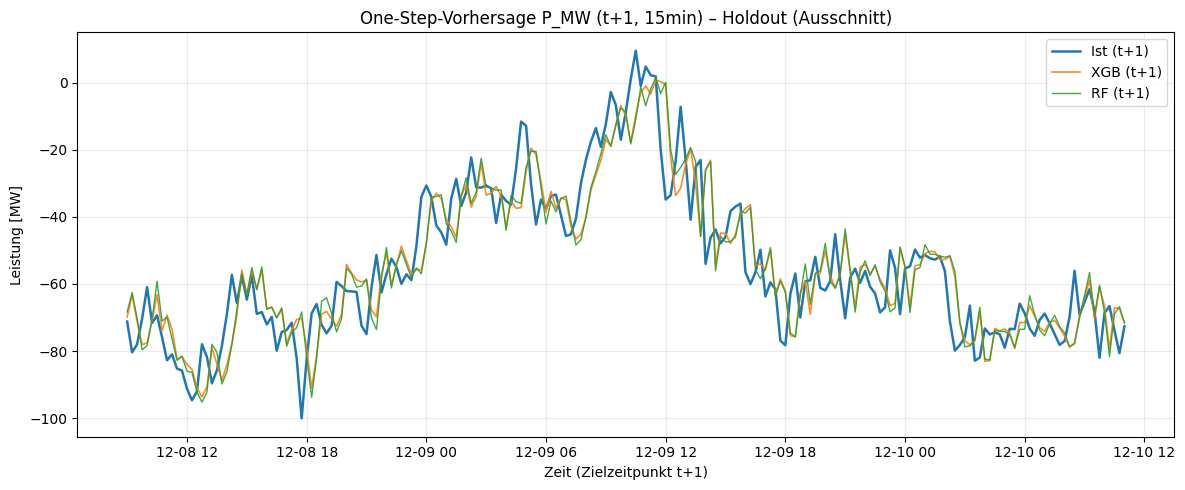


=== Zusammenfassung (Test/Holdout, t+1) ===
Baseline: {'MAE': 9.717466065100894, 'RMSE': 12.584017864622911, 'MAPE': np.float64(114.98900327800123), 'R2': 0.8162399879432058}
RF   (best_params={'max_depth': 12, 'min_samples_leaf': 10, 'n_estimators': 400}): {'MAE': 9.599707546639586, 'RMSE': 12.35544397142444, 'MAPE': np.float64(137.51982231540524), 'R2': 0.822854930262009}
XGB  (best_params={'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'subsample': 1.0}): {'MAE': 9.491792280952303, 'RMSE': 12.248067344148572, 'MAPE': np.float64(133.85701797425259), 'R2': 0.8259205565339018}

=== Trainingszeiten (ca.) ===
RF  (GridSearch + Fit): 346.5s
XGB (GridSearch + Fit): 18.2s

[RF/XGB] Rekursiver Multi-Step-Forecast über 96 Schritte (24h)...


/Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature name


[Baseline] 96-Step-Ergebnis (24h-Naive: y[t-96])
BL  96-Step MAE:  15.1718
BL  96-Step RMSE: 19.2298
BL  96-Step MAPE: 180.58%
BL  96-Step R²:   -0.8767

[RF] 96-Step-Ergebnis (rekursiv):
RF  96-Step MAE:  13.2013
RF  96-Step RMSE: 15.8486
RF  96-Step MAPE: 207.10%
RF  96-Step R²:   -0.2748

[XGB] 96-Step-Ergebnis (rekursiv):
XGB 96-Step MAE:  7.7516
XGB 96-Step RMSE: 9.6148
XGB 96-Step MAPE: 103.88%
XGB 96-Step R²:   0.5308


/Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


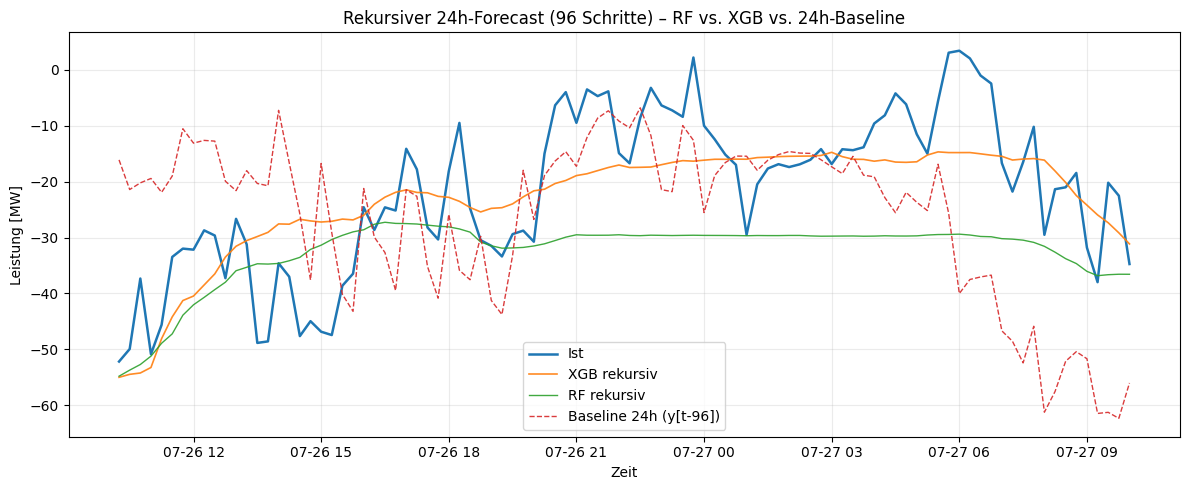

In [18]:
# 96 steps recursive forecast mit cleaning procedure
# -*- coding: utf-8 -*-
"""
One-Step-Forecast (t+1, 15 Minuten) + rekursiver 96-Step-Forecast
Modelle: RandomForest, XGBoost
Mit Hyperparameter-Tuning via GridSearchCV + TimeSeriesSplit

Benötigte Pakete:
    pip install pandas numpy scikit-learn matplotlib xgboost
"""

import os
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# ===================== USER SETTINGS =====================
CSV_PATH = r"src/data/raw/timeseries/SHUW_E24_hist.csv"
TIMESTAMP_COL = "timestamp"
TARGET = "P_MW"

# Wetter-/Exogene Features (müssen in der CSV existieren)
RAW_FEATURES = ["wind_speed_mps", "solar_radiation_Wm2", "temperature_C"]

# Autoregressive Lags (in 15-Min-Schritten)
TARGET_LAGS = [1, 4, 8, 12, 24, 96]

# Fourier-Saisonalität (Tagesperiodik, 24h = 96 * 15min)
FOURIER_K = 3
PERIOD_STEPS = 96

# Rekursiver Forecast-Horizont
HORIZON_STEPS = 96  # 24h = 96 * 15min

# Train/Test-Split
HOLDOUT_FRAC = 0.2
N_SPLITS = 5
RANDOM_STATE = 42
# =========================================================


# =========================================================
# Utility / Evaluation
# =========================================================
def safe_mape(y_true, y_pred, eps=1e-6):
    denom = np.maximum(np.abs(y_true), eps)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100.0


def evaluate(y_true, y_pred, prefix=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mape = safe_mape(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{prefix}MAE:  {mae:,.4f}")
    print(f"{prefix}RMSE: {rmse:,.4f}")
    print(f"{prefix}MAPE: {mape:,.2f}%")
    print(f"{prefix}R²:   {r2:,.4f}")
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape, "R2": r2}


def plot_holdout(ts, y_true, y_rf, y_xgb, title="One-Step-Forecast (t+1, 15min)"):
    """Plot Ausschnitt des Holdouts (z.B. letzte 200 Punkte)."""
    plt.figure(figsize=(12, 5))
    plt.plot(ts, y_true, label="Ist (t+1)", linewidth=1.8)
    plt.plot(ts, y_xgb, label="XGB (t+1)", linewidth=1.2, alpha=0.9)
    plt.plot(ts, y_rf, label="RF (t+1)", linewidth=1.0, alpha=0.9)
    plt.title(title)
    plt.xlabel("Zeit (Zielzeitpunkt t+1)")
    plt.ylabel("Leistung [MW]")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_recursive(ts, y_true, y_rf, y_xgb, y_bl, title="Rekursiver 96-Step-Forecast (24h)"):
    """Plot für 24h-Forecast: Ist vs RF vs XGB vs Baseline."""
    plt.figure(figsize=(12, 5))
    plt.plot(ts, y_true, label="Ist", linewidth=1.8)
    plt.plot(ts, y_xgb, label="XGB rekursiv", linewidth=1.2, alpha=0.9)
    plt.plot(ts, y_rf, label="RF rekursiv", linewidth=1.0, alpha=0.9)
    plt.plot(ts, y_bl, label="Baseline 24h (y[t-96])", linewidth=1.0, linestyle="--", alpha=0.9)
    plt.title(title)
    plt.xlabel("Zeit")
    plt.ylabel("Leistung [MW]")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.tight_layout()
    plt.show()


# =========================================================
# Feature Engineering
# =========================================================
def load_data(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"CSV nicht gefunden: {path}")
    df = pd.read_csv(path)
    if TIMESTAMP_COL not in df.columns:
        raise KeyError(f"Spalte '{TIMESTAMP_COL}' fehlt in CSV.")
    if TARGET not in df.columns:
        raise KeyError(f"Zielspalte '{TARGET}' fehlt in CSV.")

    df[TIMESTAMP_COL] = pd.to_datetime(df[TIMESTAMP_COL], utc=False)
    df = df.sort_values(TIMESTAMP_COL).reset_index(drop=True)
    return df


def add_time_features(df):
    ts = df[TIMESTAMP_COL]
    df["hour"] = ts.dt.hour
    df["dayofweek"] = ts.dt.dayofweek
    df["month"] = ts.dt.month

    # zirkuläre Kodierung
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
    df["dow_sin"] = np.sin(2 * np.pi * df["dayofweek"] / 7)
    df["dow_cos"] = np.cos(2 * np.pi * df["dayofweek"] / 7)
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)
    return df


def add_fourier_features(df, period_steps=PERIOD_STEPS, K=FOURIER_K, prefix="day"):
    step_idx = np.arange(len(df), dtype=float) % period_steps
    for k in range(1, K + 1):
        df[f"{prefix}_sin{k}"] = np.sin(2 * np.pi * k * step_idx / period_steps)
        df[f"{prefix}_cos{k}"] = np.cos(2 * np.pi * k * step_idx / period_steps)
    return df


def add_target_lags(df, target_col, lags):
    for l in lags:
        df[f"{target_col}_lag{l}"] = df[target_col].shift(l)
    return df


# =========================================================
# Cleaning-Pipeline
# =========================================================
def clean_data(df):
    """
    Einfache Cleaning-Pipeline:
      - entfernt NaNs in TARGET / RAW_FEATURES
      - clippt P_MW auf [q0.001, q0.999]
      - entfernt Zeilen mit extremen Sprüngen |ΔP| > 150 MW
    """

    print("\n=== Cleaning: Ausgangslage ===")
    print(f"Zeilen vor Cleaning: {len(df)}")
    print(f"P_MW: min={df[TARGET].min():.3f}, max={df[TARGET].max():.3f}")
    q_before = df[TARGET].quantile([0.001, 0.01, 0.99, 0.999])
    print("Quantile vor Cleaning (0.1%, 1%, 99%, 99.9%):")
    print(q_before)

    n_before = len(df)

    # 1) NaNs in Ziel und verfügbaren Wetterspalten entfernen
    nan_cols = [TARGET] + [c for c in RAW_FEATURES if c in df.columns]
    df = df.dropna(subset=nan_cols).copy()

    # 2) Extremwerte in P_MW winsorizen (abschneiden)
    q_low, q_high = df[TARGET].quantile([0.001, 0.999])
    df[TARGET] = df[TARGET].clip(lower=q_low, upper=q_high)

    # 3) Extreme Sprünge (Delta) entfernen
    df["P_diff"] = df[TARGET].diff()
    jump_mask = df["P_diff"].abs() > 150
    removed_jumps = jump_mask.sum()
    df = df.loc[~jump_mask].copy()
    df = df.drop(columns=["P_diff"])

    print("\n=== Cleaning: nachher ===")
    print(f"Zeilen nach Cleaning : {len(df)} (−{n_before - len(df)} entfernt)")
    print(f"P_MW (clean): min={df[TARGET].min():.3f}, max={df[TARGET].max():.3f}")
    q_after = df[TARGET].quantile([0.001, 0.01, 0.99, 0.999])
    print("Quantile nach Cleaning (0.1%, 1%, 99%, 99.9%):")
    print(q_after)
    print(f"Entfernte extreme Sprünge |ΔP| > 150 MW: {removed_jumps}")

    return df


# =========================================================
# Baum-Modelle mit GridSearch
# =========================================================
def run_tree_model(model_name, base_model, param_grid, X_train, y_train, X_test, y_test):
    print(f"\n[{model_name}] Hyperparameter-Suche (GridSearch)...")
    tscv = TimeSeriesSplit(n_splits=N_SPLITS)

    grid = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        scoring="neg_mean_absolute_error",
        cv=tscv,
        n_jobs=-1,
        verbose=1,
    )
    start_t = time.time()
    grid.fit(X_train, y_train)
    dur = time.time() - start_t

    print(f"[{model_name}] Beste Parameter  : {grid.best_params_}")
    print(f"[{model_name}] Beste CV-MAE     : {-grid.best_score_:.4f}")
    print(f"[{model_name}] GridSearch+Fit(s): {dur:.1f}s")

    best_model = grid.best_estimator_
    y_pred_test = best_model.predict(X_test)
    scores = evaluate(y_test, y_pred_test, prefix=f"{model_name} TST (t+1) ")
    return scores, grid.best_params_, y_pred_test, dur, best_model


# =========================================================
# Rekursiver Forecast (generisch für RF & XGB)
# =========================================================
def recursive_forecast_model(
    model,
    df_model,
    feature_cols,
    target_col,
    start_row_idx,
    horizon_steps,
    target_lags,
):
    """
    Generischer rekursiver Multi-Step-Forecast mit einem beliebigen Regressor (RF/XGB).
    - model: trainierter Regressor (t+1)
    - df_model: DataFrame mit Zeit-/Fourier-/exogenen Features + (initialen) Lag-Spalten
    - feature_cols: Feature-Spalten, die an model.predict() gehen
    - target_col: Name der Zielspalte (z.B. "P_MW")
    - start_row_idx: Index der ersten Feature-Zeile im Holdout (entspricht erstem One-Step-Punkt)
    - horizon_steps: Anzahl Vorwärtsschritte (z.B. 96)
    - target_lags: Liste der Lags in Schritten (z.B. [1,4,8,12,24,96])
    """
    max_lag = max(target_lags)

    if start_row_idx - max_lag < 0:
        raise ValueError(
            f"start_row_idx={start_row_idx} ist zu klein für max_lag={max_lag}."
        )

    # Historie: letzte max_lag echte Zielwerte vor dem ersten Label-Zeitpunkt
    history = df_model[target_col].iloc[
        start_row_idx - max_lag + 1 : start_row_idx + 1
    ].tolist()
    if len(history) != max_lag:
        raise RuntimeError("History-Länge ungleich max_lag – Indexing-Problem.")

    preds = []
    label_indices = []

    for s in range(horizon_steps):
        row_idx = start_row_idx + s       # Feature-Zeile
        label_idx = row_idx + 1           # Zielzeitpunkt

        if label_idx >= len(df_model):
            break

        row = df_model.iloc[row_idx].copy()

        # Lag-Features aus aktueller Historie neu setzen
        for L in target_lags:
            row[f"{target_col}_lag{L}"] = history[-L]

        x_vec = row[feature_cols].values.reshape(1, -1)
        y_hat = model.predict(x_vec)[0]

        preds.append(y_hat)
        label_indices.append(label_idx)

        history.append(y_hat)
        if len(history) > max_lag:
            history = history[-max_lag:]

    return np.array(preds), np.array(label_indices)


# =========================================================
# MAIN
# =========================================================
def main():
    print("Lade Daten...")
    df = load_data(CSV_PATH)

    # Cleaning
    df = clean_data(df)

    # ========== Feature Engineering ==========
    df = add_time_features(df)
    df = add_fourier_features(df)
    df = add_target_lags(df, TARGET, TARGET_LAGS)

    # Ziel: t+1 (ein Schritt = 15 Minuten)
    df["target_1"] = df[TARGET].shift(-1)

    # Verfügbare exogene Features prüfen
    present_feats = [c for c in RAW_FEATURES if c in df.columns]
    missing_feats = sorted(set(RAW_FEATURES) - set(present_feats))
    if missing_feats:
        print(f"Warnung: folgende RAW_FEATURES fehlen und werden ignoriert: {missing_feats}")

    time_feats = ["hour_sin", "hour_cos", "dow_sin", "dow_cos", "month_sin", "month_cos"]
    fourier_feats = [f"day_sin{k}" for k in range(1, FOURIER_K + 1)] + \
                    [f"day_cos{k}" for k in range(1, FOURIER_K + 1)]
    lag_feats = [f"{TARGET}_lag{l}" for l in TARGET_LAGS]

    feature_cols = present_feats + time_feats + fourier_feats + lag_feats

    # NaNs entfernen (wegen Shifts)
    df_model = df.dropna(subset=feature_cols + ["target_1"]).copy()

    X = df_model[feature_cols]
    y = df_model["target_1"]

    n = len(df_model)
    split_idx = int((1.0 - HOLDOUT_FRAC) * n)

    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    print(f"Datengrößen – Gesamt: {n}, Train: {len(X_train)}, Test: {len(X_test)}")
    print("Vorhersagehorizont: t+1 (15 Minuten)")

    # ========== Baseline (Naive Persistence: y_hat_{t+1} = y_t) ==========
    print("\nBaseline (Naive One-Step-Persistence) – Scores:")
    y_baseline_train = df_model[f"{TARGET}_lag1"].iloc[:split_idx].values
    y_baseline_test = df_model[f"{TARGET}_lag1"].iloc[split_idx:].values

    _ = evaluate(y_train.values, y_baseline_train, prefix="BL  (Train) ")
    bl_scores = evaluate(y_test.values, y_baseline_test, prefix="BL  (Test)  ")

    # ========== Random Forest ==========
    rf_base = RandomForestRegressor(
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )
    rf_param_grid = {
        "n_estimators": [200, 400],
        "max_depth": [None, 12],
        "min_samples_leaf": [1, 10],
    }
    rf_scores, rf_best_params, rf_pred, rf_time, rf_model = run_tree_model(
        "RF", rf_base, rf_param_grid, X_train, y_train, X_test, y_test
    )

    # ========== XGBoost ==========
    xgb_base = XGBRegressor(
        objective="reg:squarederror",
        random_state=RANDOM_STATE,
        n_estimators=400,
        tree_method="hist",
        eval_metric="rmse",
    )
    xgb_param_grid = {
        "max_depth": [4, 8],
        "learning_rate": [0.05, 0.1],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
    }
    xgb_scores, xgb_best_params, xgb_pred, xgb_time, xgb_model = run_tree_model(
        "XGB", xgb_base, xgb_param_grid, X_train, y_train, X_test, y_test
    )

    # ========== Plot – One-Step Holdout-Ausschnitt ==========
    n_plot = 200
    if len(y_test) <= n_plot:
        start_idx_plot = 0
    else:
        start_idx_plot = len(y_test) - n_plot

    ts_holdout = df_model[TIMESTAMP_COL].iloc[split_idx:]
    plot_holdout(
        ts_holdout.iloc[start_idx_plot:],
        y_test.values[start_idx_plot:],
        rf_pred[start_idx_plot:],
        xgb_pred[start_idx_plot:],
        title=f"One-Step-Vorhersage {TARGET} (t+1, 15min) – Holdout (Ausschnitt)"
    )

    print("\n=== Zusammenfassung (Test/Holdout, t+1) ===")
    print("Baseline:", bl_scores)
    print(f"RF   (best_params={rf_best_params}):", rf_scores)
    print(f"XGB  (best_params={xgb_best_params}):", xgb_scores)

    print("\n=== Trainingszeiten (ca.) ===")
    print(f"RF  (GridSearch + Fit): {rf_time:.1f}s")
    print(f"XGB (GridSearch + Fit): {xgb_time:.1f}s")

    # ========== Rekursiver 96-Step-Forecast mit RF & XGB + 24h-Baseline ==========
    print(f"\n[RF/XGB] Rekursiver Multi-Step-Forecast über {HORIZON_STEPS} Schritte (24h)...")

    start_row_idx = split_idx
    horizon = min(
        HORIZON_STEPS,
        len(df_model) - (start_row_idx + 1)
    )

    # XGB rekursiv
    y_xgb_multi, label_indices = recursive_forecast_model(
        model=xgb_model,
        df_model=df_model,
        feature_cols=feature_cols,
        target_col=TARGET,
        start_row_idx=start_row_idx,
        horizon_steps=horizon,
        target_lags=TARGET_LAGS,
    )

    # RF rekursiv – gleicher Start/Horizon → gleiche label_indices
    y_rf_multi, label_indices_rf = recursive_forecast_model(
        model=rf_model,
        df_model=df_model,
        feature_cols=feature_cols,
        target_col=TARGET,
        start_row_idx=start_row_idx,
        horizon_steps=horizon,
        target_lags=TARGET_LAGS,
    )

    # Sicherheitscheck (sollten identisch sein)
    assert np.array_equal(label_indices, label_indices_rf)

    # True-Werte und Timestamps
    y_true_multi = df_model[TARGET].iloc[label_indices].values
    ts_multi = df_model[TIMESTAMP_COL].iloc[label_indices]

    # 24h-Baseline: y_hat(t) = y(t-96)
    target_arr = df_model[TARGET].values
    baseline_indices = label_indices - PERIOD_STEPS
    if (baseline_indices < 0).any():
        raise RuntimeError("Für einige Zielzeitpunkte existiert keine 24h-Historie (t-96).")

    y_bl_multi = target_arr[baseline_indices]

    print("\n[Baseline] 96-Step-Ergebnis (24h-Naive: y[t-96])")
    bl_multi_scores = evaluate(y_true_multi, y_bl_multi, prefix="BL  96-Step ")

    print("\n[RF] 96-Step-Ergebnis (rekursiv):")
    rf_multi_scores = evaluate(y_true_multi, y_rf_multi, prefix="RF  96-Step ")

    print("\n[XGB] 96-Step-Ergebnis (rekursiv):")
    xgb_multi_scores = evaluate(y_true_multi, y_xgb_multi, prefix="XGB 96-Step ")

    # Plot der rekursiven 24h-Vorhersage vs. Baseline
    plot_recursive(
        ts_multi,
        y_true_multi,
        y_rf_multi,
        y_xgb_multi,
        y_bl_multi,
        title=f"Rekursiver 24h-Forecast (96 Schritte) – RF vs. XGB vs. 24h-Baseline"
    )


if __name__ == "__main__":
    main()


## 18.12. forecast with cleaned data (also bess-clean)

### choose 3 different nodes: 18.12.

==============================
GESAMTÜBERSICHT – ML-FORECASTING (TO-DOs & CAN-DOs)
==============================

ZIELKONTEXT
-----------
• Day-Ahead Forecast (≈96 Schritte, 15-Minuten-Raster) von P_MW
• Zielgröße: „natürliches“ Netzverhalten OHNE BESS
• Pro Node ein Modell, globale Modellstruktur
• Fokus: saubere ML-Methodik + belastbare Evaluation


================================
BEREITS ERLEDIGT / SAUBER GEKLÄRT
================================

DATA & PREPROCESSING
-------------------
✓ Festes 15-Minuten-Zeitgitter
✓ Kontrollierte Interpolation (MAX_GAP)
✓ Bewusster Umgang mit großen NaN-Blöcken
✓ Wetterdaten (historisch + Forecast) getrennt behandelt
✓ Coverage-Report (first/last valid, %, max NaN-Block)
✓ BESS-Bereinigung per Ridge-Regression
✓ Zieldefinition ohne Data Leakage
✓ Speicherung bereinigter Zeitreihen je Node

EDA / STATISTIK
---------------
✓ Grundverteilungen von P_MW
✓ Hohe Kurzfrist-Volatilität erkannt
✓ Starke Wind-Korrelation identifiziert
✓ Unterschiedliche Inbetriebnahme-Zeitpunkte je Node
✓ Repräsentative Nodes (LOW / MID / HIGH load) ausgewählt

BASELINE & CV
-------------
✓ Persistence-Baseline definiert
✓ Zeitreihen-konformes Splitting (TimeSeriesSplit)
✓ Kein Random-Split
✓ Baseline-Vergleich klar definiert


========================
OFFENE TO-DOs (PFLICHT)
========================

TASK 5 – LEARNING CURVES
-----------------------
□ Learning Curves für ausgewählte Modelle erstellen
  - x-Achse: wachsende Trainingsdaten (zeitlich)
  - y-Achse: Fehler (MAE oder RMSE)
  - Zweck:
    • Zeigt, ob Modell von mehr Daten profitiert
    • Zeigt Sättigung / Datenlimit
□ Keine Nested CV notwendig
□ Kann mit final ausgewählten Modellen erfolgen


TASK 6 – NESTED CROSS-VALIDATION
--------------------------------
□ Nested TimeSeries Cross-Validation einbauen
  - Outer Loop: finale Performance-Evaluation
  - Inner Loop: Hyperparameter-Tuning
□ Nur für Modellauswahl & Robustheit
□ Evaluation über mehrere Outer-Folds mitteln
□ Ergebnis:
  - belastbare Performance-Schätzung
  - saubere Modellentscheidung


TASK 7 – MODELLANALYSE / RESIDUEN
--------------------------------
□ Residuen berechnen (y_true – y_pred)
□ Plots erstellen:
  - Residual-Histogramm
  - Residuen vs. Zeit
  - Residuen vs. Wetter (z.B. Wind)
□ Worst-Case-Zeitpunkte identifizieren
□ Analyse:
  - Wo versagt das Modell?
  - Gibt es systematische Fehler?


TASK 8 – CONCLUSIONS & EXTENSIONS
--------------------------------
□ Zusammenfassung der Erkenntnisse
□ Kritische Reflexion:
  - Recursive Forecast → Fehlerakkumulation
  - Wetter erklärt nur Teil der Varianz
□ Konkrete Erweiterungsvorschläge (siehe unten)


========================
CAN-DOs (OPTIONAL, ABER STARK)
========================

FORECASTING-ERWEITERUNGEN
------------------------
◦ Direct Multi-Horizon Forecast (h = 1…96)
◦ Vergleich:
  - Recursive One-Step vs. Direct Multi-Horizon
◦ Quantile Forecasting / Prediction Intervals
◦ Separate Modelle für verschiedene Horizonte
◦ Fehleranalyse nach Forecast-Horizont


MODELLE & TRAINING
-----------------
◦ Mehr als zwei Modelle evaluieren (über Task-Vorgaben hinaus)
◦ Erweiterte Hyperparameter-Suche (Bayesian Opt., Random Search)
◦ Lineare Modelle als Referenz (Ridge / Lasso)
◦ HistGradientBoostingRegressor als sklearn-Alternative
◦ Einheitliche Hyperparameter je Node (keine Überanpassung)


FEATURE ENGINEERING
------------------
◦ Erweiterte Lag-Strukturen (adaptive Lags)
◦ Ramp-Rate Features (ΔP)
◦ Regime-Features (High/Low Volatility)
◦ Feiertage / Kalenderfeatures
◦ Aggregierte Wetterindikatoren


ANALYTISCHE ERWEITERUNGEN
------------------------
◦ Node-Clustering (nur zur Strukturbegründung)
◦ Fehleranalyse nach Node-Typ (LOW/MID/HIGH)
◦ PCA nur als Analyse-Tool (nicht fürs Training)


========================
NICHT NOTWENDIG / BEWUSST NICHT GEMACHT
========================

✗ Clustering als Bestandteil des Forecast-Modells
✗ PCA im Training
✗ Random CV / Shuffle Splits
✗ Zusätzliche Baselines (bewusst weggelassen)
✗ LSTM / Deep Learning als Hauptfokus (optional, nachrangig)


========================
KLARER STATUS
========================

• Task 5: fast fertig → Learning Curves fehlen
• Task 6: geplant → Nested CV
• Task 7: geplant → Residualanalyse
• Task 8: offen → wissenschaftliche Erweiterung

→ Methodik ist konsistent, prüfungs- UND masterarbeitstauglich
→ Keine konzeptionellen Lücken


In [3]:
import pandas as pd
import numpy as np
from pathlib import Path

from src.config import CLEAN_TS_DIR

meas_dir = Path(CLEAN_TS_DIR)
files = sorted(meas_dir.glob("*_hist_clean.csv"))
assert files, f"Keine *_hist.csv in {meas_dir}"

# --- Parameter ---
MIN_COVERAGE = 0.20   # z.B. mind. 20% gültige Werte (anpassen)
SELECT_BY = "median"  # "median" oder "p95" oder "mean"

rows = []
for p in files:
    node_id = p.stem.replace("_hist", "")
    df = pd.read_csv(p, parse_dates=["timestamp"]).sort_values("timestamp")
    if "P_MW" not in df.columns:
        continue
    s = df["P_MW"].astype(float)

    coverage = 1.0 - s.isna().mean()
    if coverage < MIN_COVERAGE:
        continue

    rows.append({
        "node_id": node_id,
        "coverage": coverage,
        "mean": float(s.mean(skipna=True)),
        "median": float(s.median(skipna=True)),
        "p95": float(s.quantile(0.95)),
        "std": float(s.std(skipna=True)),
        "n": int(len(s)),
    })

stats = pd.DataFrame(rows)
assert not stats.empty, "Nach Coverage-Filter keine Nodes übrig. MIN_COVERAGE senken."

stats = stats.sort_values(SELECT_BY).reset_index(drop=True)

low_node = stats.iloc[0]["node_id"]
mid_node = stats.iloc[len(stats)//2]["node_id"]
high_node = stats.iloc[-1]["node_id"]

print("Auswahl nach", SELECT_BY, "mit MIN_COVERAGE", MIN_COVERAGE)
print("LOW :", low_node)
print("MID :", mid_node)
print("HIGH:", high_node)

display(stats.loc[stats["node_id"].isin([low_node, mid_node, high_node])])


Auswahl nach median mit MIN_COVERAGE 0.2
LOW : SHUW_E24_clean
MID : SIEV_E01_clean
HIGH: TARP_E01_clean


,node_id,coverage,mean,median,p95,std,n
0,SHUW_E24_clean,0.965682,-39.469444,-32.721490,-3.584956,28.849817,68797
7,SIEV_E01_clean,0.936378,-6.759516,-0.186808,0.863026,12.652352,68797
13,TARP_E01_clean,0.991860,20.328439,18.284901,45.800000,14.328212,68797


SMOKE_TEST: True
Auswahl nach median mit MIN_COVERAGE 0.2
LOW : SHUW_E24
MID : SIEV_E01
HIGH: Tarp_E01


,node_id,coverage,mean,median,p95,std,n
0,SHUW_E24,0.965112,-39.273152,-32.462383,-3.477521,28.845634,67932
7,SIEV_E01,0.935435,-6.838624,-0.189329,0.719172,12.711721,67932
13,Tarp_E01,0.991624,20.187161,18.133333,45.600000,14.311861,67932



NODE: SHUW_E24
Supervised samples: n=64540, features=18 (exog present: ['wind_speed_mps', 'solar_radiation_Wm2', 'temperature_C'])
Baseline (Persistence) | Train: {'MAE': 5.508768233751818, 'RMSE': 9.28333575180028, 'MAPE': 46274.390064667954, 'R2': 0.8983562511942377}
Baseline (Persistence) | Holdout: {'MAE': 5.195112243740619, 'RMSE': 7.326503243527377, 'MAPE': 26.906535351140626, 'R2': 0.9305878195793967}

[Nested CV] Outer: 2 Inner: 2 (N_ITER=3 per model/fold)

Nested CV (mean over outer folds) — sorted by MAE:


,node_id,model,MAE,RMSE,R2,MAPE,fit_seconds
5,SHUW_E24,Ridge,6.017971,9.402071,0.879121,4.156037e+05,0.220231
2,SHUW_E24,RF,6.658610,9.994150,0.878347,1.019989e+06,7.109198


Selected best model for node SHUW_E24: Ridge

[Learning Curves] Growing window for selected model


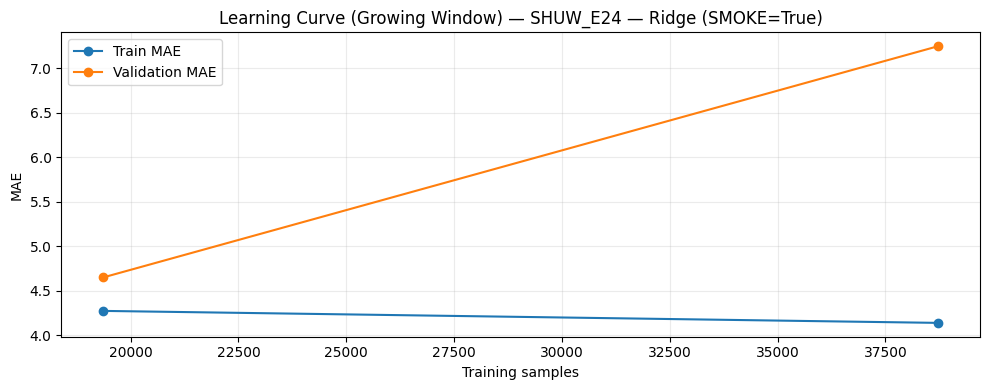


[Final Tuning on Train] + Residual analysis on Holdout
Final best params: {'model__alpha': 46.41588833612773}


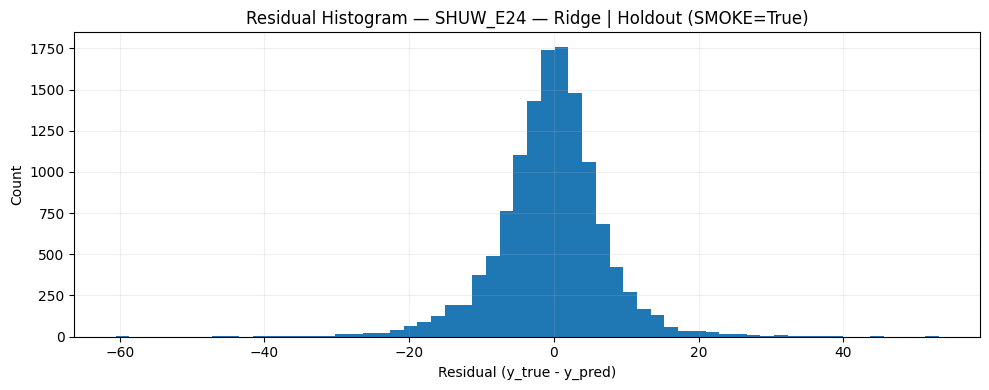

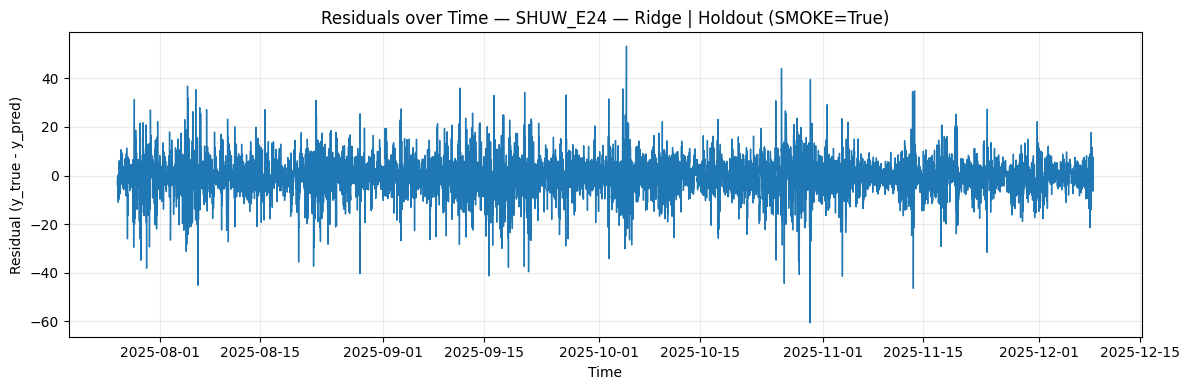

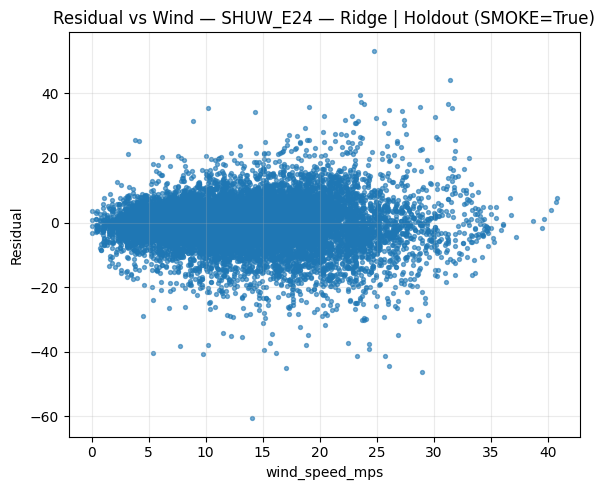

Residual analysis metrics (Holdout): {'MAE': 5.261292645110796, 'RMSE': 7.358673849980649, 'MAPE': 30.734174193231013, 'R2': 0.9299769048016231}
Worst 10 errors (Holdout):


,timestamp,y_true,y_pred,residual,|residual|
0,2025-10-30 06:30:00,-99.054583,-38.474816,-60.579767,60.579767
1,2025-10-04 19:00:00,-28.767355,-81.954807,53.187452,53.187452
2,2025-11-13 14:15:00,-108.939065,-62.558945,-46.380119,46.380119
3,2025-08-06 08:15:00,-120.586591,-75.477656,-45.108935,45.108935
4,2025-10-26 16:30:00,-99.496321,-55.194135,-44.302186,44.302186
5,2025-10-26 07:15:00,-31.065499,-75.078578,44.013079,44.013079
6,2025-11-03 18:00:00,-124.737197,-83.357837,-41.379361,41.379361
7,2025-09-15 16:30:00,-118.102289,-76.834585,-41.267704,41.267704
8,2025-10-28 18:30:00,-78.317525,-37.656581,-40.660944,40.660944
9,2025-08-28 19:15:00,-48.441122,-8.099410,-40.341712,40.341712



NODE: SIEV_E01
Supervised samples: n=62085, features=18 (exog present: ['wind_speed_mps', 'solar_radiation_Wm2', 'temperature_C'])
Baseline (Persistence) | Train: {'MAE': 1.8380974664954373, 'RMSE': 4.1226759716140755, 'MAPE': 6805.294335172407, 'R2': 0.8933256910612757}
Baseline (Persistence) | Holdout: {'MAE': 3.601271608027262, 'RMSE': 5.637617779101488, 'MAPE': 332.0759328471735, 'R2': 0.7984420072440191}

[Nested CV] Outer: 2 Inner: 2 (N_ITER=3 per model/fold)

Nested CV (mean over outer folds) — sorted by MAE:


,node_id,model,MAE,RMSE,R2,MAPE,fit_seconds
2,SIEV_E01,RF,2.321466,4.220772,0.889334,219359.621061,2.427129
5,SIEV_E01,Ridge,2.431132,4.014051,0.899781,449546.943592,0.211843


Selected best model for node SIEV_E01: RF

[Learning Curves] Growing window for selected model


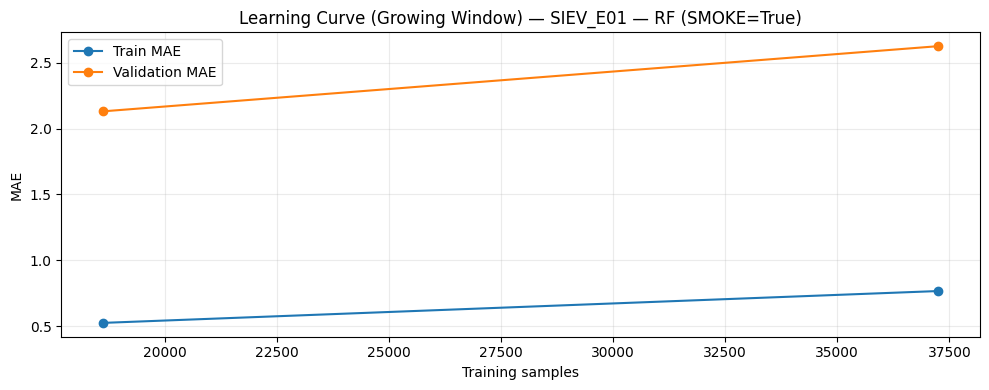


[Final Tuning on Train] + Residual analysis on Holdout
Final best params: {'n_estimators': 200, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 8}


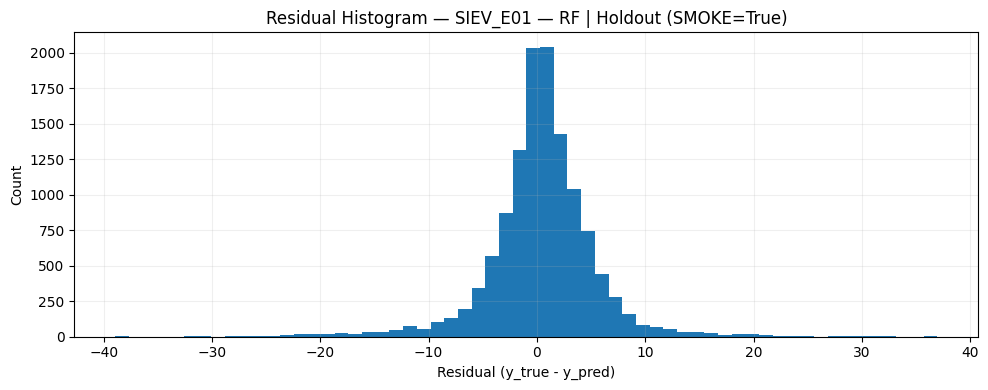

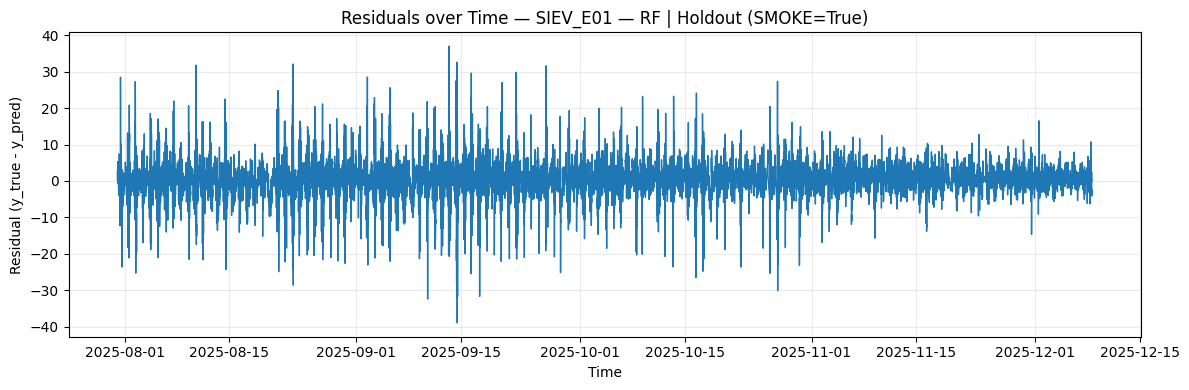

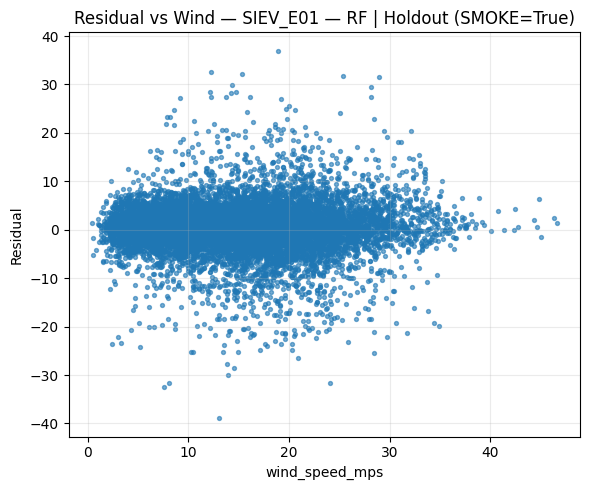

Residual analysis metrics (Holdout): {'MAE': 3.3241763462183473, 'RMSE': 5.00198684313528, 'MAPE': 178.29682698688873, 'R2': 0.8413303518734424}
Worst 10 errors (Holdout):


,timestamp,y_true,y_pred,residual,|residual|
0,2025-09-14 12:30:00,-49.317076,-10.396340,-38.920736,38.920736
1,2025-09-13 10:15:00,-2.318594,-39.289667,36.971074,36.971074
2,2025-09-14 11:00:00,1.727695,-30.860120,32.587815,32.587815
3,2025-09-10 13:15:00,-36.456550,-4.076596,-32.379954,32.379954
4,2025-08-23 12:45:00,-7.727817,-39.804411,32.076594,32.076594
5,2025-08-10 12:15:00,-4.899773,-36.636868,31.737095,31.737095
6,2025-09-14 13:30:00,-44.528582,-12.858153,-31.670429,31.670429
7,2025-09-17 12:30:00,-47.110173,-15.454349,-31.655824,31.655824
8,2025-09-26 10:00:00,-3.523878,-35.104175,31.580297,31.580297
9,2025-10-27 11:00:00,-45.148095,-15.063571,-30.084524,30.084524



NODE: Tarp_E01
Supervised samples: n=66316, features=18 (exog present: ['wind_speed_mps', 'solar_radiation_Wm2', 'temperature_C'])
Baseline (Persistence) | Train: {'MAE': 3.1026594583963494, 'RMSE': 4.998094343744943, 'MAPE': 1043800.4392518152, 'R2': 0.8787138927333672}
Baseline (Persistence) | Holdout: {'MAE': 2.970924695411758, 'RMSE': 4.249265865285052, 'MAPE': 34.64315991776009, 'R2': 0.9066848489535363}

[Nested CV] Outer: 2 Inner: 2 (N_ITER=3 per model/fold)

Nested CV (mean over outer folds) — sorted by MAE:


,node_id,model,MAE,RMSE,R2,MAPE,fit_seconds
5,Tarp_E01,Ridge,3.320039,5.018261,0.875016,1.222993e+06,0.215929
2,Tarp_E01,RF,3.849319,5.803355,0.843861,2.392713e+06,2.440735


Selected best model for node Tarp_E01: Ridge

[Learning Curves] Growing window for selected model


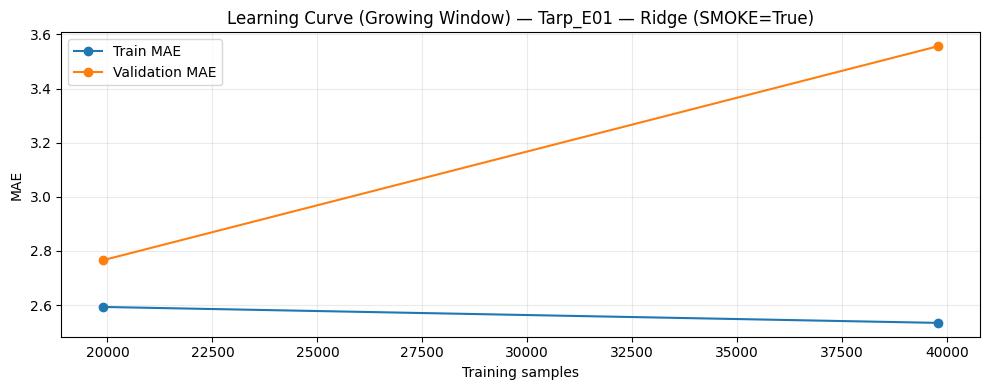


[Final Tuning on Train] + Residual analysis on Holdout
Final best params: {'model__alpha': 46.41588833612773}


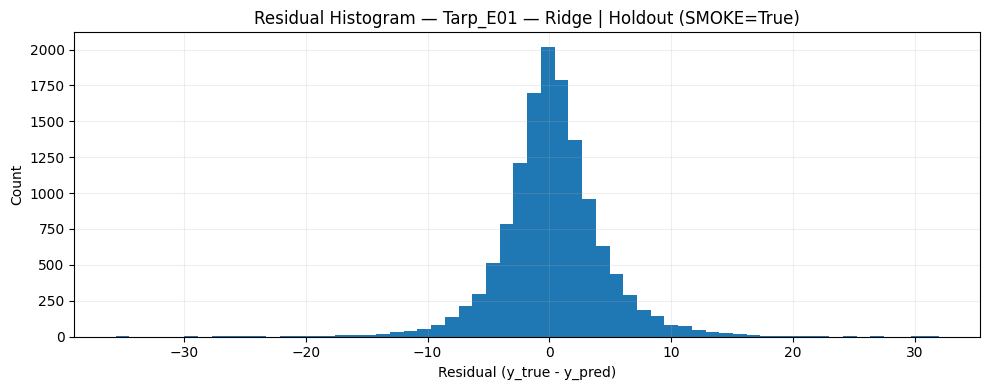

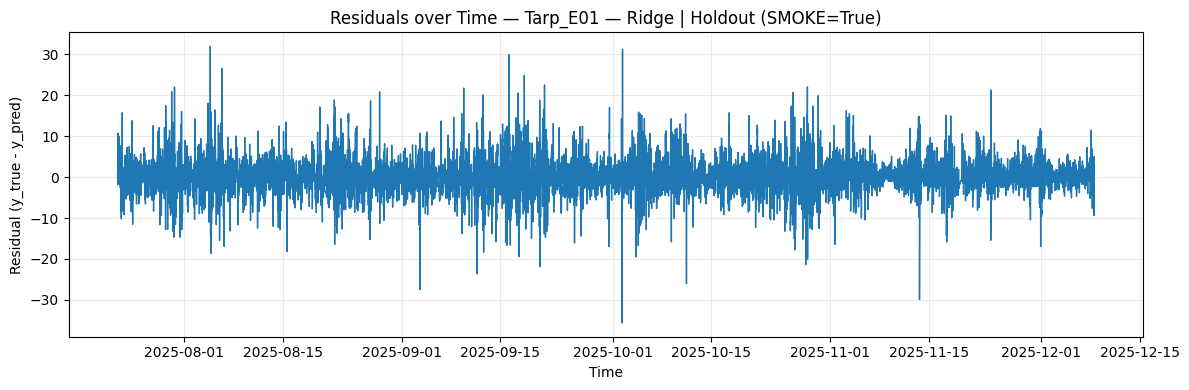

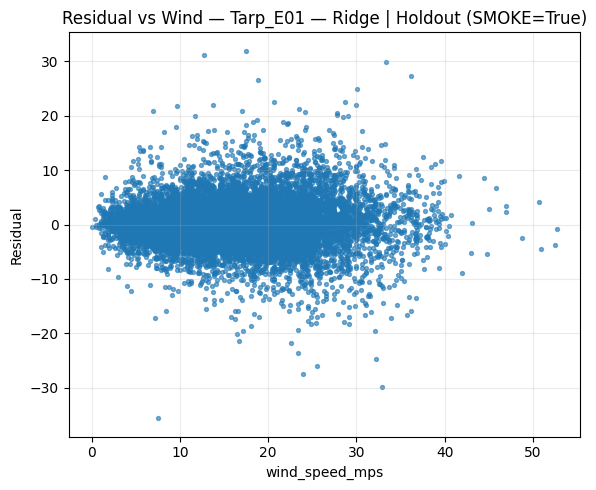

Residual analysis metrics (Holdout): {'MAE': 2.9949453361580316, 'RMSE': 4.237327047332216, 'MAPE': 39.05608850052572, 'R2': 0.9072084723633689}
Worst 10 errors (Holdout):


,timestamp,y_true,y_pred,residual,|residual|
0,2025-10-02 08:00:00,-20.999016,14.609266,-35.608282,35.608282
1,2025-08-04 17:00:00,51.490695,19.519698,31.970996,31.970996
2,2025-10-02 09:30:00,19.639404,-11.566466,31.205870,31.205870
3,2025-11-13 16:15:00,38.775075,68.705904,-29.930829,29.930829
4,2025-09-16 05:30:00,64.816632,34.912147,29.904485,29.904485
5,2025-09-03 13:00:00,7.869011,35.362479,-27.493468,27.493468
6,2025-09-16 05:15:00,61.217683,33.840561,27.377123,27.377123
7,2025-08-06 08:15:00,59.377259,32.796408,26.580851,26.580851
8,2025-10-11 12:00:00,50.532980,76.584746,-26.051766,26.051766
9,2025-09-18 10:00:00,77.803299,52.939014,24.864285,24.864285



GLOBAL SUMMARY — Nested CV mean rows (per node/model)


,node_id,model,MAE,RMSE,R2,MAPE,fit_seconds
5,SHUW_E24,Ridge,6.017971,9.402071,0.879121,4.156037e+05,0.220231
2,SHUW_E24,RF,6.658610,9.994150,0.878347,1.019989e+06,7.109198
8,SIEV_E01,RF,2.321466,4.220772,0.889334,2.193596e+05,2.427129
11,SIEV_E01,Ridge,2.431132,4.014051,0.899781,4.495469e+05,0.211843
17,Tarp_E01,Ridge,3.320039,5.018261,0.875016,1.222993e+06,0.215929
14,Tarp_E01,RF,3.849319,5.803355,0.843861,2.392713e+06,2.440735



GLOBAL SUMMARY — Final holdout residual metrics (best model per node)


,node_id,model,MAE,RMSE,MAPE,R2,best_params
2,Tarp_E01,Ridge,2.994945,4.237327,39.056089,0.907208,{'model__alpha': 46.41588833612773}
1,SIEV_E01,RF,3.324176,5.001987,178.296827,0.841330,"{'n_estimators': 200, 'min_samples_leaf': 5, '..."
0,SHUW_E24,Ridge,5.261293,7.358674,30.734174,0.929977,{'model__alpha': 46.41588833612773}


In [2]:
# smoke test

# ============================================================
# FULL PIPELINE CELL (3 Nodes) with SMOKE_TEST switch
# - Node selection (low/mid/high) from CLEAN_TS_DIR
# - Feature engineering (lags + time + optional weather + Fourier)
# - Baseline (persistence)
# - Nested CV (outer eval + inner tuning)
# - Learning curves (growing train window)
# - Residual analysis on final holdout
# - Multiple ML models + broader hyperparameter exploration
# ============================================================

import warnings, math, time
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor

try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except Exception:
    HAS_XGB = False

from src.config import CLEAN_TS_DIR


# =========================
# SMOKE TEST SWITCH
# =========================
SMOKE_TEST = True  # <-- set False for full run

# =========================
# Settings (base)
# =========================
TIMESTAMP_COL = "timestamp"
TARGET = "P_MW"
RAW_FEATURES = ["wind_speed_mps", "solar_radiation_Wm2", "temperature_C"]  # set [] if weather not present

TARGET_LAGS = [1, 4, 8, 12, 24, 96]   # in 15-min steps
FOURIER_K = 3
PERIOD_STEPS = 96

# Node selection
MIN_COVERAGE = 0.20
SELECT_BY = "median"  # "median" or "p95" or "mean"

# Default (full) evaluation budgets
OUTER_SPLITS = 4
INNER_SPLITS = 4
FINAL_HOLDOUT_FRAC = 0.20

N_ITER = 20
RANDOM_STATE = 42
N_JOBS = -1

LC_TRAIN_FRACS = [0.15, 0.25, 0.40, 0.60, 0.80]
LC_VAL_FRAC = 0.10
LC_MIN_POINTS = 2000

# =========================
# Smoke overrides
# =========================
if SMOKE_TEST:
    # keep it fast and robust
    OUTER_SPLITS = 2
    INNER_SPLITS = 2
    N_ITER = 3

    LC_TRAIN_FRACS = [0.30, 0.60]
    LC_VAL_FRAC = 0.10
    LC_MIN_POINTS = 500

    # reduce lags for shorter series / fewer NaN drops
    TARGET_LAGS = [1, 4, 96]

    # optional: if xgboost is installed it can still be heavy; keep it off in smoke
    HAS_XGB = False


# =========================
# Helpers
# =========================
def safe_mape(y_true, y_pred, eps=1e-6):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.maximum(np.abs(y_true), eps)
    return float(np.mean(np.abs((y_true - y_pred) / denom)) * 100.0)

def evaluate(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mae = float(mean_absolute_error(y_true, y_pred))
    rmse = float(math.sqrt(mean_squared_error(y_true, y_pred)))
    r2 = float(r2_score(y_true, y_pred))
    mape = safe_mape(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape, "R2": r2}

def add_time_features(df):
    ts = pd.to_datetime(df[TIMESTAMP_COL], utc=False)
    df["hour"] = ts.dt.hour
    df["dayofweek"] = ts.dt.dayofweek
    df["month"] = ts.dt.month

    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
    df["dow_sin"]  = np.sin(2 * np.pi * df["dayofweek"] / 7)
    df["dow_cos"]  = np.cos(2 * np.pi * df["dayofweek"] / 7)
    df["month_sin"]= np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"]= np.cos(2 * np.pi * df["month"] / 12)
    return df

def add_fourier_features(df, period_steps=PERIOD_STEPS, K=FOURIER_K, prefix="day"):
    step_idx = (np.arange(len(df), dtype=float) % period_steps)
    for k in range(1, K + 1):
        df[f"{prefix}_sin{k}"] = np.sin(2 * np.pi * k * step_idx / period_steps)
        df[f"{prefix}_cos{k}"] = np.cos(2 * np.pi * k * step_idx / period_steps)
    return df

def add_target_lags(df, target_col, lags):
    for L in lags:
        df[f"{target_col}_lag{L}"] = df[target_col].shift(L)
    return df

def prepare_supervised_df(df_raw):
    df = df_raw.copy()
    df[TIMESTAMP_COL] = pd.to_datetime(df[TIMESTAMP_COL], utc=False)
    df = df.sort_values(TIMESTAMP_COL).reset_index(drop=True)

    df = add_time_features(df)
    df = add_fourier_features(df)
    df = add_target_lags(df, TARGET, TARGET_LAGS)

    # one-step target (t+1)
    df["target_1"] = df[TARGET].shift(-1)

    present_feats = [c for c in RAW_FEATURES if c in df.columns]
    time_feats = ["hour_sin","hour_cos","dow_sin","dow_cos","month_sin","month_cos"]
    fourier_feats = [f"day_sin{k}" for k in range(1, FOURIER_K+1)] + [f"day_cos{k}" for k in range(1, FOURIER_K+1)]
    lag_feats = [f"{TARGET}_lag{L}" for L in TARGET_LAGS]
    feature_cols = present_feats + time_feats + fourier_feats + lag_feats

    df_model = df.dropna(subset=feature_cols + ["target_1"]).copy()
    X = df_model[feature_cols]
    y = df_model["target_1"].astype(float)
    t = df_model[TIMESTAMP_COL]
    return df_model, X, y, t, feature_cols, present_feats

def baseline_persistence_from_lag1(df_model, split_idx):
    y_train = df_model["target_1"].iloc[:split_idx].values
    y_test  = df_model["target_1"].iloc[split_idx:].values
    yhat_train = df_model[f"{TARGET}_lag1"].iloc[:split_idx].values
    yhat_test  = df_model[f"{TARGET}_lag1"].iloc[split_idx:].values
    return evaluate(y_train, yhat_train), evaluate(y_test, yhat_test)


# =========================
# Model zoo + search spaces
# =========================
def make_models_and_spaces(smoke=False):
    models = {}

    # Tree models
    models["RF"] = (
        RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=N_JOBS),
        {
            "n_estimators": [100, 200] if smoke else [200, 400, 800],
            "max_depth": [None, 8, 12] if smoke else [None, 8, 12, 16, 24],
            "min_samples_leaf": [1, 5] if smoke else [1, 2, 5, 10],
            "max_features": ["sqrt", 0.8] if smoke else ["sqrt", 0.5, 0.8, None],
        },
    )

    if not smoke:
        models["ET"] = (
            ExtraTreesRegressor(random_state=RANDOM_STATE, n_jobs=N_JOBS),
            {
                "n_estimators": [200, 400, 800],
                "max_depth": [None, 8, 12, 16, 24],
                "min_samples_leaf": [1, 2, 5, 10],
                "max_features": ["sqrt", 0.5, 0.8, None],
            },
        )

        models["HGB"] = (
            HistGradientBoostingRegressor(random_state=RANDOM_STATE),
            {
                "learning_rate": [0.03, 0.05, 0.08, 0.1],
                "max_depth": [None, 6, 10, 14],
                "max_leaf_nodes": [31, 63, 127],
                "min_samples_leaf": [10, 20, 50],
                "l2_regularization": [0.0, 0.1, 1.0],
            },
        )

    if HAS_XGB and (not smoke):
        models["XGB"] = (
            XGBRegressor(
                objective="reg:squarederror",
                random_state=RANDOM_STATE,
                tree_method="hist",
                n_estimators=800,
                eval_metric="rmse",
                n_jobs=N_JOBS
            ),
            {
                "max_depth": [3, 4, 6, 8, 10],
                "learning_rate": [0.02, 0.03, 0.05, 0.08, 0.1],
                "subsample": [0.6, 0.8, 1.0],
                "colsample_bytree": [0.6, 0.8, 1.0],
                "reg_lambda": [0.0, 0.5, 1.0, 2.0, 5.0],
                "min_child_weight": [1, 5, 10],
            },
        )

    # Linear models (scaled) — cheap and useful as contrast
    models["Ridge"] = (
        Pipeline([("scaler", StandardScaler()), ("model", Ridge(random_state=RANDOM_STATE))]),
        {
            "model__alpha": np.logspace(-3, 3, 10 if smoke else 20).tolist(),
        },
    )

    if not smoke:
        models["ENet"] = (
            Pipeline([("scaler", StandardScaler()), ("model", ElasticNet(random_state=RANDOM_STATE, max_iter=5000))]),
            {
                "model__alpha": np.logspace(-4, 2, 20).tolist(),
                "model__l1_ratio": np.linspace(0.05, 0.95, 10).tolist(),
            },
        )

    return models


# =========================
# Nested CV
# =========================
def nested_cv_for_node(X, y, model_specs, node_id, scoring="neg_mean_absolute_error"):
    outer = TimeSeriesSplit(n_splits=OUTER_SPLITS)
    inner = TimeSeriesSplit(n_splits=INNER_SPLITS)

    fold_rows = []

    for model_name, (estimator, param_dist) in model_specs.items():
        fold_scores = []
        fold_fit_secs = []

        for fold_i, (tr_idx, te_idx) in enumerate(outer.split(X), start=1):
            X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
            X_te, y_te = X.iloc[te_idx], y.iloc[te_idx]

            search = RandomizedSearchCV(
                estimator=estimator,
                param_distributions=param_dist,
                n_iter=N_ITER,
                scoring=scoring,
                cv=inner,
                random_state=RANDOM_STATE,
                n_jobs=N_JOBS,
                verbose=0,
            )

            t0 = time.time()
            search.fit(X_tr, y_tr)
            fit_s = time.time() - t0

            best = search.best_estimator_
            y_hat = best.predict(X_te)
            metrics = evaluate(y_te.values, y_hat)

            fold_scores.append(metrics)
            fold_fit_secs.append(fit_s)

            fold_rows.append({
                "node_id": node_id,
                "model": model_name,
                "outer_fold": fold_i,
                "MAE": metrics["MAE"],
                "RMSE": metrics["RMSE"],
                "R2": metrics["R2"],
                "MAPE": metrics["MAPE"],
                "fit_seconds": fit_s,
                "best_params": str(search.best_params_),
            })

        # mean row per model
        fold_rows.append({
            "node_id": node_id,
            "model": model_name,
            "outer_fold": "MEAN",
            "MAE": float(np.mean([s["MAE"] for s in fold_scores])),
            "RMSE": float(np.mean([s["RMSE"] for s in fold_scores])),
            "R2": float(np.mean([s["R2"] for s in fold_scores])),
            "MAPE": float(np.mean([s["MAPE"] for s in fold_scores])),
            "fit_seconds": float(np.mean(fold_fit_secs)),
            "best_params": "(varies per fold)",
        })

    results = pd.DataFrame(fold_rows)
    mean_rows = results[results["outer_fold"].astype(str) == "MEAN"].copy()
    best_model = mean_rows.sort_values("MAE", ascending=True).iloc[0]["model"]
    return results, best_model


# =========================
# Learning Curves (growing train window)
# =========================
def learning_curve_growing_window(X, y, estimator, param_dist, node_id, model_name):
    n = len(X)
    if n < LC_MIN_POINTS:
        print(f"[{node_id} | {model_name}] Learning curve skipped (n={n} < {LC_MIN_POINTS}).")
        return None

    val_len = max(int(LC_VAL_FRAC * n), 200)
    curves = []

    for frac in LC_TRAIN_FRACS:
        train_end = int(frac * n)
        val_start = train_end
        val_end = min(train_end + val_len, n)

        if train_end < 300 or (val_end - val_start) < 100:
            continue

        X_tr, y_tr = X.iloc[:train_end], y.iloc[:train_end]
        X_va, y_va = X.iloc[val_start:val_end], y.iloc[val_start:val_end]

        inner = TimeSeriesSplit(n_splits=INNER_SPLITS)

        # cheap tuning for LC (still meaningful, but not too slow)
        search = RandomizedSearchCV(
            estimator=estimator,
            param_distributions=param_dist,
            n_iter=max(2, min(10, N_ITER)),
            scoring="neg_mean_absolute_error",
            cv=inner,
            random_state=RANDOM_STATE,
            n_jobs=N_JOBS,
            verbose=0,
        )

        t0 = time.time()
        search.fit(X_tr, y_tr)
        best = search.best_estimator_
        fit_s = time.time() - t0

        pred_tr = best.predict(X_tr)
        pred_va = best.predict(X_va)

        curves.append({
            "train_frac": frac,
            "train_n": len(X_tr),
            "val_n": len(X_va),
            "train_MAE": float(mean_absolute_error(y_tr, pred_tr)),
            "val_MAE": float(mean_absolute_error(y_va, pred_va)),
            "fit_seconds": float(fit_s),
        })

    if not curves:
        print(f"[{node_id} | {model_name}] Learning curve: not enough data for configured windows.")
        return None

    lc = pd.DataFrame(curves)

    plt.figure(figsize=(10, 4))
    plt.plot(lc["train_n"], lc["train_MAE"], marker="o", label="Train MAE")
    plt.plot(lc["train_n"], lc["val_MAE"], marker="o", label="Validation MAE")
    plt.title(f"Learning Curve (Growing Window) — {node_id} — {model_name} (SMOKE={SMOKE_TEST})")
    plt.xlabel("Training samples")
    plt.ylabel("MAE")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return lc


# =========================
# Residual Analysis (final holdout)
# =========================
def residual_analysis(df_model, X, y, t, best_estimator, node_id, model_name, present_feats):
    n = len(X)
    split_idx = int((1.0 - FINAL_HOLDOUT_FRAC) * n)

    X_tr, y_tr = X.iloc[:split_idx], y.iloc[:split_idx]
    X_te, y_te = X.iloc[split_idx:], y.iloc[split_idx:]
    t_te = t.iloc[split_idx:]

    best_estimator.fit(X_tr, y_tr)
    y_hat = best_estimator.predict(X_te)
    resid = (y_te.values - y_hat)

    metrics = evaluate(y_te.values, y_hat)

    # 1) residual histogram
    plt.figure(figsize=(10, 4))
    plt.hist(resid, bins=60)
    plt.title(f"Residual Histogram — {node_id} — {model_name} | Holdout (SMOKE={SMOKE_TEST})")
    plt.xlabel("Residual (y_true - y_pred)")
    plt.ylabel("Count")
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

    # 2) residual over time
    plt.figure(figsize=(12, 4))
    plt.plot(t_te.values, resid, linewidth=1.0)
    plt.title(f"Residuals over Time — {node_id} — {model_name} | Holdout (SMOKE={SMOKE_TEST})")
    plt.xlabel("Time")
    plt.ylabel("Residual (y_true - y_pred)")
    plt.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()

    # 3) residual vs wind (if available)
    if "wind_speed_mps" in present_feats:
        wind_te = df_model.loc[X_te.index, "wind_speed_mps"].values
        plt.figure(figsize=(6, 5))
        plt.scatter(wind_te, resid, s=8, alpha=0.6)
        plt.title(f"Residual vs Wind — {node_id} — {model_name} | Holdout (SMOKE={SMOKE_TEST})")
        plt.xlabel("wind_speed_mps")
        plt.ylabel("Residual")
        plt.grid(True, alpha=0.25)
        plt.tight_layout()
        plt.show()

    # Worst cases
    abs_res = np.abs(resid)
    worst_idx = np.argsort(-abs_res)[:10]
    worst = pd.DataFrame({
        "timestamp": t_te.iloc[worst_idx].values,
        "y_true": y_te.iloc[worst_idx].values,
        "y_pred": y_hat[worst_idx],
        "residual": resid[worst_idx],
        "|residual|": abs_res[worst_idx],
    }).sort_values("|residual|", ascending=False)

    return metrics, worst


# =========================
# 0) Select LOW/MID/HIGH nodes (your logic)
# =========================
meas_dir = Path(CLEAN_TS_DIR)
files = sorted(meas_dir.glob("*_hist_clean.csv"))
assert files, f"Keine *_hist_clean.csv in {meas_dir}"

rows = []
for p in files:
    node_id = p.stem.replace("_hist_clean", "")
    df = pd.read_csv(p, parse_dates=[TIMESTAMP_COL]).sort_values(TIMESTAMP_COL)
    if TARGET not in df.columns:
        continue
    s = df[TARGET].astype(float)
    coverage = 1.0 - s.isna().mean()
    if coverage < MIN_COVERAGE:
        continue

    rows.append({
        "node_id": node_id,
        "coverage": coverage,
        "mean": float(s.mean(skipna=True)),
        "median": float(s.median(skipna=True)),
        "p95": float(s.quantile(0.95)),
        "std": float(s.std(skipna=True)),
        "n": int(len(s)),
    })

stats = pd.DataFrame(rows)
assert not stats.empty, "Nach Coverage-Filter keine Nodes übrig. MIN_COVERAGE senken."
stats = stats.sort_values(SELECT_BY).reset_index(drop=True)

low_node = stats.iloc[0]["node_id"]
mid_node = stats.iloc[len(stats)//2]["node_id"]
high_node = stats.iloc[-1]["node_id"]

print("SMOKE_TEST:", SMOKE_TEST)
print("Auswahl nach", SELECT_BY, "mit MIN_COVERAGE", MIN_COVERAGE)
print("LOW :", low_node)
print("MID :", mid_node)
print("HIGH:", high_node)
display(stats.loc[stats["node_id"].isin([low_node, mid_node, high_node])])


# =========================
# 1) Run everything per node
# =========================
model_specs = make_models_and_spaces(smoke=SMOKE_TEST)

# In SMOKE mode, keep it minimal by default (fast + reliable)
if SMOKE_TEST:
    keep = [k for k in ["RF", "Ridge"] if k in model_specs]
    model_specs = {k: model_specs[k] for k in keep}

all_nested = []
all_learning_curves = {}
all_residuals = []
all_worst = {}

for node_id in [low_node, mid_node, high_node]:
    print("\n" + "="*90)
    print(f"NODE: {node_id}")
    print("="*90)

    path = meas_dir / f"{node_id}_hist_clean.csv"
    df_raw = pd.read_csv(path)

    df_model, X, y, t, feature_cols, present_feats = prepare_supervised_df(df_raw)
    n = len(X)
    print(f"Supervised samples: n={n}, features={len(feature_cols)} (exog present: {present_feats})")
    assert n > 0, f"{node_id}: Nach Feature/Lag-Dropna keine Samples übrig. Prüfe Spalten/NaNs/Lags."

    # Baseline (persistence)
    split_idx = int((1.0 - FINAL_HOLDOUT_FRAC) * n)
    bl_tr, bl_te = baseline_persistence_from_lag1(df_model, split_idx)
    print("Baseline (Persistence) | Train:", bl_tr)
    print("Baseline (Persistence) | Holdout:", bl_te)

    # Nested CV
    print("\n[Nested CV] Outer:", OUTER_SPLITS, "Inner:", INNER_SPLITS, f"(N_ITER={N_ITER} per model/fold)")
    nested_df, best_model_name = nested_cv_for_node(X, y, model_specs, node_id=node_id)
    all_nested.append(nested_df)

    mean_rows = nested_df[nested_df["outer_fold"].astype(str) == "MEAN"].sort_values("MAE")
    print("\nNested CV (mean over outer folds) — sorted by MAE:")
    display(mean_rows[["node_id","model","MAE","RMSE","R2","MAPE","fit_seconds"]])

    print(f"Selected best model for node {node_id}: {best_model_name}")

    # Learning Curves for selected model
    print("\n[Learning Curves] Growing window for selected model")
    est, pspace = model_specs[best_model_name]
    lc = learning_curve_growing_window(X, y, est, pspace, node_id=node_id, model_name=best_model_name)
    all_learning_curves[node_id] = lc

    # Final tuning on train + residuals on holdout
    print("\n[Final Tuning on Train] + Residual analysis on Holdout")
    X_tr, y_tr = X.iloc[:split_idx], y.iloc[:split_idx]
    inner = TimeSeriesSplit(n_splits=INNER_SPLITS)

    final_search = RandomizedSearchCV(
        estimator=est,
        param_distributions=pspace,
        n_iter=max(5, N_ITER) if SMOKE_TEST else max(25, N_ITER),
        scoring="neg_mean_absolute_error",
        cv=inner,
        random_state=RANDOM_STATE,
        n_jobs=N_JOBS,
        verbose=0,
    )
    final_search.fit(X_tr, y_tr)
    final_best = final_search.best_estimator_
    print("Final best params:", final_search.best_params_)

    res_metrics, worst = residual_analysis(
        df_model=df_model,
        X=X, y=y, t=t,
        best_estimator=final_best,
        node_id=node_id,
        model_name=best_model_name,
        present_feats=present_feats
    )
    print("Residual analysis metrics (Holdout):", res_metrics)
    print("Worst 10 errors (Holdout):")
    display(worst)

    all_residuals.append({
        "node_id": node_id,
        "model": best_model_name,
        **res_metrics,
        "best_params": str(final_search.best_params_)
    })
    all_worst[node_id] = worst


# =========================
# 2) Global summary tables
# =========================
nested_all = pd.concat(all_nested, ignore_index=True)
print("\n" + "="*90)
print("GLOBAL SUMMARY — Nested CV mean rows (per node/model)")
print("="*90)
nested_means = nested_all[nested_all["outer_fold"].astype(str) == "MEAN"].copy()
nested_means = nested_means.sort_values(["node_id", "MAE"])
display(nested_means[["node_id","model","MAE","RMSE","R2","MAPE","fit_seconds"]])

residual_summary = pd.DataFrame(all_residuals).sort_values("MAE")
print("\n" + "="*90)
print("GLOBAL SUMMARY — Final holdout residual metrics (best model per node)")
print("="*90)
display(residual_summary)


Auswahl nach median mit MIN_COVERAGE 0.2
LOW : SHUW_E24
MID : SIEV_E01
HIGH: Tarp_E01


,node_id,coverage,mean,median,p95,std,n
0,SHUW_E24,0.965112,-39.273152,-32.462383,-3.477521,28.845634,67932
7,SIEV_E01,0.935435,-6.838624,-0.189329,0.719172,12.711721,67932
13,Tarp_E01,0.991624,20.187161,18.133333,45.600000,14.311861,67932



NODE: SHUW_E24
Supervised samples: n=64097, features=21 (exog present: ['wind_speed_mps', 'solar_radiation_Wm2', 'temperature_C'])
Baseline (Persistence) | Train: {'MAE': 5.500196836125294, 'RMSE': 9.272245894791704, 'R2': 0.8984508081714684}
Baseline (Persistence) | Holdout: {'MAE': 5.1805200266882165, 'RMSE': 7.287261701405564, 'R2': 0.9312855734164105}

[Nested CV] Outer: 4 Inner: 4 (N_ITER=20 per model/fold)

Nested CV (mean over outer folds) — sorted by MAE:


,node_id,model,MAE,RMSE,R2,fit_seconds
4,SHUW_E24,RF,5.694381,8.606193,0.888947,470.509756
9,SHUW_E24,HGB,5.707630,8.637628,0.889394,10.350371
14,SHUW_E24,Ridge,5.732747,8.704769,0.884209,0.638047


Selected best model for node SHUW_E24: RF

[Learning Curves] Growing window for selected model


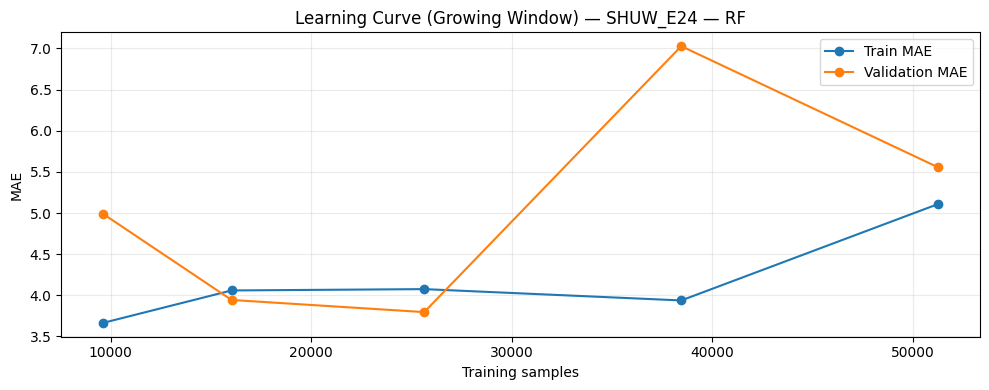


[Final Tuning on Train] + Residual analysis on Holdout
Final best params: {'n_estimators': 200, 'min_samples_leaf': 5, 'max_features': 0.5, 'max_depth': 12}


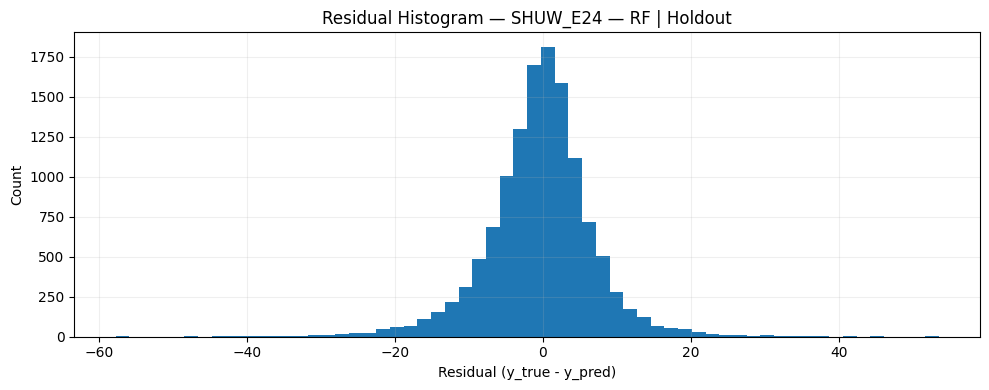

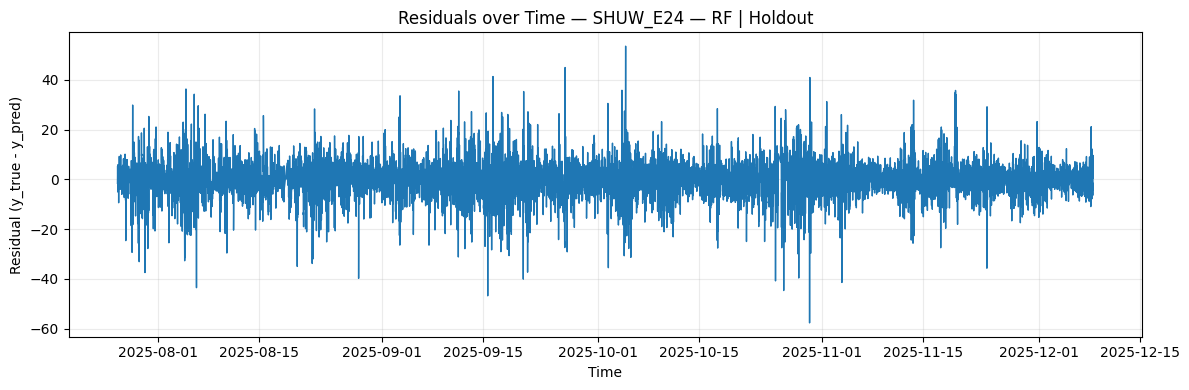

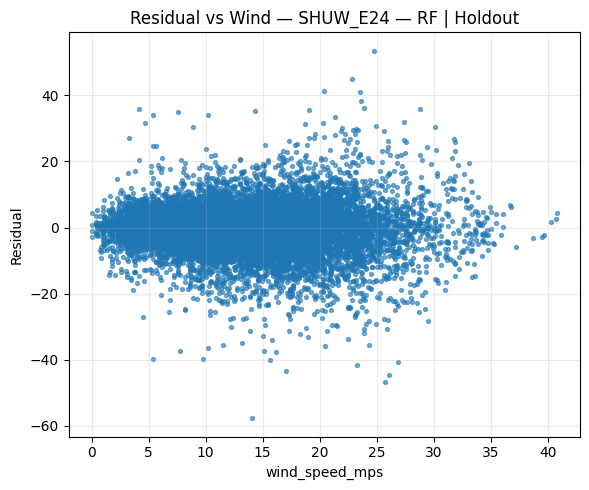

Residual analysis metrics (Holdout): {'MAE': 5.1340202222697915, 'RMSE': 7.218796249875205, 'R2': 0.9325706827533796}
Worst 10 errors (Holdout):


,timestamp,y_true,y_pred,residual,|residual|
0,2025-10-30 06:30:00,-99.054583,-41.333520,-57.721063,57.721063
1,2025-10-04 19:00:00,-28.767355,-82.300348,53.532993,53.532993
2,2025-09-15 16:30:00,-118.102289,-71.267381,-46.834908,46.834908
3,2025-09-26 09:45:00,-101.448118,-146.398469,44.950351,44.950351
4,2025-10-26 16:30:00,-99.496321,-54.786689,-44.709631,44.709631
5,2025-08-06 08:15:00,-120.586591,-77.012000,-43.574592,43.574592
6,2025-11-03 18:00:00,-124.737197,-83.268115,-41.469082,41.469082
7,2025-09-16 10:00:00,-91.050982,-132.378269,41.327286,41.327286
8,2025-10-30 07:30:00,-53.857532,-94.798080,40.940548,40.940548
9,2025-10-25 13:15:00,-76.371451,-35.537854,-40.833597,40.833597



NODE: SIEV_E01
Supervised samples: n=61330, features=21 (exog present: ['wind_speed_mps', 'solar_radiation_Wm2', 'temperature_C'])
Baseline (Persistence) | Train: {'MAE': 1.8408012884224267, 'RMSE': 4.127355608896763, 'R2': 0.8930512191337092}
Baseline (Persistence) | Holdout: {'MAE': 3.5807845089976102, 'RMSE': 5.597616378259662, 'R2': 0.8013834240910159}

[Nested CV] Outer: 4 Inner: 4 (N_ITER=20 per model/fold)

Nested CV (mean over outer folds) — sorted by MAE:


,node_id,model,MAE,RMSE,R2,fit_seconds
4,SIEV_E01,RF,2.149553,4.039254,0.895589,439.590178
9,SIEV_E01,HGB,2.275760,4.148611,0.889975,7.018460
14,SIEV_E01,Ridge,2.531349,4.159650,0.888619,0.584826


Selected best model for node SIEV_E01: RF

[Learning Curves] Growing window for selected model


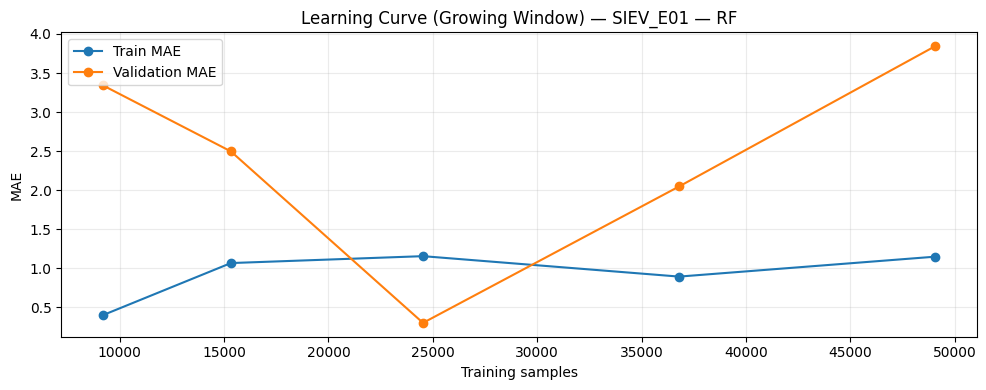


[Final Tuning on Train] + Residual analysis on Holdout
Final best params: {'n_estimators': 800, 'min_samples_leaf': 10, 'max_features': None, 'max_depth': 12}


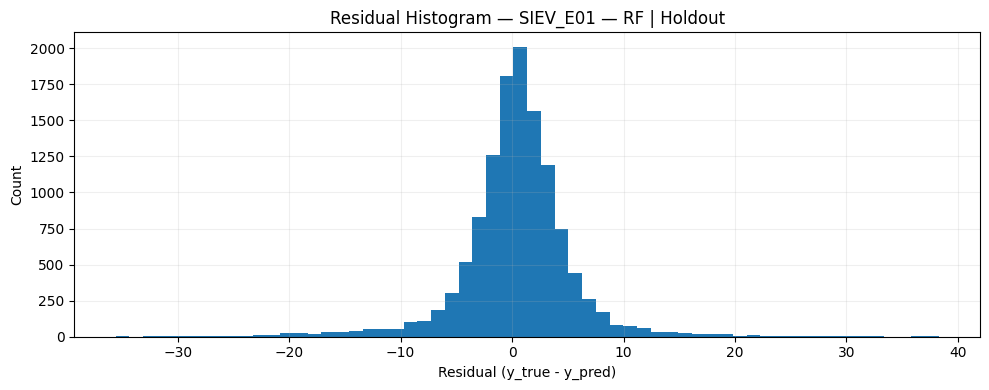

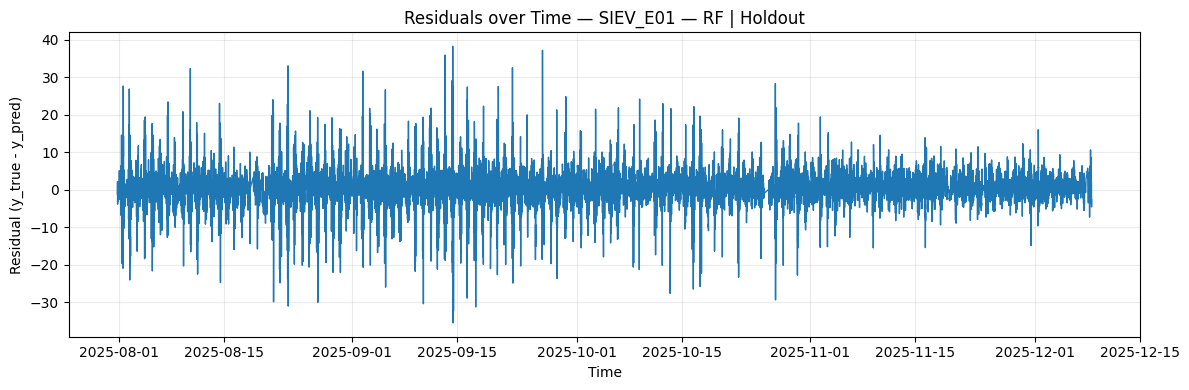

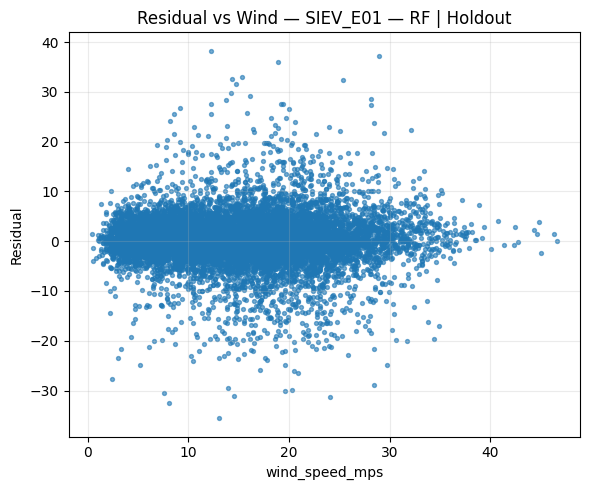

Residual analysis metrics (Holdout): {'MAE': 3.295775035445555, 'RMSE': 4.99522798065561, 'R2': 0.841831551192314}
Worst 10 errors (Holdout):


,timestamp,y_true,y_pred,residual,|residual|
0,2025-09-14 11:00:00,1.727695,-36.558267,38.285962,38.285962
1,2025-09-26 10:00:00,-3.523878,-40.722373,37.198495,37.198495
2,2025-09-13 10:15:00,-2.318594,-38.248408,35.929814,35.929814
3,2025-09-14 12:30:00,-49.317076,-13.750478,-35.566597,35.566597
4,2025-08-23 12:45:00,-7.727817,-40.753090,33.025273,33.025273
5,2025-09-22 10:00:00,-10.639768,-43.162777,32.523010,32.523010
6,2025-09-14 13:30:00,-44.528582,-12.062401,-32.466180,32.466180
7,2025-08-10 12:15:00,-4.899773,-37.225416,32.325642,32.325642
8,2025-09-02 11:30:00,-3.470986,-35.083434,31.612449,31.612449
9,2025-09-17 12:30:00,-47.110173,-15.793970,-31.316203,31.316203



NODE: Tarp_E01
Supervised samples: n=65607, features=21 (exog present: ['wind_speed_mps', 'solar_radiation_Wm2', 'temperature_C'])
Baseline (Persistence) | Train: {'MAE': 3.086314347264394, 'RMSE': 4.968467674013331, 'R2': 0.8796394940472644}
Baseline (Persistence) | Holdout: {'MAE': 2.9649542811363014, 'RMSE': 4.243859216021614, 'R2': 0.9069504862053495}

[Nested CV] Outer: 4 Inner: 4 (N_ITER=20 per model/fold)

Nested CV (mean over outer folds) — sorted by MAE:


,node_id,model,MAE,RMSE,R2,fit_seconds
4,Tarp_E01,RF,3.196133,4.741446,0.875182,417.557744
14,Tarp_E01,Ridge,3.198900,4.794236,0.871562,0.675738
9,Tarp_E01,HGB,3.248154,4.807630,0.872616,11.248869


Selected best model for node Tarp_E01: RF

[Learning Curves] Growing window for selected model


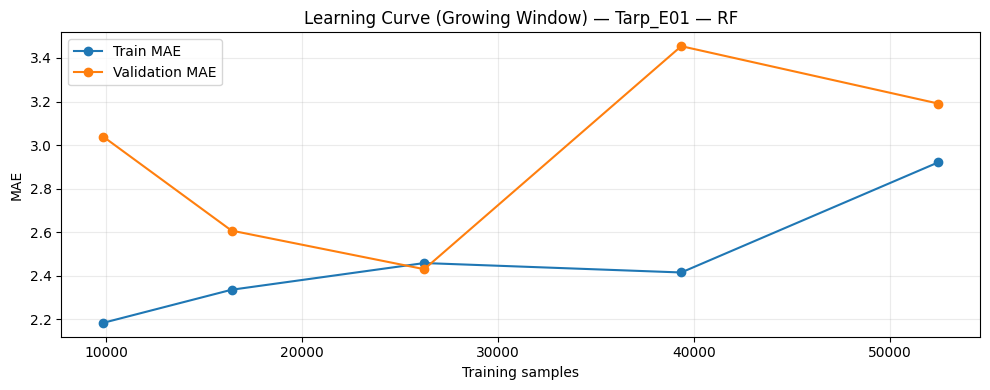


[Final Tuning on Train] + Residual analysis on Holdout
Final best params: {'n_estimators': 200, 'min_samples_leaf': 10, 'max_features': None, 'max_depth': 8}


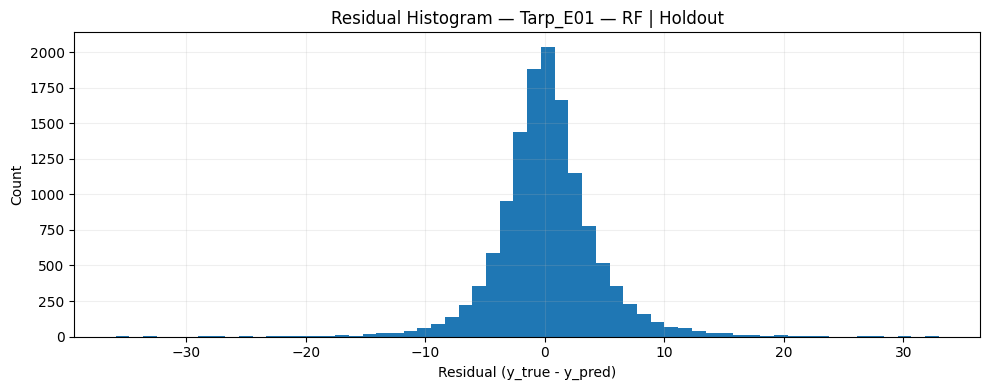

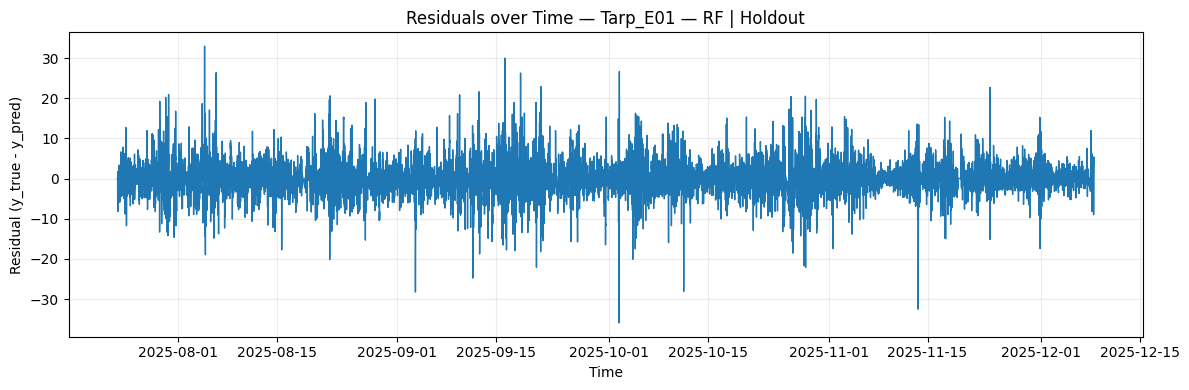

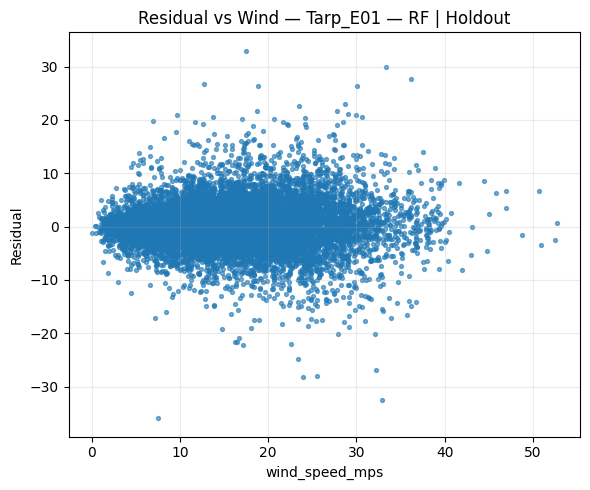

Residual analysis metrics (Holdout): {'MAE': 2.9600905777932494, 'RMSE': 4.215628338269125, 'R2': 0.908184331214358}
Worst 10 errors (Holdout):


,timestamp,y_true,y_pred,residual,|residual|
0,2025-10-02 08:00:00,-20.999016,14.933247,-35.932263,35.932263
1,2025-08-04 17:00:00,51.490695,18.512409,32.978285,32.978285
2,2025-11-13 16:15:00,38.775075,71.281891,-32.506816,32.506816
3,2025-09-16 05:30:00,64.816632,34.818201,29.998431,29.998431
4,2025-09-03 13:00:00,7.869011,36.123032,-28.254021,28.254021
5,2025-10-11 12:00:00,50.532980,78.604660,-28.071680,28.071680
6,2025-09-16 05:15:00,61.217683,33.609219,27.608464,27.608464
7,2025-11-13 16:30:00,32.469152,59.346363,-26.877211,26.877211
8,2025-10-02 09:30:00,19.639404,-7.049077,26.688481,26.688481
9,2025-08-06 08:15:00,59.377259,33.002401,26.374858,26.374858



GLOBAL SUMMARY — Nested CV mean rows (per node/model)


,node_id,model,MAE,RMSE,R2,fit_seconds
4,SHUW_E24,RF,5.694381,8.606193,0.888947,470.509756
9,SHUW_E24,HGB,5.707630,8.637628,0.889394,10.350371
14,SHUW_E24,Ridge,5.732747,8.704769,0.884209,0.638047
19,SIEV_E01,RF,2.149553,4.039254,0.895589,439.590178
24,SIEV_E01,HGB,2.275760,4.148611,0.889975,7.018460
29,SIEV_E01,Ridge,2.531349,4.159650,0.888619,0.584826
34,Tarp_E01,RF,3.196133,4.741446,0.875182,417.557744
44,Tarp_E01,Ridge,3.198900,4.794236,0.871562,0.675738
39,Tarp_E01,HGB,3.248154,4.807630,0.872616,11.248869



GLOBAL SUMMARY — Final holdout residual metrics (best model per node)


,node_id,model,MAE,RMSE,R2,best_params
2,Tarp_E01,RF,2.960091,4.215628,0.908184,"{'n_estimators': 200, 'min_samples_leaf': 10, ..."
1,SIEV_E01,RF,3.295775,4.995228,0.841832,"{'n_estimators': 800, 'min_samples_leaf': 10, ..."
0,SHUW_E24,RF,5.134020,7.218796,0.932571,"{'n_estimators': 200, 'min_samples_leaf': 5, '..."


In [3]:
# ============================================================
# FULL PIPELINE CELL (3 Nodes) — RF + HGB + Ridge (NO SMOKE TEST)
# - Node selection (low/mid/high) from CLEAN_TS_DIR
# - Feature engineering (lags + time + optional weather + Fourier)
# - Baseline: Persistence (ŷ(t+1)=y(t))
# - Nested CV: Outer TimeSeriesSplit (evaluation) + Inner TimeSeriesSplit (tuning)
# - Learning curves (growing train window)
# - Residual analysis on final holdout
# - Metrics: MAE, RMSE, R2 (NO MAPE)
# ============================================================

import warnings, math, time
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

from src.config import CLEAN_TS_DIR


# =========================
# Settings
# =========================
TIMESTAMP_COL = "timestamp"
TARGET = "P_MW"

# Weather features: keep if they exist in your CSVs; otherwise set to []
RAW_FEATURES = ["wind_speed_mps", "solar_radiation_Wm2", "temperature_C"]

# autoregressive lags in 15-min steps
TARGET_LAGS = [1, 4, 8, 12, 24, 96]

# Fourier daily seasonality (24h = 96 steps)
FOURIER_K = 3
PERIOD_STEPS = 96

# Node selection
MIN_COVERAGE = 0.20
SELECT_BY = "median"  # "median" or "p95" or "mean"

# Nested CV
OUTER_SPLITS = 4
INNER_SPLITS = 4

# Final holdout for residual plots
FINAL_HOLDOUT_FRAC = 0.20

# Search budget (per model per outer fold)
N_ITER = 20
RANDOM_STATE = 42
N_JOBS = -1

# Learning curve
LC_TRAIN_FRACS = [0.15, 0.25, 0.40, 0.60, 0.80]  # growing training window (chronological)
LC_VAL_FRAC = 0.10                               # fixed forward validation window size (fraction of total)
LC_MIN_POINTS = 2000                             # skip learning curve if series too short


# =========================
# Metrics / Helpers
# =========================
def evaluate(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mae = float(mean_absolute_error(y_true, y_pred))
    rmse = float(math.sqrt(mean_squared_error(y_true, y_pred)))
    r2 = float(r2_score(y_true, y_pred))
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

def add_time_features(df):
    ts = pd.to_datetime(df[TIMESTAMP_COL], utc=False)
    df["hour"] = ts.dt.hour
    df["dayofweek"] = ts.dt.dayofweek
    df["month"] = ts.dt.month

    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
    df["dow_sin"]  = np.sin(2 * np.pi * df["dayofweek"] / 7)
    df["dow_cos"]  = np.cos(2 * np.pi * df["dayofweek"] / 7)
    df["month_sin"]= np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"]= np.cos(2 * np.pi * df["month"] / 12)
    return df

def add_fourier_features(df, period_steps=PERIOD_STEPS, K=FOURIER_K, prefix="day"):
    step_idx = (np.arange(len(df), dtype=float) % period_steps)
    for k in range(1, K + 1):
        df[f"{prefix}_sin{k}"] = np.sin(2 * np.pi * k * step_idx / period_steps)
        df[f"{prefix}_cos{k}"] = np.cos(2 * np.pi * k * step_idx / period_steps)
    return df

def add_target_lags(df, target_col, lags):
    for L in lags:
        df[f"{target_col}_lag{L}"] = df[target_col].shift(L)
    return df

def prepare_supervised_df(df_raw):
    df = df_raw.copy()
    df[TIMESTAMP_COL] = pd.to_datetime(df[TIMESTAMP_COL], utc=False)
    df = df.sort_values(TIMESTAMP_COL).reset_index(drop=True)

    # feature engineering
    df = add_time_features(df)
    df = add_fourier_features(df)
    df = add_target_lags(df, TARGET, TARGET_LAGS)

    # one-step ahead target (t+1)
    df["target_1"] = df[TARGET].shift(-1)

    present_feats = [c for c in RAW_FEATURES if c in df.columns]
    time_feats = ["hour_sin","hour_cos","dow_sin","dow_cos","month_sin","month_cos"]
    fourier_feats = [f"day_sin{k}" for k in range(1, FOURIER_K+1)] + [f"day_cos{k}" for k in range(1, FOURIER_K+1)]
    lag_feats = [f"{TARGET}_lag{L}" for L in TARGET_LAGS]
    feature_cols = present_feats + time_feats + fourier_feats + lag_feats

    df_model = df.dropna(subset=feature_cols + ["target_1"]).copy()
    X = df_model[feature_cols]
    y = df_model["target_1"].astype(float)
    t = df_model[TIMESTAMP_COL]
    return df_model, X, y, t, feature_cols, present_feats

def baseline_persistence_from_lag1(df_model, split_idx):
    y_train = df_model["target_1"].iloc[:split_idx].values
    y_test  = df_model["target_1"].iloc[split_idx:].values
    yhat_train = df_model[f"{TARGET}_lag1"].iloc[:split_idx].values
    yhat_test  = df_model[f"{TARGET}_lag1"].iloc[split_idx:].values
    return evaluate(y_train, yhat_train), evaluate(y_test, yhat_test)


# =========================
# Models + Hyperparameter spaces (RF, HGB, Ridge)
# =========================
def make_models_and_spaces():
    models = {}

    models["RF"] = (
        RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=N_JOBS),
        {
            "n_estimators": [200, 400, 800],
            "max_depth": [None, 8, 12, 16, 24],
            "min_samples_leaf": [1, 2, 5, 10],
            "max_features": ["sqrt", 0.5, 0.8, None],
        },
    )

    models["HGB"] = (
        HistGradientBoostingRegressor(random_state=RANDOM_STATE),
        {
            "learning_rate": [0.03, 0.05, 0.08, 0.1],
            "max_depth": [None, 6, 10, 14],
            "max_leaf_nodes": [31, 63, 127],
            "min_samples_leaf": [10, 20, 50],
            "l2_regularization": [0.0, 0.1, 1.0],
        },
    )

    models["Ridge"] = (
        Pipeline([("scaler", StandardScaler()), ("model", Ridge(random_state=RANDOM_STATE))]),
        {
            "model__alpha": np.logspace(-3, 3, 20).tolist(),
        },
    )

    return models


# =========================
# Nested CV
# =========================
def nested_cv_for_node(X, y, model_specs, node_id, scoring="neg_mean_absolute_error"):
    outer = TimeSeriesSplit(n_splits=OUTER_SPLITS)
    inner = TimeSeriesSplit(n_splits=INNER_SPLITS)

    fold_rows = []

    for model_name, (estimator, param_dist) in model_specs.items():
        fold_scores = []
        fold_fit_secs = []

        for fold_i, (tr_idx, te_idx) in enumerate(outer.split(X), start=1):
            X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
            X_te, y_te = X.iloc[te_idx], y.iloc[te_idx]

            search = RandomizedSearchCV(
                estimator=estimator,
                param_distributions=param_dist,
                n_iter=N_ITER,
                scoring=scoring,
                cv=inner,
                random_state=RANDOM_STATE,
                n_jobs=N_JOBS,
                verbose=0,
            )

            t0 = time.time()
            search.fit(X_tr, y_tr)
            fit_s = time.time() - t0

            best = search.best_estimator_
            y_hat = best.predict(X_te)
            metrics = evaluate(y_te.values, y_hat)

            fold_scores.append(metrics)
            fold_fit_secs.append(fit_s)

            fold_rows.append({
                "node_id": node_id,
                "model": model_name,
                "outer_fold": fold_i,
                "MAE": metrics["MAE"],
                "RMSE": metrics["RMSE"],
                "R2": metrics["R2"],
                "fit_seconds": float(fit_s),
                "best_params": str(search.best_params_),
            })

        # mean row per model
        fold_rows.append({
            "node_id": node_id,
            "model": model_name,
            "outer_fold": "MEAN",
            "MAE": float(np.mean([s["MAE"] for s in fold_scores])),
            "RMSE": float(np.mean([s["RMSE"] for s in fold_scores])),
            "R2": float(np.mean([s["R2"] for s in fold_scores])),
            "fit_seconds": float(np.mean(fold_fit_secs)),
            "best_params": "(varies per fold)",
        })

    results = pd.DataFrame(fold_rows)
    mean_rows = results[results["outer_fold"].astype(str) == "MEAN"].copy()
    best_model = mean_rows.sort_values("MAE", ascending=True).iloc[0]["model"]
    return results, best_model


# =========================
# Learning Curves (growing train window)
# =========================
def learning_curve_growing_window(X, y, estimator, param_dist, node_id, model_name):
    n = len(X)
    if n < LC_MIN_POINTS:
        print(f"[{node_id} | {model_name}] Learning curve skipped (n={n} < {LC_MIN_POINTS}).")
        return None

    val_len = max(int(LC_VAL_FRAC * n), 200)
    curves = []

    for frac in LC_TRAIN_FRACS:
        train_end = int(frac * n)
        val_start = train_end
        val_end = min(train_end + val_len, n)

        if train_end < 500 or (val_end - val_start) < 100:
            continue

        X_tr, y_tr = X.iloc[:train_end], y.iloc[:train_end]
        X_va, y_va = X.iloc[val_start:val_end], y.iloc[val_start:val_end]

        inner = TimeSeriesSplit(n_splits=INNER_SPLITS)

        # light tuning per LC point (keeps it meaningful)
        search = RandomizedSearchCV(
            estimator=estimator,
            param_distributions=param_dist,
            n_iter=max(8, N_ITER // 2),
            scoring="neg_mean_absolute_error",
            cv=inner,
            random_state=RANDOM_STATE,
            n_jobs=N_JOBS,
            verbose=0,
        )

        t0 = time.time()
        search.fit(X_tr, y_tr)
        best = search.best_estimator_
        fit_s = time.time() - t0

        pred_tr = best.predict(X_tr)
        pred_va = best.predict(X_va)

        curves.append({
            "train_frac": float(frac),
            "train_n": int(len(X_tr)),
            "val_n": int(len(X_va)),
            "train_MAE": float(mean_absolute_error(y_tr, pred_tr)),
            "val_MAE": float(mean_absolute_error(y_va, pred_va)),
            "fit_seconds": float(fit_s),
        })

    if not curves:
        print(f"[{node_id} | {model_name}] Learning curve: not enough data for configured windows.")
        return None

    lc = pd.DataFrame(curves)

    plt.figure(figsize=(10, 4))
    plt.plot(lc["train_n"], lc["train_MAE"], marker="o", label="Train MAE")
    plt.plot(lc["train_n"], lc["val_MAE"], marker="o", label="Validation MAE")
    plt.title(f"Learning Curve (Growing Window) — {node_id} — {model_name}")
    plt.xlabel("Training samples")
    plt.ylabel("MAE")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return lc


# =========================
# Residual Analysis (final holdout)
# =========================
def residual_analysis(df_model, X, y, t, best_estimator, node_id, model_name, present_feats):
    n = len(X)
    split_idx = int((1.0 - FINAL_HOLDOUT_FRAC) * n)

    X_tr, y_tr = X.iloc[:split_idx], y.iloc[:split_idx]
    X_te, y_te = X.iloc[split_idx:], y.iloc[split_idx:]
    t_te = t.iloc[split_idx:]

    best_estimator.fit(X_tr, y_tr)
    y_hat = best_estimator.predict(X_te)
    resid = (y_te.values - y_hat)

    metrics = evaluate(y_te.values, y_hat)

    # 1) residual histogram
    plt.figure(figsize=(10, 4))
    plt.hist(resid, bins=60)
    plt.title(f"Residual Histogram — {node_id} — {model_name} | Holdout")
    plt.xlabel("Residual (y_true - y_pred)")
    plt.ylabel("Count")
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

    # 2) residual over time
    plt.figure(figsize=(12, 4))
    plt.plot(t_te.values, resid, linewidth=1.0)
    plt.title(f"Residuals over Time — {node_id} — {model_name} | Holdout")
    plt.xlabel("Time")
    plt.ylabel("Residual (y_true - y_pred)")
    plt.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()

    # 3) residual vs wind (if available)
    if "wind_speed_mps" in present_feats:
        wind_te = df_model.loc[X_te.index, "wind_speed_mps"].values
        plt.figure(figsize=(6, 5))
        plt.scatter(wind_te, resid, s=8, alpha=0.6)
        plt.title(f"Residual vs Wind — {node_id} — {model_name} | Holdout")
        plt.xlabel("wind_speed_mps")
        plt.ylabel("Residual")
        plt.grid(True, alpha=0.25)
        plt.tight_layout()
        plt.show()

    # Worst cases
    abs_res = np.abs(resid)
    worst_idx = np.argsort(-abs_res)[:10]
    worst = pd.DataFrame({
        "timestamp": t_te.iloc[worst_idx].values,
        "y_true": y_te.iloc[worst_idx].values,
        "y_pred": y_hat[worst_idx],
        "residual": resid[worst_idx],
        "|residual|": abs_res[worst_idx],
    }).sort_values("|residual|", ascending=False)

    return metrics, worst


# =========================
# 0) Select LOW/MID/HIGH nodes (your logic)
# =========================
meas_dir = Path(CLEAN_TS_DIR)
files = sorted(meas_dir.glob("*_hist_clean.csv"))
assert files, f"Keine *_hist_clean.csv in {meas_dir}"

rows = []
for p in files:
    node_id = p.stem.replace("_hist_clean", "")
    df = pd.read_csv(p, parse_dates=[TIMESTAMP_COL]).sort_values(TIMESTAMP_COL)
    if TARGET not in df.columns:
        continue
    s = df[TARGET].astype(float)

    coverage = 1.0 - s.isna().mean()
    if coverage < MIN_COVERAGE:
        continue

    rows.append({
        "node_id": node_id,
        "coverage": coverage,
        "mean": float(s.mean(skipna=True)),
        "median": float(s.median(skipna=True)),
        "p95": float(s.quantile(0.95)),
        "std": float(s.std(skipna=True)),
        "n": int(len(s)),
    })

stats = pd.DataFrame(rows)
assert not stats.empty, "Nach Coverage-Filter keine Nodes übrig. MIN_COVERAGE senken."
stats = stats.sort_values(SELECT_BY).reset_index(drop=True)

low_node = stats.iloc[0]["node_id"]
mid_node = stats.iloc[len(stats)//2]["node_id"]
high_node = stats.iloc[-1]["node_id"]

print("Auswahl nach", SELECT_BY, "mit MIN_COVERAGE", MIN_COVERAGE)
print("LOW :", low_node)
print("MID :", mid_node)
print("HIGH:", high_node)
display(stats.loc[stats["node_id"].isin([low_node, mid_node, high_node])])


# =========================
# 1) Run everything per node
# =========================
model_specs = make_models_and_spaces()

all_nested = []
all_learning_curves = {}
all_residuals = []
all_worst = {}

for node_id in [low_node, mid_node, high_node]:
    print("\n" + "="*90)
    print(f"NODE: {node_id}")
    print("="*90)

    path = meas_dir / f"{node_id}_hist_clean.csv"
    df_raw = pd.read_csv(path)

    df_model, X, y, t, feature_cols, present_feats = prepare_supervised_df(df_raw)
    n = len(X)
    print(f"Supervised samples: n={n}, features={len(feature_cols)} (exog present: {present_feats})")
    assert n > 0, f"{node_id}: Nach Feature/Lag-Dropna keine Samples übrig. Prüfe Spalten/NaNs/Lags."

    # Baseline (persistence)
    split_idx = int((1.0 - FINAL_HOLDOUT_FRAC) * n)
    bl_tr, bl_te = baseline_persistence_from_lag1(df_model, split_idx)
    print("Baseline (Persistence) | Train:", bl_tr)
    print("Baseline (Persistence) | Holdout:", bl_te)

    # Nested CV
    print("\n[Nested CV] Outer:", OUTER_SPLITS, "Inner:", INNER_SPLITS, f"(N_ITER={N_ITER} per model/fold)")
    nested_df, best_model_name = nested_cv_for_node(X, y, model_specs, node_id=node_id)
    all_nested.append(nested_df)

    mean_rows = nested_df[nested_df["outer_fold"].astype(str) == "MEAN"].sort_values("MAE")
    print("\nNested CV (mean over outer folds) — sorted by MAE:")
    display(mean_rows[["node_id","model","MAE","RMSE","R2","fit_seconds"]])

    print(f"Selected best model for node {node_id}: {best_model_name}")

    # Learning Curves for selected model
    print("\n[Learning Curves] Growing window for selected model")
    est, pspace = model_specs[best_model_name]
    lc = learning_curve_growing_window(X, y, est, pspace, node_id=node_id, model_name=best_model_name)
    all_learning_curves[node_id] = lc

    # Final tuning on train + residuals on holdout
    print("\n[Final Tuning on Train] + Residual analysis on Holdout")
    X_tr, y_tr = X.iloc[:split_idx], y.iloc[:split_idx]
    inner = TimeSeriesSplit(n_splits=INNER_SPLITS)

    final_search = RandomizedSearchCV(
        estimator=est,
        param_distributions=pspace,
        n_iter=max(25, N_ITER),
        scoring="neg_mean_absolute_error",
        cv=inner,
        random_state=RANDOM_STATE,
        n_jobs=N_JOBS,
        verbose=0,
    )
    final_search.fit(X_tr, y_tr)
    final_best = final_search.best_estimator_
    print("Final best params:", final_search.best_params_)

    res_metrics, worst = residual_analysis(
        df_model=df_model,
        X=X, y=y, t=t,
        best_estimator=final_best,
        node_id=node_id,
        model_name=best_model_name,
        present_feats=present_feats
    )
    print("Residual analysis metrics (Holdout):", res_metrics)
    print("Worst 10 errors (Holdout):")
    display(worst)

    all_residuals.append({
        "node_id": node_id,
        "model": best_model_name,
        **res_metrics,
        "best_params": str(final_search.best_params_)
    })
    all_worst[node_id] = worst


# =========================
# 2) Global summary tables
# =========================
nested_all = pd.concat(all_nested, ignore_index=True)
print("\n" + "="*90)
print("GLOBAL SUMMARY — Nested CV mean rows (per node/model)")
print("="*90)
nested_means = nested_all[nested_all["outer_fold"].astype(str) == "MEAN"].copy()
nested_means = nested_means.sort_values(["node_id", "MAE"])
display(nested_means[["node_id","model","MAE","RMSE","R2","fit_seconds"]])

residual_summary = pd.DataFrame(all_residuals).sort_values("MAE")
print("\n" + "="*90)
print("GLOBAL SUMMARY — Final holdout residual metrics (best model per node)")
print("="*90)
display(residual_summary)


In [4]:
# ============================================================
# EXPERIMENT CELL (ONLY 1 NODE = HIGH with most power)
# - Select the single "HIGH" node = highest absolute median |P_MW| (after coverage filter)
# - Train/tune models on ONE-STEP target (t+1), but EVALUATE on DAY-AHEAD horizon H=100
# - Compare:
#     (1) Persistence baseline (day-ahead)
#     (2) Ridge / RandomForest / HistGradientBoosting with RECURSIVE 100-step rollout
#     (3) DIRECT Multi-Horizon (stacked) for the BEST model (by day-ahead MAE)
# - Final output: table + MAE(h) curves
# Metrics: MAE, RMSE, R2 (no MAPE)
# ============================================================

import warnings, math, time
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

from src.config import CLEAN_TS_DIR


# =========================
# Settings
# =========================
TIMESTAMP_COL = "timestamp"
TARGET = "P_MW"

# if weather columns differ or are missing -> set RAW_FEATURES = []
RAW_FEATURES = ["wind_speed_mps", "solar_radiation_Wm2", "temperature_C"]

# autoregressive lags in 15-min steps
TARGET_LAGS = [1, 4, 8, 12, 24, 96]

# Fourier daily seasonality (24h = 96 steps)
FOURIER_K = 3
PERIOD_STEPS = 96

# Node selection
MIN_COVERAGE = 0.20

# Day-ahead horizon
H = 100  # ~25h (15-min steps)

# Splits
FINAL_HOLDOUT_FRAC = 0.20          # final day-ahead evaluation window
OUTER_SPLITS = 4                   # outer backtest folds (on remaining data)
INNER_SPLITS = 4                   # tuning CV folds

# Hyperparam search budget
N_ITER = 20
RANDOM_STATE = 42
N_JOBS = -1

# Computational knobs (day-ahead evaluation can be heavy)
ORIGIN_STRIDE = 4                  # evaluate every 4th origin (1h stride) to speed up
MAX_TEST_ORIGINS_PER_FOLD = None   # optionally cap origins per fold (e.g. 2000) or leave None

# Learning curves are optional; keep off by default for day-ahead experiments
DO_LEARNING_CURVES = False


# =========================
# Helpers
# =========================
def evaluate(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mae = float(mean_absolute_error(y_true, y_pred))
    rmse = float(math.sqrt(mean_squared_error(y_true, y_pred)))
    r2 = float(r2_score(y_true, y_pred))
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

def add_time_features(df):
    ts = pd.to_datetime(df[TIMESTAMP_COL], utc=False)
    df["hour"] = ts.dt.hour
    df["dayofweek"] = ts.dt.dayofweek
    df["month"] = ts.dt.month

    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
    df["dow_sin"]  = np.sin(2 * np.pi * df["dayofweek"] / 7)
    df["dow_cos"]  = np.cos(2 * np.pi * df["dayofweek"] / 7)
    df["month_sin"]= np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"]= np.cos(2 * np.pi * df["month"] / 12)
    return df

def add_fourier_features(df, period_steps=PERIOD_STEPS, K=FOURIER_K, prefix="day"):
    step_idx = (np.arange(len(df), dtype=float) % period_steps)
    for k in range(1, K + 1):
        df[f"{prefix}_sin{k}"] = np.sin(2 * np.pi * k * step_idx / period_steps)
        df[f"{prefix}_cos{k}"] = np.cos(2 * np.pi * k * step_idx / period_steps)
    return df

def add_target_lags(df, target_col, lags):
    for L in lags:
        df[f"{target_col}_lag{L}"] = df[target_col].shift(L)
    return df

def prepare_df(df_raw):
    df = df_raw.copy()
    df[TIMESTAMP_COL] = pd.to_datetime(df[TIMESTAMP_COL], utc=False)
    df = df.sort_values(TIMESTAMP_COL).reset_index(drop=True)

    df = add_time_features(df)
    df = add_fourier_features(df)
    df = add_target_lags(df, TARGET, TARGET_LAGS)

    # one-step target
    df["target_1"] = df[TARGET].shift(-1)

    present_feats = [c for c in RAW_FEATURES if c in df.columns]
    time_feats = ["hour_sin","hour_cos","dow_sin","dow_cos","month_sin","month_cos"]
    fourier_feats = [f"day_sin{k}" for k in range(1, FOURIER_K+1)] + [f"day_cos{k}" for k in range(1, FOURIER_K+1)]
    lag_feats = [f"{TARGET}_lag{L}" for L in TARGET_LAGS]

    exog_cols = present_feats + time_feats + fourier_feats
    lag_cols = lag_feats
    feature_cols = exog_cols + lag_cols

    df_model = df.dropna(subset=feature_cols + ["target_1", TARGET]).copy()
    df_model = df_model.reset_index(drop=True)
    return df_model, feature_cols, exog_cols, lag_cols, present_feats

def make_models_and_spaces():
    models = {}

    models["Ridge"] = (
        Pipeline([("scaler", StandardScaler()), ("model", Ridge(random_state=RANDOM_STATE))]),
        {"model__alpha": np.logspace(-3, 3, 20).tolist()},
    )

    models["RF"] = (
        RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=N_JOBS),
        {
            "n_estimators": [200, 400, 800],
            "max_depth": [None, 8, 12, 16, 24],
            "min_samples_leaf": [1, 2, 5, 10],
            "max_features": ["sqrt", 0.5, 0.8, None],
        },
    )

    models["HGB"] = (
        HistGradientBoostingRegressor(random_state=RANDOM_STATE),
        {
            "learning_rate": [0.03, 0.05, 0.08, 0.1],
            "max_depth": [None, 6, 10, 14],
            "max_leaf_nodes": [31, 63, 127],
            "min_samples_leaf": [10, 20, 50],
            "l2_regularization": [0.0, 0.1, 1.0],
        },
    )

    return models

# ------------------------------------------------------------
# Day-ahead evaluation (Recursive) for a model trained on one-step:
# model predicts y(t+1) from features at time t.
# For horizon k we simulate k steps ahead and feed predictions into lag features.
# Exogenous/time/fourier features are taken from the dataset at each step (assumed known for evaluation).
# ------------------------------------------------------------
def _update_lags_from_history(lag_cols, lag_steps, history_values):
    # history_values: dict {step: value} for step=1..max_lag where step=1 means last value y(t)
    # return lag feature vector aligned to lag_cols
    return np.array([history_values[int(col.split("lag")[1])] for col in lag_cols], dtype=float)

def evaluate_day_ahead_recursive(
    model, df_model, feature_cols, exog_cols, lag_cols, H=100,
    origin_indices=None, origin_stride=1
):
    # We evaluate from "origin" indices j where true future values exist up to j+H
    n = len(df_model)
    max_origin = n - H - 1  # need y at j+H
    if max_origin <= 0:
        raise ValueError(f"Not enough data for H={H}. n={n}")

    if origin_indices is None:
        origin_indices = np.arange(0, max_origin + 1, origin_stride, dtype=int)
    else:
        origin_indices = np.asarray(origin_indices, dtype=int)
        origin_indices = origin_indices[origin_indices <= max_origin]

    # Store per-h errors
    abs_errors_h = [[] for _ in range(H)]
    sq_errors_h = [[] for _ in range(H)]
    y_true_all = []
    y_pred_all = []

    # Precompute lag steps from col names
    lag_steps = [int(c.split("lag")[1]) for c in lag_cols]
    max_lag = max(lag_steps)

    for j in origin_indices:
        # Initialize history values from REAL series at origin time
        # Define "origin time" as df_model index j, corresponding to y(t) = P_MW at that index
        # For recursive, step1 prediction uses features at time j.
        history = {}
        # history[1] should be y(t) = P_MW at index j
        # history[L] should be y(t-L+1) = P_MW at index j-(L-1)
        for L in range(1, max_lag + 1):
            idx = j - (L - 1)
            if idx < 0:
                history[L] = np.nan
            else:
                history[L] = float(df_model[TARGET].iloc[idx])
        if any(np.isnan(history[L]) for L in lag_steps):
            continue

        # Simulate k=1..H
        for k in range(1, H + 1):
            step_idx = j + (k - 1)  # features at time t+(k-1)
            # Build feature row
            exog = df_model.loc[step_idx, exog_cols].astype(float).values if exog_cols else np.array([], dtype=float)
            lag_vec = _update_lags_from_history(lag_cols, lag_steps, history)
            x = np.concatenate([exog, lag_vec]).reshape(1, -1)

            y_hat = float(model.predict(x)[0])

            # True is y(t+k) = P_MW at index j+k
            y_true = float(df_model[TARGET].iloc[j + k])

            err = y_true - y_hat
            abs_errors_h[k-1].append(abs(err))
            sq_errors_h[k-1].append(err * err)

            y_true_all.append(y_true)
            y_pred_all.append(y_hat)

            # Update history: shift lags by 1 and insert prediction as new y(t) for next step
            # history[1] becomes predicted y(t+1) etc.
            for L in range(max_lag, 1, -1):
                history[L] = history[L-1]
            history[1] = y_hat

    # Aggregate
    mae_h = np.array([np.mean(v) if len(v) else np.nan for v in abs_errors_h], dtype=float)
    rmse_h = np.array([math.sqrt(np.mean(v)) if len(v) else np.nan for v in sq_errors_h], dtype=float)

    # Overall metrics across all horizons and origins
    overall = evaluate(np.array(y_true_all), np.array(y_pred_all))
    return overall, mae_h, rmse_h

# ------------------------------------------------------------
# Persistence baseline for day-ahead:
# Predict all horizons with y(t) (constant)
# ------------------------------------------------------------
def evaluate_day_ahead_persistence(df_model, H=100, origin_stride=1):
    n = len(df_model)
    max_origin = n - H - 1
    origin_indices = np.arange(0, max_origin + 1, origin_stride, dtype=int)

    abs_errors_h = [[] for _ in range(H)]
    sq_errors_h = [[] for _ in range(H)]
    y_true_all, y_pred_all = [], []

    for j in origin_indices:
        y0 = float(df_model[TARGET].iloc[j])  # y(t)
        for k in range(1, H + 1):
            y_true = float(df_model[TARGET].iloc[j + k])
            y_hat = y0
            err = y_true - y_hat
            abs_errors_h[k-1].append(abs(err))
            sq_errors_h[k-1].append(err * err)
            y_true_all.append(y_true)
            y_pred_all.append(y_hat)

    mae_h = np.array([np.mean(v) if len(v) else np.nan for v in abs_errors_h], dtype=float)
    rmse_h = np.array([math.sqrt(np.mean(v)) if len(v) else np.nan for v in sq_errors_h], dtype=float)
    overall = evaluate(np.array(y_true_all), np.array(y_pred_all))
    return overall, mae_h, rmse_h

# ------------------------------------------------------------
# Direct Multi-Horizon (Stacked) for ONE model:
# Train single model on rows: (origin t, horizon h) -> y(t+h)
# Features:
#   - lag features from origin time t (history)
#   - exogenous/time/fourier from TARGET time (t+h)
#   - horizon feature h
# ------------------------------------------------------------
def build_stacked_direct_dataset(df_model, exog_cols, lag_cols, H=100, origin_stride=4):
    n = len(df_model)
    max_origin = n - H - 1
    origins = np.arange(0, max_origin + 1, origin_stride, dtype=int)

    X_rows = []
    y_rows = []

    for j in origins:
        lag_vec = df_model.loc[j, lag_cols].astype(float).values
        if np.any(np.isnan(lag_vec)):
            continue

        for h in range(1, H + 1):
            tgt_idx = j + h  # time of target y(t+h)
            exog_vec = df_model.loc[tgt_idx, exog_cols].astype(float).values if exog_cols else np.array([], dtype=float)

            # horizon features (simple + normalized)
            h_feat = np.array([h, h / H], dtype=float)

            x = np.concatenate([exog_vec, lag_vec, h_feat])
            X_rows.append(x)
            y_rows.append(float(df_model[TARGET].iloc[tgt_idx]))

    Xs = np.asarray(X_rows, dtype=float)
    ys = np.asarray(y_rows, dtype=float)
    return Xs, ys

def evaluate_day_ahead_direct(model, df_model, exog_cols, lag_cols, H=100, origin_stride=1):
    n = len(df_model)
    max_origin = n - H - 1
    origin_indices = np.arange(0, max_origin + 1, origin_stride, dtype=int)

    abs_errors_h = [[] for _ in range(H)]
    sq_errors_h = [[] for _ in range(H)]
    y_true_all, y_pred_all = [], []

    for j in origin_indices:
        lag_vec = df_model.loc[j, lag_cols].astype(float).values
        if np.any(np.isnan(lag_vec)):
            continue

        # predict all horizons
        X_batch = []
        y_true_batch = []
        for h in range(1, H + 1):
            tgt_idx = j + h
            exog_vec = df_model.loc[tgt_idx, exog_cols].astype(float).values if exog_cols else np.array([], dtype=float)
            h_feat = np.array([h, h / H], dtype=float)
            X_batch.append(np.concatenate([exog_vec, lag_vec, h_feat]))
            y_true_batch.append(float(df_model[TARGET].iloc[tgt_idx]))

        X_batch = np.asarray(X_batch, dtype=float)
        y_true_batch = np.asarray(y_true_batch, dtype=float)

        y_hat_batch = model.predict(X_batch).astype(float)

        for h in range(1, H + 1):
            err = y_true_batch[h-1] - y_hat_batch[h-1]
            abs_errors_h[h-1].append(abs(err))
            sq_errors_h[h-1].append(err * err)
            y_true_all.append(y_true_batch[h-1])
            y_pred_all.append(y_hat_batch[h-1])

    mae_h = np.array([np.mean(v) if len(v) else np.nan for v in abs_errors_h], dtype=float)
    rmse_h = np.array([math.sqrt(np.mean(v)) if len(v) else np.nan for v in sq_errors_h], dtype=float)
    overall = evaluate(np.array(y_true_all), np.array(y_pred_all))
    return overall, mae_h, rmse_h


# =========================
# 0) Select ONLY the single HIGH node (most power)
#    -> define "power" as abs(median P_MW) and pick maximum
# =========================
meas_dir = Path(CLEAN_TS_DIR)
files = sorted(meas_dir.glob("*_hist_clean.csv"))
assert files, f"Keine *_hist_clean.csv in {meas_dir}"

rows = []
for p in files:
    node_id = p.stem.replace("_hist_clean", "")
    df = pd.read_csv(p, parse_dates=[TIMESTAMP_COL]).sort_values(TIMESTAMP_COL)
    if TARGET not in df.columns:
        continue
    s = df[TARGET].astype(float)

    coverage = 1.0 - s.isna().mean()
    if coverage < MIN_COVERAGE:
        continue

    med = float(s.median(skipna=True))
    rows.append({
        "node_id": node_id,
        "coverage": float(coverage),
        "mean": float(s.mean(skipna=True)),
        "median": med,
        "abs_median": abs(med),
        "p95": float(s.quantile(0.95)),
        "std": float(s.std(skipna=True)),
        "n": int(len(s)),
    })

stats = pd.DataFrame(rows)
assert not stats.empty, "Nach Coverage-Filter keine Nodes übrig. MIN_COVERAGE senken."

stats = stats.sort_values("abs_median").reset_index(drop=True)
high_node = stats.iloc[-1]["node_id"]

print("Auswahlkriterium: MAX abs(median(P_MW)) mit MIN_COVERAGE", MIN_COVERAGE)
print("HIGH node:", high_node)
display(stats.tail(10))


# =========================
# 1) Load and prepare data for HIGH node
# =========================
path = meas_dir / f"{high_node}_hist_clean.csv"
df_raw = pd.read_csv(path)

df_model, feature_cols, exog_cols, lag_cols, present_feats = prepare_df(df_raw)
print(f"\nPrepared supervised base for {high_node}: n={len(df_model)}")
print("Exog present:", present_feats)
print("Feature cols:", len(feature_cols), "(exog/time/fourier:", len(exog_cols), ", lags:", len(lag_cols), ")")

assert len(df_model) > (H + 500), f"Time series too short for H={H}. n={len(df_model)}"


# =========================
# 2) Define train/holdout split for FINAL comparison (day-ahead)
# =========================
n = len(df_model)
split_idx = int((1.0 - FINAL_HOLDOUT_FRAC) * n)

# Ensure holdout has enough room for H-step evaluation
# We'll evaluate origins only inside the holdout window such that j+H is inside holdout
holdout_start = split_idx
holdout_end = n - 1
holdout_max_origin = (n - H - 1)
if holdout_start > holdout_max_origin:
    raise ValueError("Holdout window too small for day-ahead evaluation. Reduce FINAL_HOLDOUT_FRAC or H.")

print(f"\nFinal split: train [0:{split_idx}) | holdout [{split_idx}:{n})")
print(f"Holdout origins allowed up to index {holdout_max_origin} (H={H}).")


# =========================
# 3) Baseline: Persistence day-ahead (on holdout)
# =========================
# Evaluate only holdout origins (stride applied)
holdout_origins = np.arange(holdout_start, holdout_max_origin + 1, ORIGIN_STRIDE, dtype=int)
baseline_overall, baseline_mae_h, baseline_rmse_h = evaluate_day_ahead_persistence(
    df_model=df_model.iloc[holdout_start:].reset_index(drop=True),
    H=H,
    origin_stride=ORIGIN_STRIDE
)
# Note: We evaluate baseline on a reindexed holdout-only df_model. That's OK (origins are within holdout).


# =========================
# 4) Model selection on TRAIN using outer backtesting:
#    - Tune on one-step (inner CV)
#    - Evaluate day-ahead recursively on outer test segments
# =========================
models = make_models_and_spaces()

X_all = df_model[feature_cols].astype(float)
y_all = df_model["target_1"].astype(float)

# Only use TRAIN part for selection/backtesting
X_train_full = X_all.iloc[:split_idx].reset_index(drop=True)
y_train_full = y_all.iloc[:split_idx].reset_index(drop=True)
df_train_full = df_model.iloc[:split_idx].reset_index(drop=True)

# To evaluate H-step inside folds, we need origins where j+H exists inside the fold test region.
# We'll do: for each outer fold, evaluate on test origins within that fold.
outer = TimeSeriesSplit(n_splits=OUTER_SPLITS)

cv_rows = []

print("\n" + "="*90)
print("MODEL SELECTION (TRAIN): tune one-step, evaluate day-ahead recursive on outer folds")
print("="*90)

for model_name, (estimator, param_dist) in models.items():
    fold_maes = []
    fold_rmses = []
    fold_r2s = []
    fold_secs = []

    for fold_i, (tr_idx, te_idx) in enumerate(outer.split(X_train_full), start=1):
        X_tr, y_tr = X_train_full.iloc[tr_idx], y_train_full.iloc[tr_idx]
        df_tr = df_train_full.iloc[tr_idx].reset_index(drop=True)

        # Inner tuning on one-step (fast)
        inner = TimeSeriesSplit(n_splits=INNER_SPLITS)
        search = RandomizedSearchCV(
            estimator=estimator,
            param_distributions=param_dist,
            n_iter=N_ITER,
            scoring="neg_mean_absolute_error",
            cv=inner,
            random_state=RANDOM_STATE,
            n_jobs=N_JOBS,
            verbose=0,
        )

        t0 = time.time()
        search.fit(X_tr, y_tr)
        fit_s = time.time() - t0

        best = search.best_estimator_

        # Day-ahead recursive evaluation on outer test window:
        # Use df corresponding to the concatenation of (train_end .. test_end) so recursion can start at test origins.
        # For a strict test-only evaluation, we evaluate origins that are inside the test index range AND have future inside the same test range.
        df_fold = df_train_full.iloc[np.r_[tr_idx, te_idx]].reset_index(drop=True)

        # test region in df_fold is the tail segment of length len(te_idx)
        test_start = len(tr_idx)
        test_end = len(tr_idx) + len(te_idx) - 1
        max_origin = len(df_fold) - H - 1
        origin_start = test_start
        origin_end = min(max_origin, test_end - H)  # ensure y(t+H) still in test

        if origin_end < origin_start:
            # If fold test window is too short for H=100, skip this fold for day-ahead scoring
            continue

        origins = np.arange(origin_start, origin_end + 1, ORIGIN_STRIDE, dtype=int)
        if MAX_TEST_ORIGINS_PER_FOLD is not None and len(origins) > MAX_TEST_ORIGINS_PER_FOLD:
            origins = origins[:MAX_TEST_ORIGINS_PER_FOLD]

        overall, mae_h, rmse_h = evaluate_day_ahead_recursive(
            model=best,
            df_model=df_fold,
            feature_cols=feature_cols,
            exog_cols=exog_cols,
            lag_cols=lag_cols,
            H=H,
            origin_indices=origins,
            origin_stride=ORIGIN_STRIDE
        )

        fold_maes.append(overall["MAE"])
        fold_rmses.append(overall["RMSE"])
        fold_r2s.append(overall["R2"])
        fold_secs.append(fit_s)

        cv_rows.append({
            "model": model_name,
            "outer_fold": fold_i,
            "dayahead_MAE": overall["MAE"],
            "dayahead_RMSE": overall["RMSE"],
            "dayahead_R2": overall["R2"],
            "fit_seconds": float(fit_s),
            "best_params": str(search.best_params_),
        })

    # Mean summary row
    if len(fold_maes):
        cv_rows.append({
            "model": model_name,
            "outer_fold": "MEAN",
            "dayahead_MAE": float(np.mean(fold_maes)),
            "dayahead_RMSE": float(np.mean(fold_rmses)),
            "dayahead_R2": float(np.mean(fold_r2s)),
            "fit_seconds": float(np.mean(fold_secs)) if len(fold_secs) else np.nan,
            "best_params": "(varies per fold)",
        })

cv_df = pd.DataFrame(cv_rows)
print("\nOuter-fold day-ahead results (TRAIN backtest):")
display(cv_df)

mean_df = cv_df[cv_df["outer_fold"].astype(str) == "MEAN"].sort_values("dayahead_MAE")
print("\nModel ranking by day-ahead MAE (lower is better):")
display(mean_df[["model","dayahead_MAE","dayahead_RMSE","dayahead_R2","fit_seconds"]])

best_model_name = mean_df.iloc[0]["model"]
print("\nSelected BEST model by day-ahead MAE:", best_model_name)


# =========================
# 5) Final tuning on TRAIN (one-step) for each model, then FINAL holdout day-ahead eval (recursive)
# =========================
final_rows = []

print("\n" + "="*90)
print("FINAL HOLDOUT EVALUATION (DAY-AHEAD, RECURSIVE)")
print("="*90)

for model_name, (estimator, param_dist) in models.items():
    inner = TimeSeriesSplit(n_splits=INNER_SPLITS)
    search = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=param_dist,
        n_iter=max(25, N_ITER),
        scoring="neg_mean_absolute_error",
        cv=inner,
        random_state=RANDOM_STATE,
        n_jobs=N_JOBS,
        verbose=0,
    )

    t0 = time.time()
    search.fit(X_train_full, y_train_full)
    fit_s = time.time() - t0

    best = search.best_estimator_

    # Evaluate on holdout segment using recursive day-ahead
    df_hold = df_model.iloc[holdout_start:].reset_index(drop=True)

    overall, mae_h, rmse_h = evaluate_day_ahead_recursive(
        model=best,
        df_model=df_hold,
        feature_cols=feature_cols,
        exog_cols=exog_cols,
        lag_cols=lag_cols,
        H=H,
        origin_indices=None,
        origin_stride=ORIGIN_STRIDE
    )

    final_rows.append({
        "node": high_node,
        "approach": "Recursive",
        "model": model_name,
        "MAE": overall["MAE"],
        "RMSE": overall["RMSE"],
        "R2": overall["R2"],
        "fit_seconds": float(fit_s),
        "best_params": str(search.best_params_),
        "mae_h": mae_h,
        "rmse_h": rmse_h,
    })

final_df = pd.DataFrame([{k:v for k,v in r.items() if k not in ("mae_h","rmse_h")} for r in final_rows]).sort_values("MAE")
print("\nFinal holdout (recursive) — sorted by MAE:")
display(final_df)

best_recursive_row = [r for r in final_rows if r["model"] == best_model_name][0]
best_recursive_mae_h = best_recursive_row["mae_h"]


# =========================
# 6) Direct Multi-Horizon (Stacked) only for BEST model
# =========================
print("\n" + "="*90)
print(f"DIRECT MULTI-HORIZON (STACKED) for BEST model: {best_model_name}")
print("="*90)

# Use the BEST model class but build a direct-model instance.
# We only implement Direct for HGB / RF / Ridge; but in practice Direct is most useful for HGB.
if best_model_name == "Ridge":
    direct_estimator = Pipeline([("scaler", StandardScaler()), ("model", Ridge(random_state=RANDOM_STATE))])
    direct_space = {"model__alpha": np.logspace(-3, 3, 20).tolist()}
elif best_model_name == "RF":
    direct_estimator = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=N_JOBS)
    direct_space = {
        "n_estimators": [200, 400, 800],
        "max_depth": [None, 8, 12, 16, 24],
        "min_samples_leaf": [1, 2, 5, 10],
        "max_features": ["sqrt", 0.5, 0.8, None],
    }
else:
    # HGB
    direct_estimator = HistGradientBoostingRegressor(random_state=RANDOM_STATE)
    direct_space = {
        "learning_rate": [0.03, 0.05, 0.08, 0.1],
        "max_depth": [None, 6, 10, 14],
        "max_leaf_nodes": [31, 63, 127],
        "min_samples_leaf": [10, 20, 50],
        "l2_regularization": [0.0, 0.1, 1.0],
    }

# Build stacked training data from TRAIN only
df_train_for_direct = df_model.iloc[:split_idx].reset_index(drop=True)
X_direct, y_direct = build_stacked_direct_dataset(
    df_model=df_train_for_direct,
    exog_cols=exog_cols,
    lag_cols=lag_cols,
    H=H,
    origin_stride=ORIGIN_STRIDE
)

print(f"Direct stacked training set: X={X_direct.shape}, y={y_direct.shape}")

# Tune direct model on a simple split-based CV (TimeSeriesSplit isn't directly meaningful in stacked (t,h) space),
# so we do a lightweight CV by splitting along row order (still chronological by origin construction).
direct_cv = TimeSeriesSplit(n_splits=INNER_SPLITS)
direct_search = RandomizedSearchCV(
    estimator=direct_estimator,
    param_distributions=direct_space,
    n_iter=max(25, N_ITER),
    scoring="neg_mean_absolute_error",
    cv=direct_cv,
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS,
    verbose=0,
)

t0 = time.time()
direct_search.fit(X_direct, y_direct)
direct_fit_s = time.time() - t0
direct_best = direct_search.best_estimator_

# Evaluate direct on HOLDOUT
df_hold = df_model.iloc[holdout_start:].reset_index(drop=True)
direct_overall, direct_mae_h, direct_rmse_h = evaluate_day_ahead_direct(
    model=direct_best,
    df_model=df_hold,
    exog_cols=exog_cols,
    lag_cols=lag_cols,
    H=H,
    origin_stride=ORIGIN_STRIDE
)

direct_summary = {
    "node": high_node,
    "approach": "DirectStacked",
    "model": best_model_name,
    "MAE": direct_overall["MAE"],
    "RMSE": direct_overall["RMSE"],
    "R2": direct_overall["R2"],
    "fit_seconds": float(direct_fit_s),
    "best_params": str(direct_search.best_params_),
}


# =========================
# 7) Final comparison output (Baseline + Recursive models + Direct best)
# =========================
baseline_summary = {
    "node": high_node,
    "approach": "Baseline",
    "model": "Persistence",
    "MAE": baseline_overall["MAE"],
    "RMSE": baseline_overall["RMSE"],
    "R2": baseline_overall["R2"],
    "fit_seconds": 0.0,
    "best_params": "-",
}

final_compare = pd.DataFrame(
    [baseline_summary]
    + [{k:v for k,v in r.items() if k not in ("mae_h","rmse_h")} for r in final_rows]
    + [direct_summary]
).sort_values(["MAE","RMSE"])

print("\n" + "="*90)
print("FINAL COMPARISON (HOLDOUT, DAY-AHEAD H=100)")
print("="*90)
display(final_compare)

# -------------------------
# Plot: MAE(h) curves
# -------------------------
plt.figure(figsize=(12, 5))
plt.plot(np.arange(1, H+1), baseline_mae_h, label="Baseline: Persistence")

# recursive curves
for r in final_rows:
    plt.plot(np.arange(1, H+1), r["mae_h"], label=f"Recursive: {r['model']}")

# direct curve for best model
plt.plot(np.arange(1, H+1), direct_mae_h, linewidth=2.5, label=f"DirectStacked: {best_model_name}")

plt.title(f"Day-Ahead Error vs Horizon (MAE(h)) — Node: {high_node} — H={H}")
plt.xlabel("Horizon h (steps ahead)")
plt.ylabel("MAE")
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

# Optional: show summary numbers for recursive-best vs direct
print("\nBest model (by TRAIN backtest day-ahead MAE):", best_model_name)
print("Holdout Recursive metrics:", {k: best_recursive_row[k] for k in ["MAE","RMSE","R2"]})
print("Holdout DirectStacked metrics:", direct_summary)


Auswahlkriterium: MAX abs(median(P_MW)) mit MIN_COVERAGE 0.2
HIGH node: SHUW_E24


,node_id,coverage,mean,median,abs_median,p95,std,n
4,SIES_E02,0.963670,-3.882419,-2.711775,2.711775,0.101615,3.838584,67932
5,JUBO_E03,0.992684,-6.472750,-4.267534,4.267534,0.225324,6.778786,67932
6,Weding_E12,0.223398,5.096142,5.585331,5.585331,21.439718,10.662241,67928
7,BOLN_E02,1.000000,9.986058,6.252992,6.252992,32.715065,10.858590,68884
8,BOLN_E03,0.965083,-10.236055,-6.660924,6.660924,0.044664,10.827405,67932
9,JUBO_E02,0.968395,-13.422217,-8.518603,8.518603,0.016281,14.217622,67932
10,JUBO_E01,1.000000,19.478858,14.340093,14.340093,57.395562,17.829518,68883
11,Tarp_E01,0.991624,20.187161,18.133333,18.133333,45.600000,14.311861,67932
12,SHUW_E23,0.938394,-27.546251,-25.532667,25.532667,-0.696196,18.444187,67932
13,SHUW_E24,0.965112,-39.273152,-32.462383,32.462383,-3.477521,28.845634,67932



Prepared supervised base for SHUW_E24: n=64096
Exog present: ['wind_speed_mps', 'solar_radiation_Wm2', 'temperature_C']
Feature cols: 21 (exog/time/fourier: 15 , lags: 6 )

Final split: train [0:51276) | holdout [51276:64096)
Holdout origins allowed up to index 63995 (H=100).

MODEL SELECTION (TRAIN): tune one-step, evaluate day-ahead recursive on outer folds


KeyboardInterrupt: 